# Modeling and Evaluation

**Storm Intensity Change Prediction**<br><br>
**Author:** *Ishan Singh Bhullar*<br>
**Created:** *11 December 2022*<br>
**Contact:** *ishanbhullar@gmail.com*<br>
**Last Edit:** *26 September 2024*<br>

## Table of Contents

1. [Introduction](#Introduction)<br><br>
    - [ML Models Used](#ml-models-used)<br><br>
    - [Evaluation Metrics](#evaluation-metrics)<br><br>
    - [Importing Relevant Libraries](#importing-relevant-libraries)<br><br>
    - [Custom Functions](#custom-functions)<br><br>
    - [Reading Data](#reading-data)<br><br>
    - [Encoding Non-Numeric Columns](#encoding-non-numeric-columns)<br><br>
2. [Modeling and Evaluation](#Modeling-and-Evaluation)<br><br>
    - [X (features) and y (target)](#X-(features)-and-y-(target))<br><br>
    - [Test, Train, Validation Split](#Test,-Train,-Validation-Split)<br><br>
    - [Statsmodels Logistic Regression](#Statsmodels-Logistic-Regression)<br><br>
    - [Scaling the Data](#scaling-the-data)<br><br>
    - [Dimension Reduction](#dimension-reduction)<br><br>
    - [Logistic Regression Model](#Logistic-Regression-Model)<br><br>
    - [Decision Tree](#decision-tree)<br><br>
    - [Random Forest](#Random-Forest)<br><br>
    - [XGBoost](#XGBoost)<br><br>
    - [Support Vector Machine (SVM)](#support-vector-machines-svm)<br><br>
    - [Neural Networks](#neural-networks)<br><br>
3. [Summary](#Summary)<br><br>


## Introduction

In this notebook, I will be training various models to effectively predict the target variable. Let's start by stating/describing the target variable and variable features. 

The target variable is called `intensity_delta` and it is an engineered label based on whether current storm conditions cause an increase (1 for increase, 0 for no increase) in surface winds 6 hours in the future. This can be an effective first step in gauging whether a storm is intensifying or not. 

### ML Models Used

I will be training the following models in this notebook to work towards the goal of predicting the target variable:
1. __Logistic Regression__ - The non-linear nature of the data limits the expected predictive efficacy of this model. This will serve more as a base-line model to compare others against. Additionally, we can use backward selection to identify less useful features and drop them from future modeling.

2. __Decision Trees__ - Theoretically, this model should fare better due to its ability to map non-linear boundaries. 

3. __Random Forests and XGBoost (Gradient Boosted Decision Trees)__ - These should be the most promising, delivering the best results. However, I will have to be careful with hyperparamter optimization to prevent overfitting which these models are quite prone to.

4. __Support Vector Machine (SVM)__ - The relatively small final dataset size is a pro when it comes to SVM modeling. The nature of the target variable should, in theory, have a clear margin of separation between the two classes.

5. __Neural Networks__ - The size of our present data set might hinder efficacy as neural networks typically require larger training data sets than other methods. Even so, EDA has shown us that the decision boundary for the target variable is non-linear. Therefore, Neural Networks are a good option.

### Evaluation Metrics

When predicting calamitous events, it is vital to avoid missing one as that can lead to higher casualties. At the same time, false alarms can be very expensive economically. I want to balance minimizing False Positives and False Negatives. I will be using the following metrics to evaluate models:
- Accuracy Scores - How well the model predicts the target variable.
$$Accuracy=\frac{TP+TN}{TP+TN+FP+FN}$$
- Recall (True Positive Rate) - The ratio of correct positive predictions to total postive values.
$$R=\frac{TP}{TP+FN}$$
- Precision - The ratio of correct positive predictions to total positive predictions.
$$P=\frac{TP}{TP+FP}$$
- F1 Score - The harmonic mean of Recall and Precision. Useful to try and balance Precision and Recall.
$$F1=\frac{2}{\frac{1}{P}+\frac{1}{R}}$$
$$=\frac{2*P*R}{P+R}$$  

\*_TP - True Positive_ | _TN - True Negative_ | _FP - False Positive_ | _FN - False Negative_ | _P - Precision_ | _R - Recall_

### Importing Relevant Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

In [2]:
from datetime import datetime
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings("ignore")
import joblib

In [3]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, recall_score, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from xgboost import XGBClassifier

### Custom Functions

#### Runtime Function

In [4]:
def timer(started=None):
    '''
    A simple function to print runtime of a line or block of lines of code and return the resulting
    datetime.timedelta variable.
    
    It accepts one datetime parameter which is used in an If loop to decide
    whether the timer is starting or stopping.
    
    Parameters
    ---------------
    started: datetime type
        Default value = False
        
    Returns
    ---------------
    If started parameter is None, returns current time.
    If started parameter is not None:
        1. prints runtime of code 
        2. datetime.timedelta variable.
    '''  
    if started==None:
        return datetime.now()
    else:
        end = datetime.now()
        runtime = end - started
        print(f'The runtime of your code is: {runtime} (h:mm:ss)')
        return runtime

### Reading Data

In [5]:
model_df = pd.read_csv("data\model_data.csv", index_col=0)

In [6]:
model_df.head()

time      lat      lon  dist2land  wind_surface  \
0  1959-06-01 06:00:00  32.4000 -89.9000          0          25.0   
1  1959-06-01 09:00:00  32.5150 -89.5150          0          25.0   
2  1959-06-01 12:00:00  32.6000 -89.1000          0          25.0   
3  1959-06-01 15:00:00  32.6571 -88.7223          0          25.0   
4  1959-06-01 18:00:00  32.7000 -88.3000          0          25.0   

   pressure_surface    category  storm_speed  storm_dir    geo_250  ...  \
0            1008.0  depression            6         69  106783.48  ...   
1            1008.0  depression            7         74  106455.28  ...   
2            1008.0  depression            7         78  106473.04  ...   
3            1008.0  depression            7         82  106456.48  ...   
4            1008.0  depression            7         83  106538.78  ...   

   v_dir_550    geo_850  humid_850  temp_850  u_wind_850  u_dir_850  \
0          0  14732.032   0.012374  16.63470    2.117519          1   
1          0  14646.824   0.012358  16.25665    3.203289          1   
2          1  14696.572   0.012528  16.14062    2.416132          1   
3          1  14790.435   0.012527  16.13122    1.855446          1   
4          1  14740.469   0.012614  16.02972    3.242616          1   

   v_wind_850  v_dir_850  wind_lag  intensity_delta  
0    3.888728          1      25.0                0  
1    2.605515          1      25.0                0  
2    0.628975          1      25.0                0  
3    0.008528          1      25.0                0  
4    1.736286          1      25.0                0  

[5 rows x 32 columns]

In [7]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27531 entries, 0 to 27530
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time              27531 non-null  object 
 1   lat               27531 non-null  float64
 2   lon               27531 non-null  float64
 3   dist2land         27531 non-null  int64  
 4   wind_surface      27531 non-null  float64
 5   pressure_surface  27531 non-null  float64
 6   category          27531 non-null  object 
 7   storm_speed       27531 non-null  int64  
 8   storm_dir         27531 non-null  int64  
 9   geo_250           27531 non-null  float64
 10  humid_250         27531 non-null  float64
 11  temp_250          27531 non-null  float64
 12  u_wind_250        27531 non-null  float64
 13  u_dir_250         27531 non-null  int64  
 14  v_wind_250        27531 non-null  float64
 15  v_dir_250         27531 non-null  int64  
 16  geo_550           27531 non-null  float6

Data loaded correctly. We just have to change the `time` column to datetime format.

In [8]:
# convert column to datetime format
model_df['time'] = pd.to_datetime(model_df['time'])
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27531 entries, 0 to 27530
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   time              27531 non-null  datetime64[ns]
 1   lat               27531 non-null  float64       
 2   lon               27531 non-null  float64       
 3   dist2land         27531 non-null  int64         
 4   wind_surface      27531 non-null  float64       
 5   pressure_surface  27531 non-null  float64       
 6   category          27531 non-null  object        
 7   storm_speed       27531 non-null  int64         
 8   storm_dir         27531 non-null  int64         
 9   geo_250           27531 non-null  float64       
 10  humid_250         27531 non-null  float64       
 11  temp_250          27531 non-null  float64       
 12  u_wind_250        27531 non-null  float64       
 13  u_dir_250         27531 non-null  int64         
 14  v_wind_250        2753

Column converted successfully. 

### Encoding Non-Numeric Columns

There is only one non-numerica data column in the dataset - `category`. It consists of three classes: 'depression, 'storm' and 'severe'. We can go with dummy encoding for this column.

In [9]:
# dummy or one hot encoding `category` column
model_df = pd.get_dummies(model_df, columns=['category'], prefix='category')

In [10]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27531 entries, 0 to 27530
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   time                 27531 non-null  datetime64[ns]
 1   lat                  27531 non-null  float64       
 2   lon                  27531 non-null  float64       
 3   dist2land            27531 non-null  int64         
 4   wind_surface         27531 non-null  float64       
 5   pressure_surface     27531 non-null  float64       
 6   storm_speed          27531 non-null  int64         
 7   storm_dir            27531 non-null  int64         
 8   geo_250              27531 non-null  float64       
 9   humid_250            27531 non-null  float64       
 10  temp_250             27531 non-null  float64       
 11  u_wind_250           27531 non-null  float64       
 12  u_dir_250            27531 non-null  int64         
 13  v_wind_250           27531 non-

In [11]:
# sanity check
model_df.columns

Index(['time', 'lat', 'lon', 'dist2land', 'wind_surface', 'pressure_surface',
       'storm_speed', 'storm_dir', 'geo_250', 'humid_250', 'temp_250',
       'u_wind_250', 'u_dir_250', 'v_wind_250', 'v_dir_250', 'geo_550',
       'humid_550', 'temp_550', 'u_wind_550', 'u_dir_550', 'v_wind_550',
       'v_dir_550', 'geo_850', 'humid_850', 'temp_850', 'u_wind_850',
       'u_dir_850', 'v_wind_850', 'v_dir_850', 'wind_lag', 'intensity_delta',
       'category_depression', 'category_severe', 'category_storm'],
      dtype='object')

We need to drop one of the dummy columns to avoid multi-collinearity. Let's drop the `category_severe` column.

In [12]:
# dropping column
model_df.drop(columns='category_severe', inplace=True)
model_df.columns #sanity check

Index(['time', 'lat', 'lon', 'dist2land', 'wind_surface', 'pressure_surface',
       'storm_speed', 'storm_dir', 'geo_250', 'humid_250', 'temp_250',
       'u_wind_250', 'u_dir_250', 'v_wind_250', 'v_dir_250', 'geo_550',
       'humid_550', 'temp_550', 'u_wind_550', 'u_dir_550', 'v_wind_550',
       'v_dir_550', 'geo_850', 'humid_850', 'temp_850', 'u_wind_850',
       'u_dir_850', 'v_wind_850', 'v_dir_850', 'wind_lag', 'intensity_delta',
       'category_depression', 'category_storm'],
      dtype='object')

----------------------------

## Modeling and Evaluation

### X (features) and y (target)

Let's start by declaring the features and target label. 

In [13]:
model_df.columns

Index(['time', 'lat', 'lon', 'dist2land', 'wind_surface', 'pressure_surface',
       'storm_speed', 'storm_dir', 'geo_250', 'humid_250', 'temp_250',
       'u_wind_250', 'u_dir_250', 'v_wind_250', 'v_dir_250', 'geo_550',
       'humid_550', 'temp_550', 'u_wind_550', 'u_dir_550', 'v_wind_550',
       'v_dir_550', 'geo_850', 'humid_850', 'temp_850', 'u_wind_850',
       'u_dir_850', 'v_wind_850', 'v_dir_850', 'wind_lag', 'intensity_delta',
       'category_depression', 'category_storm'],
      dtype='object')

We are trying to predict change in intensity of surface wind and wind speeds are heavily reliant on atmospheric pressure. Therefore, I will keep the `pressure_surface` feature and drop `wind_surface` feature (as they have an almost perfect correlation). `wind_lag` will also be dropped as it was used to determine the target variable.


In [14]:
# X = model_df.drop(columns=['time', 'pressure_surface', 'geo_550', 'u_wind_550', 
#                            'u_dir_550', 'v_wind_550', 'v_dir_550', 'wind_lag', 'intensity_delta'])
# X = model_df.drop(columns=['time', 'wind_surface', 'wind_lag', 'intensity_delta'])
X = model_df.drop(columns=['time', 'pressure_surface', 'wind_lag', 'intensity_delta'])
X.columns

Index(['lat', 'lon', 'dist2land', 'wind_surface', 'storm_speed', 'storm_dir',
       'geo_250', 'humid_250', 'temp_250', 'u_wind_250', 'u_dir_250',
       'v_wind_250', 'v_dir_250', 'geo_550', 'humid_550', 'temp_550',
       'u_wind_550', 'u_dir_550', 'v_wind_550', 'v_dir_550', 'geo_850',
       'humid_850', 'temp_850', 'u_wind_850', 'u_dir_850', 'v_wind_850',
       'v_dir_850', 'category_depression', 'category_storm'],
      dtype='object')

In [15]:
y = model_df[['intensity_delta']]
y

intensity_delta
0                    0
1                    0
2                    0
3                    0
4                    0
...                ...
27526                0
27527                0
27528                0
27529                0
27530                0

[27531 rows x 1 columns]

### Test, Train, Validation Split

First, I will split the features and labels into test and remainder sets. This is done to prevent data leakage which can bias the results of our models. We will then split the remainder set further into train and validation sets. This is done so that we can keep the test set completely hidden from the model.

The ratio of the split will be decided by the formula $$1/\sqrt{N}$$

where, N = number of features


In [16]:
# setting the split ratio
split_ratio = round(1/(X.shape[1]**0.5), 4)
split_ratio

0.1857

In [17]:
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, 
                                                            test_size=split_ratio, stratify=y, random_state=1)

In [18]:
# sanity check
X.shape[0] == X_remainder.shape[0] + X_test.shape[0]

True

In [19]:
X_train, X_validation, y_train, y_validation = train_test_split(X_remainder, y_remainder, 
                                                                test_size=split_ratio, stratify=y_remainder, random_state=1)

In [20]:
# sanity check
X_remainder.shape[0] == X_train.shape[0] + X_validation.shape[0]

True

I will start with a statsmodels Logistic Regression model. This, in addition to the correlation matrix from the EDA Notebook, will allow us to get a closer look at the variables and decide which ones to feature in more advanced models. Since, we are not interested in accuracy scores, I will forego the scaling for this step. Let's use the remainder data set for this.

### Statsmodels Logistic Regression

#### Iteration 1

In [212]:
# We need to manually add an intercept for statsmodels logit
X_train_wc = sm.add_constant(X_train)
X_train_wc.head()

const      lat      lon  dist2land  wind_surface  storm_speed  \
17380    1.0  23.8000 -52.5000       1485          25.0           13   
21239    1.0  38.8725 -29.0477       1630          37.0           10   
3275     1.0  34.6000 -52.1000       1338          35.0            5   
18372    1.0  31.8424 -78.9499        136          25.0            4   
17047    1.0  18.5302 -62.4820        327          20.0           13   

       storm_dir    geo_250  humid_250  temp_250  ...  v_dir_550    geo_850  \
17380         16  107153.68   0.000129 -43.13787  ...          1  15101.320   
21239         48  104891.47   0.000077 -49.00658  ...          1  14681.080   
3275         355  106553.76   0.000119 -46.10796  ...          1  15231.940   
18372         40  107411.90   0.000084 -43.39538  ...          1  15250.179   
17047        292  107476.92   0.000182 -43.08773  ...          1  15302.410   

       humid_850  temp_850  u_wind_850  u_dir_850  v_wind_850  v_dir_850  \
17380   0.012699  16.85198    1.344397          1    7.283811          1   
21239   0.009589  12.67450    3.831015          1    1.661477          1   
3275    0.010386  15.44595    0.394914          0    4.699823          1   
18372   0.012475  16.23147    1.127883          0    2.475662          1   
17047   0.010715  17.25533    7.312552          0    6.089481          1   

       category_depression  category_storm  
17380                    1               0  
21239                    0               1  
3275                     0               1  
18372                    1               0  
17047                    1               0  

[5 rows x 30 columns]

In [213]:
# 1. Instantiate model
mylogreg_one = sm.Logit(y_train, X_train_wc)

#2. Fit the model (this returns a separate object with the parameters)
mylogreg_results_one = mylogreg_one.fit()
mylogreg_results_one.summary()

Optimization terminated successfully.
         Current function value: 0.537013
         Iterations 34


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        intensity_delta   No. Observations:                18254
Model:                          Logit   Df Residuals:                    18224
Method:                           MLE   Df Model:                           29
Date:                Sun, 15 Sep 2024   Pseudo R-squ.:                  0.1322
Time:                        17:24:30   Log-Likelihood:                -9802.6
converged:                       True   LL-Null:                       -11296.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 230.1990     26.990      8.529      0.000     177.299     283.099
lat                    -0.0443      0.003    -13.255      0.000      -0.051      -0.038
lon                    -0.0102      0.002     -6.424      0.000      -0.013      -0.007
dist2land            1.756e-05   4.63e-05      0.379      0.704   -7.32e-05       0.000
wind_surface            0.0092      0.001      6.833      0.000       0.007       0.012
storm_speed             0.0322      0.004      7.572      0.000       0.024       0.041
storm_dir              -0.0009      0.000     -4.489      0.000      -0.001      -0.001
geo_250                -0.0017      0.000     -7.512      0.000      -0.002      -0.001
humid_250            1171.8572    431.951      2.713      0.007     325.248    2018.466
temp_250               -0.0132      0.031     -0.424      0.672      -0.074       0.048
u_wind_250              0.0070      0.005      1.502      0.133      -0.002       0.016
u_dir_250              -0.1674      0.047     -3.600      0.000      -0.259      -0.076
v_wind_250             -0.0135      0.005     -2.678      0.007      -0.023      -0.004
v_dir_250               0.0797      0.042      1.877      0.061      -0.004       0.163
geo_550                -0.0027      0.001     -4.038      0.000      -0.004      -0.001
humid_550             372.6202     30.903     12.058      0.000     312.051     433.189
temp_550                0.3153      0.063      5.039      0.000       0.193       0.438
u_wind_550              0.0040      0.008      0.488      0.625      -0.012       0.020
u_dir_550              -0.0028      0.056     -0.050      0.960      -0.113       0.108
v_wind_550             -0.0266      0.009     -2.960      0.003      -0.044      -0.009
v_dir_550               0.2138      0.044      4.909      0.000       0.128       0.299
geo_850                 0.0047      0.001      7.350      0.000       0.003       0.006
humid_850             101.4984     28.699      3.537      0.000      45.250     157.747
temp_850                0.4940      0.046     10.846      0.000       0.405       0.583
u_wind_850             -0.0636      0.008     -8.247      0.000      -0.079      -0.049
u_dir_850               0.1097      0.051      2.135      0.033       0.009       0.211
v_wind_850             -0.0471      0.008     -5.564      0.000      -0.064      -0.030
v_dir_850              -0.0988      0.046     -2.133      0.033      -0.190      -0.008
category_depression    -1.0386      0.129     -8.029      0.000      -1.292      -0.785
category_storm          0.4672      0.100      4.672      0.000       0.271       0.663
=======================================================================================
"""

The p-value for `dist2land` variable is much greater than the significance level of 0.05. Moreover, it barely contributes to determing the target variable (extremely small coefficient). Let's drop this feature and re-run the model.

#### Iteration 2

In [27]:
# dropping column category_storm
X_train_two = X_train.drop(columns='dist2land')
X_train_two.columns

Index(['lat', 'lon', 'wind_surface', 'storm_speed', 'storm_dir', 'geo_250',
       'humid_250', 'temp_250', 'u_wind_250', 'u_dir_250', 'v_wind_250',
       'v_dir_250', 'geo_550', 'humid_550', 'temp_550', 'u_wind_550',
       'u_dir_550', 'v_wind_550', 'v_dir_550', 'geo_850', 'humid_850',
       'temp_850', 'u_wind_850', 'u_dir_850', 'v_wind_850', 'v_dir_850',
       'category_depression', 'category_storm'],
      dtype='object')

In [215]:
# We need to manually add an intercept for statsmodels logit
X_train_wc_two = sm.add_constant(X_train_two)
X_train_wc_two.head()

const      lat      lon  wind_surface  storm_speed  storm_dir  \
17380    1.0  23.8000 -52.5000          25.0           13         16   
21239    1.0  38.8725 -29.0477          37.0           10         48   
3275     1.0  34.6000 -52.1000          35.0            5        355   
18372    1.0  31.8424 -78.9499          25.0            4         40   
17047    1.0  18.5302 -62.4820          20.0           13        292   

         geo_250  humid_250  temp_250  u_wind_250  ...  v_dir_550    geo_850  \
17380  107153.68   0.000129 -43.13787   13.790110  ...          1  15101.320   
21239  104891.47   0.000077 -49.00658   10.130930  ...          1  14681.080   
3275   106553.76   0.000119 -46.10796    4.007194  ...          1  15231.940   
18372  107411.90   0.000084 -43.39538    7.795813  ...          1  15250.179   
17047  107476.92   0.000182 -43.08773    1.145647  ...          1  15302.410   

       humid_850  temp_850  u_wind_850  u_dir_850  v_wind_850  v_dir_850  \
17380   0.012699  16.85198    1.344397          1    7.283811          1   
21239   0.009589  12.67450    3.831015          1    1.661477          1   
3275    0.010386  15.44595    0.394914          0    4.699823          1   
18372   0.012475  16.23147    1.127883          0    2.475662          1   
17047   0.010715  17.25533    7.312552          0    6.089481          1   

       category_depression  category_storm  
17380                    1               0  
21239                    0               1  
3275                     0               1  
18372                    1               0  
17047                    1               0  

[5 rows x 29 columns]

In [216]:
# 1. Instantiate model
mylogreg_two = sm.Logit(y_train, X_train_wc_two)

#2. Fit the model (this returns a separate object with the parameters)
mylogreg_results_two = mylogreg_two.fit()
mylogreg_results_two.summary()

Optimization terminated successfully.
         Current function value: 0.537017
         Iterations 33


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        intensity_delta   No. Observations:                18254
Model:                          Logit   Df Residuals:                    18225
Method:                           MLE   Df Model:                           28
Date:                Sun, 15 Sep 2024   Pseudo R-squ.:                  0.1322
Time:                        17:24:36   Log-Likelihood:                -9802.7
converged:                       True   LL-Null:                       -11296.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 230.5227     26.978      8.545      0.000     177.647     283.398
lat                    -0.0443      0.003    -13.257      0.000      -0.051      -0.038
lon                    -0.0098      0.001     -8.790      0.000      -0.012      -0.008
wind_surface            0.0092      0.001      6.904      0.000       0.007       0.012
storm_speed             0.0321      0.004      7.563      0.000       0.024       0.040
storm_dir              -0.0009      0.000     -4.481      0.000      -0.001      -0.001
geo_250                -0.0017      0.000     -7.507      0.000      -0.002      -0.001
humid_250            1168.2119    431.858      2.705      0.007     321.786    2014.638
temp_250               -0.0134      0.031     -0.432      0.665      -0.074       0.047
u_wind_250              0.0070      0.005      1.503      0.133      -0.002       0.016
u_dir_250              -0.1671      0.047     -3.594      0.000      -0.258      -0.076
v_wind_250             -0.0134      0.005     -2.664      0.008      -0.023      -0.004
v_dir_250               0.0793      0.042      1.869      0.062      -0.004       0.163
geo_550                -0.0027      0.001     -4.063      0.000      -0.004      -0.001
humid_550             372.1948     30.883     12.052      0.000     311.666     432.724
temp_550                0.3159      0.063      5.052      0.000       0.193       0.438
u_wind_550              0.0038      0.008      0.460      0.645      -0.012       0.020
u_dir_550              -0.0025      0.056     -0.045      0.964      -0.113       0.108
v_wind_550             -0.0266      0.009     -2.957      0.003      -0.044      -0.009
v_dir_550               0.2146      0.043      4.936      0.000       0.129       0.300
geo_850                 0.0047      0.001      7.383      0.000       0.003       0.006
humid_850             102.2858     28.620      3.574      0.000      46.192     158.380
temp_850                0.4941      0.046     10.851      0.000       0.405       0.583
u_wind_850             -0.0635      0.008     -8.238      0.000      -0.079      -0.048
u_dir_850               0.1099      0.051      2.138      0.032       0.009       0.211
v_wind_850             -0.0471      0.008     -5.566      0.000      -0.064      -0.031
v_dir_850              -0.0996      0.046     -2.152      0.031      -0.190      -0.009
category_depression    -1.0366      0.129     -8.020      0.000      -1.290      -0.783
category_storm          0.4697      0.100      4.707      0.000       0.274       0.665
=======================================================================================
"""

The p-value for `u_dir_550` variable is greater than the significance level of 0.05. Let's drop this feature and re-run the model.

#### Iteration 3

In [28]:
# dropping column u_dir_550
X_train_three = X_train_two.drop(columns='u_dir_550')
X_train_three.columns

Index(['lat', 'lon', 'wind_surface', 'storm_speed', 'storm_dir', 'geo_250',
       'humid_250', 'temp_250', 'u_wind_250', 'u_dir_250', 'v_wind_250',
       'v_dir_250', 'geo_550', 'humid_550', 'temp_550', 'u_wind_550',
       'v_wind_550', 'v_dir_550', 'geo_850', 'humid_850', 'temp_850',
       'u_wind_850', 'u_dir_850', 'v_wind_850', 'v_dir_850',
       'category_depression', 'category_storm'],
      dtype='object')

In [218]:
# We need to manually add an intercept for statsmodels logit
X_train_wc_three = sm.add_constant(X_train_three)
X_train_wc_three.head()

const      lat      lon  wind_surface  storm_speed  storm_dir  \
17380    1.0  23.8000 -52.5000          25.0           13         16   
21239    1.0  38.8725 -29.0477          37.0           10         48   
3275     1.0  34.6000 -52.1000          35.0            5        355   
18372    1.0  31.8424 -78.9499          25.0            4         40   
17047    1.0  18.5302 -62.4820          20.0           13        292   

         geo_250  humid_250  temp_250  u_wind_250  ...  v_dir_550    geo_850  \
17380  107153.68   0.000129 -43.13787   13.790110  ...          1  15101.320   
21239  104891.47   0.000077 -49.00658   10.130930  ...          1  14681.080   
3275   106553.76   0.000119 -46.10796    4.007194  ...          1  15231.940   
18372  107411.90   0.000084 -43.39538    7.795813  ...          1  15250.179   
17047  107476.92   0.000182 -43.08773    1.145647  ...          1  15302.410   

       humid_850  temp_850  u_wind_850  u_dir_850  v_wind_850  v_dir_850  \
17380   0.012699  16.85198    1.344397          1    7.283811          1   
21239   0.009589  12.67450    3.831015          1    1.661477          1   
3275    0.010386  15.44595    0.394914          0    4.699823          1   
18372   0.012475  16.23147    1.127883          0    2.475662          1   
17047   0.010715  17.25533    7.312552          0    6.089481          1   

       category_depression  category_storm  
17380                    1               0  
21239                    0               1  
3275                     0               1  
18372                    1               0  
17047                    1               0  

[5 rows x 28 columns]

In [219]:
# 1. Instantiate model
mylogreg_three = sm.Logit(y_train, X_train_wc_three)

#2. Fit the model (this returns a separate object with the parameters)
mylogreg_results_three = mylogreg_three.fit()
mylogreg_results_three.summary()

Optimization terminated successfully.
         Current function value: 0.537017
         Iterations 33


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        intensity_delta   No. Observations:                18254
Model:                          Logit   Df Residuals:                    18226
Method:                           MLE   Df Model:                           27
Date:                Sun, 15 Sep 2024   Pseudo R-squ.:                  0.1322
Time:                        17:25:14   Log-Likelihood:                -9802.7
converged:                       True   LL-Null:                       -11296.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 230.4945     26.970      8.546      0.000     177.634     283.355
lat                    -0.0443      0.003    -13.307      0.000      -0.051      -0.038
lon                    -0.0098      0.001     -8.791      0.000      -0.012      -0.008
wind_surface            0.0092      0.001      6.904      0.000       0.007       0.012
storm_speed             0.0321      0.004      7.574      0.000       0.024       0.040
storm_dir              -0.0009      0.000     -4.661      0.000      -0.001      -0.001
geo_250                -0.0017      0.000     -7.507      0.000      -0.002      -0.001
humid_250            1167.8243    431.776      2.705      0.007     321.558    2014.091
temp_250               -0.0134      0.031     -0.433      0.665      -0.074       0.047
u_wind_250              0.0070      0.005      1.507      0.132      -0.002       0.016
u_dir_250              -0.1677      0.045     -3.747      0.000      -0.255      -0.080
v_wind_250             -0.0134      0.005     -2.670      0.008      -0.023      -0.004
v_dir_250               0.0792      0.042      1.869      0.062      -0.004       0.162
geo_550                -0.0027      0.001     -4.064      0.000      -0.004      -0.001
humid_550             372.2836     30.819     12.080      0.000     311.879     432.688
temp_550                0.3159      0.063      5.052      0.000       0.193       0.438
u_wind_550              0.0038      0.008      0.460      0.645      -0.012       0.020
v_wind_550             -0.0266      0.009     -2.957      0.003      -0.044      -0.009
v_dir_550               0.2145      0.043      4.939      0.000       0.129       0.300
geo_850                 0.0047      0.001      7.384      0.000       0.003       0.006
humid_850             102.2324     28.595      3.575      0.000      46.188     158.277
temp_850                0.4941      0.046     10.853      0.000       0.405       0.583
u_wind_850             -0.0634      0.008     -8.315      0.000      -0.078      -0.048
u_dir_850               0.1093      0.049      2.224      0.026       0.013       0.206
v_wind_850             -0.0471      0.008     -5.569      0.000      -0.064      -0.031
v_dir_850              -0.0997      0.046     -2.155      0.031      -0.190      -0.009
category_depression    -1.0366      0.129     -8.021      0.000      -1.290      -0.783
category_storm          0.4696      0.100      4.707      0.000       0.274       0.665
=======================================================================================
"""

The p-value for `temp_250` variable is greater than the significance level of 0.05. Let's drop this feature and re-run the model.

In [29]:
# dropping column temp_250
X_train_four = X_train_three.drop(columns='temp_250')
X_train_four.columns

Index(['lat', 'lon', 'wind_surface', 'storm_speed', 'storm_dir', 'geo_250',
       'humid_250', 'u_wind_250', 'u_dir_250', 'v_wind_250', 'v_dir_250',
       'geo_550', 'humid_550', 'temp_550', 'u_wind_550', 'v_wind_550',
       'v_dir_550', 'geo_850', 'humid_850', 'temp_850', 'u_wind_850',
       'u_dir_850', 'v_wind_850', 'v_dir_850', 'category_depression',
       'category_storm'],
      dtype='object')

In [221]:
# We need to manually add an intercept for statsmodels logit
X_train_wc_four = sm.add_constant(X_train_four)
X_train_wc_four.head()

const      lat      lon  wind_surface  storm_speed  storm_dir  \
17380    1.0  23.8000 -52.5000          25.0           13         16   
21239    1.0  38.8725 -29.0477          37.0           10         48   
3275     1.0  34.6000 -52.1000          35.0            5        355   
18372    1.0  31.8424 -78.9499          25.0            4         40   
17047    1.0  18.5302 -62.4820          20.0           13        292   

         geo_250  humid_250  u_wind_250  u_dir_250  ...  v_dir_550    geo_850  \
17380  107153.68   0.000129   13.790110          1  ...          1  15101.320   
21239  104891.47   0.000077   10.130930          1  ...          1  14681.080   
3275   106553.76   0.000119    4.007194          0  ...          1  15231.940   
18372  107411.90   0.000084    7.795813          1  ...          1  15250.179   
17047  107476.92   0.000182    1.145647          0  ...          1  15302.410   

       humid_850  temp_850  u_wind_850  u_dir_850  v_wind_850  v_dir_850  \
17380   0.012699  16.85198    1.344397          1    7.283811          1   
21239   0.009589  12.67450    3.831015          1    1.661477          1   
3275    0.010386  15.44595    0.394914          0    4.699823          1   
18372   0.012475  16.23147    1.127883          0    2.475662          1   
17047   0.010715  17.25533    7.312552          0    6.089481          1   

       category_depression  category_storm  
17380                    1               0  
21239                    0               1  
3275                     0               1  
18372                    1               0  
17047                    1               0  

[5 rows x 27 columns]

In [222]:
# 1. Instantiate model
mylogreg_four = sm.Logit(y_train, X_train_wc_four)

#2. Fit the model (this returns a separate object with the parameters)
mylogreg_results_four = mylogreg_four.fit()
mylogreg_results_four.summary()

Optimization terminated successfully.
         Current function value: 0.537023
         Iterations 27


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        intensity_delta   No. Observations:                18254
Model:                          Logit   Df Residuals:                    18227
Method:                           MLE   Df Model:                           26
Date:                Sun, 15 Sep 2024   Pseudo R-squ.:                  0.1322
Time:                        17:25:36   Log-Likelihood:                -9802.8
converged:                       True   LL-Null:                       -11296.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 236.0004     23.784      9.922      0.000     189.384     282.617
lat                    -0.0443      0.003    -13.306      0.000      -0.051      -0.038
lon                    -0.0097      0.001     -8.794      0.000      -0.012      -0.008
wind_surface            0.0092      0.001      6.892      0.000       0.007       0.012
storm_speed             0.0321      0.004      7.580      0.000       0.024       0.040
storm_dir              -0.0009      0.000     -4.686      0.000      -0.001      -0.001
geo_250                -0.0017      0.000    -12.167      0.000      -0.002      -0.001
humid_250            1100.2904    402.417      2.734      0.006     311.568    1889.013
u_wind_250              0.0069      0.005      1.482      0.138      -0.002       0.016
u_dir_250              -0.1686      0.045     -3.771      0.000      -0.256      -0.081
v_wind_250             -0.0137      0.005     -2.732      0.006      -0.023      -0.004
v_dir_250               0.0790      0.042      1.863      0.062      -0.004       0.162
geo_550                -0.0026      0.001     -4.052      0.000      -0.004      -0.001
humid_550             375.5978     29.860     12.579      0.000     317.074     434.122
temp_550                0.3238      0.060      5.413      0.000       0.207       0.441
u_wind_550              0.0039      0.008      0.475      0.634      -0.012       0.020
v_wind_550             -0.0265      0.009     -2.946      0.003      -0.044      -0.009
v_dir_550               0.2152      0.043      4.957      0.000       0.130       0.300
geo_850                 0.0047      0.001      7.459      0.000       0.003       0.006
humid_850             101.9983     28.593      3.567      0.000      45.957     158.039
temp_850                0.4936      0.046     10.847      0.000       0.404       0.583
u_wind_850             -0.0635      0.008     -8.328      0.000      -0.078      -0.049
u_dir_850               0.1099      0.049      2.238      0.025       0.014       0.206
v_wind_850             -0.0472      0.008     -5.579      0.000      -0.064      -0.031
v_dir_850              -0.0999      0.046     -2.161      0.031      -0.191      -0.009
category_depression    -1.0364      0.129     -8.020      0.000      -1.290      -0.783
category_storm          0.4698      0.100      4.709      0.000       0.274       0.665
=======================================================================================
"""

The p-value for `u_wind_550` variable is greater than the significance level of 0.05. Let's drop this feature and re-run the model.

In [30]:
# dropping column u_wind_550
X_train_five = X_train_four.drop(columns='u_wind_550')
X_train_five.columns

Index(['lat', 'lon', 'wind_surface', 'storm_speed', 'storm_dir', 'geo_250',
       'humid_250', 'u_wind_250', 'u_dir_250', 'v_wind_250', 'v_dir_250',
       'geo_550', 'humid_550', 'temp_550', 'v_wind_550', 'v_dir_550',
       'geo_850', 'humid_850', 'temp_850', 'u_wind_850', 'u_dir_850',
       'v_wind_850', 'v_dir_850', 'category_depression', 'category_storm'],
      dtype='object')

In [224]:
# We need to manually add an intercept for statsmodels logit
X_train_wc_five = sm.add_constant(X_train_five)
X_train_wc_five.head()

const      lat      lon  wind_surface  storm_speed  storm_dir  \
17380    1.0  23.8000 -52.5000          25.0           13         16   
21239    1.0  38.8725 -29.0477          37.0           10         48   
3275     1.0  34.6000 -52.1000          35.0            5        355   
18372    1.0  31.8424 -78.9499          25.0            4         40   
17047    1.0  18.5302 -62.4820          20.0           13        292   

         geo_250  humid_250  u_wind_250  u_dir_250  ...  v_dir_550    geo_850  \
17380  107153.68   0.000129   13.790110          1  ...          1  15101.320   
21239  104891.47   0.000077   10.130930          1  ...          1  14681.080   
3275   106553.76   0.000119    4.007194          0  ...          1  15231.940   
18372  107411.90   0.000084    7.795813          1  ...          1  15250.179   
17047  107476.92   0.000182    1.145647          0  ...          1  15302.410   

       humid_850  temp_850  u_wind_850  u_dir_850  v_wind_850  v_dir_850  \
17380   0.012699  16.85198    1.344397          1    7.283811          1   
21239   0.009589  12.67450    3.831015          1    1.661477          1   
3275    0.010386  15.44595    0.394914          0    4.699823          1   
18372   0.012475  16.23147    1.127883          0    2.475662          1   
17047   0.010715  17.25533    7.312552          0    6.089481          1   

       category_depression  category_storm  
17380                    1               0  
21239                    0               1  
3275                     0               1  
18372                    1               0  
17047                    1               0  

[5 rows x 26 columns]

In [225]:
# 1. Instantiate model
mylogreg_five = sm.Logit(y_train, X_train_wc_five)

#2. Fit the model (this returns a separate object with the parameters)
mylogreg_results_five = mylogreg_five.fit()
mylogreg_results_five.summary()

Optimization terminated successfully.
         Current function value: 0.537029
         Iterations 27


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        intensity_delta   No. Observations:                18254
Model:                          Logit   Df Residuals:                    18228
Method:                           MLE   Df Model:                           25
Date:                Sun, 15 Sep 2024   Pseudo R-squ.:                  0.1322
Time:                        17:25:54   Log-Likelihood:                -9802.9
converged:                       True   LL-Null:                       -11296.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 235.1192     23.714      9.915      0.000     188.640     281.598
lat                    -0.0444      0.003    -13.343      0.000      -0.051      -0.038
lon                    -0.0097      0.001     -8.780      0.000      -0.012      -0.008
wind_surface            0.0092      0.001      6.890      0.000       0.007       0.012
storm_speed             0.0329      0.004      8.285      0.000       0.025       0.041
storm_dir              -0.0009      0.000     -4.752      0.000      -0.001      -0.001
geo_250                -0.0017      0.000    -12.168      0.000      -0.002      -0.001
humid_250            1102.9859    402.347      2.741      0.006     314.400    1891.572
u_wind_250              0.0078      0.004      1.859      0.063      -0.000       0.016
u_dir_250              -0.1716      0.044     -3.880      0.000      -0.258      -0.085
v_wind_250             -0.0138      0.005     -2.760      0.006      -0.024      -0.004
v_dir_250               0.0784      0.042      1.850      0.064      -0.005       0.161
geo_550                -0.0026      0.001     -4.025      0.000      -0.004      -0.001
humid_550             376.2761     29.824     12.617      0.000     317.822     434.730
temp_550                0.3219      0.060      5.393      0.000       0.205       0.439
v_wind_550             -0.0265      0.009     -2.952      0.003      -0.044      -0.009
v_dir_550               0.2147      0.043      4.947      0.000       0.130       0.300
geo_850                 0.0047      0.001      7.447      0.000       0.003       0.006
humid_850             100.2637     28.355      3.536      0.000      44.689     155.839
temp_850                0.4929      0.045     10.835      0.000       0.404       0.582
u_wind_850             -0.0619      0.007     -9.035      0.000      -0.075      -0.049
u_dir_850               0.1133      0.049      2.334      0.020       0.018       0.209
v_wind_850             -0.0475      0.008     -5.628      0.000      -0.064      -0.031
v_dir_850              -0.1002      0.046     -2.167      0.030      -0.191      -0.010
category_depression    -1.0349      0.129     -8.011      0.000      -1.288      -0.782
category_storm          0.4715      0.100      4.730      0.000       0.276       0.667
=======================================================================================
"""

The p-value for `v_dir_250` variable is greater than the significance level of 0.05. Let's drop this feature and re-run the model.

In [31]:
# dropping column v_dir_250
X_train_six = X_train_five.drop(columns='v_dir_250')
X_train_six.columns

Index(['lat', 'lon', 'wind_surface', 'storm_speed', 'storm_dir', 'geo_250',
       'humid_250', 'u_wind_250', 'u_dir_250', 'v_wind_250', 'geo_550',
       'humid_550', 'temp_550', 'v_wind_550', 'v_dir_550', 'geo_850',
       'humid_850', 'temp_850', 'u_wind_850', 'u_dir_850', 'v_wind_850',
       'v_dir_850', 'category_depression', 'category_storm'],
      dtype='object')

In [227]:
# We need to manually add an intercept for statsmodels logit
X_train_wc_six = sm.add_constant(X_train_six)
X_train_wc_six.head()

const      lat      lon  wind_surface  storm_speed  storm_dir  \
17380    1.0  23.8000 -52.5000          25.0           13         16   
21239    1.0  38.8725 -29.0477          37.0           10         48   
3275     1.0  34.6000 -52.1000          35.0            5        355   
18372    1.0  31.8424 -78.9499          25.0            4         40   
17047    1.0  18.5302 -62.4820          20.0           13        292   

         geo_250  humid_250  u_wind_250  u_dir_250  ...  v_dir_550    geo_850  \
17380  107153.68   0.000129   13.790110          1  ...          1  15101.320   
21239  104891.47   0.000077   10.130930          1  ...          1  14681.080   
3275   106553.76   0.000119    4.007194          0  ...          1  15231.940   
18372  107411.90   0.000084    7.795813          1  ...          1  15250.179   
17047  107476.92   0.000182    1.145647          0  ...          1  15302.410   

       humid_850  temp_850  u_wind_850  u_dir_850  v_wind_850  v_dir_850  \
17380   0.012699  16.85198    1.344397          1    7.283811          1   
21239   0.009589  12.67450    3.831015          1    1.661477          1   
3275    0.010386  15.44595    0.394914          0    4.699823          1   
18372   0.012475  16.23147    1.127883          0    2.475662          1   
17047   0.010715  17.25533    7.312552          0    6.089481          1   

       category_depression  category_storm  
17380                    1               0  
21239                    0               1  
3275                     0               1  
18372                    1               0  
17047                    1               0  

[5 rows x 25 columns]

In [228]:
# 1. Instantiate model
mylogreg_six = sm.Logit(y_train, X_train_wc_six)

#2. Fit the model (this returns a separate object with the parameters)
mylogreg_results_six = mylogreg_six.fit()
mylogreg_results_six.summary()

Optimization terminated successfully.
         Current function value: 0.537123
         Iterations 27


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        intensity_delta   No. Observations:                18254
Model:                          Logit   Df Residuals:                    18229
Method:                           MLE   Df Model:                           24
Date:                Sun, 15 Sep 2024   Pseudo R-squ.:                  0.1321
Time:                        17:28:16   Log-Likelihood:                -9804.6
converged:                       True   LL-Null:                       -11296.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 235.4626     23.728      9.923      0.000     188.957     281.968
lat                    -0.0443      0.003    -13.339      0.000      -0.051      -0.038
lon                    -0.0097      0.001     -8.757      0.000      -0.012      -0.008
wind_surface            0.0092      0.001      6.881      0.000       0.007       0.012
storm_speed             0.0331      0.004      8.361      0.000       0.025       0.041
storm_dir              -0.0009      0.000     -4.795      0.000      -0.001      -0.001
geo_250                -0.0017      0.000    -12.213      0.000      -0.002      -0.001
humid_250            1160.8768    401.106      2.894      0.004     374.723    1947.030
u_wind_250              0.0074      0.004      1.776      0.076      -0.001       0.016
u_dir_250              -0.1650      0.044     -3.744      0.000      -0.251      -0.079
v_wind_250             -0.0124      0.005     -2.511      0.012      -0.022      -0.003
geo_550                -0.0026      0.001     -4.014      0.000      -0.004      -0.001
humid_550             375.6265     29.814     12.599      0.000     317.192     434.061
temp_550                0.3224      0.060      5.400      0.000       0.205       0.439
v_wind_550             -0.0266      0.009     -2.964      0.003      -0.044      -0.009
v_dir_550               0.2330      0.042      5.515      0.000       0.150       0.316
geo_850                 0.0047      0.001      7.440      0.000       0.003       0.006
humid_850             100.3634     28.366      3.538      0.000      44.768     155.959
temp_850                0.4936      0.046     10.847      0.000       0.404       0.583
u_wind_850             -0.0616      0.007     -8.986      0.000      -0.075      -0.048
u_dir_850               0.1089      0.048      2.246      0.025       0.014       0.204
v_wind_850             -0.0476      0.008     -5.642      0.000      -0.064      -0.031
v_dir_850              -0.0989      0.046     -2.139      0.032      -0.190      -0.008
category_depression    -1.0318      0.129     -7.989      0.000      -1.285      -0.779
category_storm          0.4726      0.100      4.742      0.000       0.277       0.668
=======================================================================================
"""

The p-value for `u_wind_250` variable is greater than the significance level of 0.05. Let's drop this feature and re-run the model.

In [32]:
# dropping column u_wind_250
X_train_seven = X_train_six.drop(columns='u_wind_250')
X_train_seven.columns

Index(['lat', 'lon', 'wind_surface', 'storm_speed', 'storm_dir', 'geo_250',
       'humid_250', 'u_dir_250', 'v_wind_250', 'geo_550', 'humid_550',
       'temp_550', 'v_wind_550', 'v_dir_550', 'geo_850', 'humid_850',
       'temp_850', 'u_wind_850', 'u_dir_850', 'v_wind_850', 'v_dir_850',
       'category_depression', 'category_storm'],
      dtype='object')

In [230]:
# We need to manually add an intercept for statsmodels logit
X_train_wc_seven = sm.add_constant(X_train_seven)
X_train_wc_seven.head()

const      lat      lon  wind_surface  storm_speed  storm_dir  \
17380    1.0  23.8000 -52.5000          25.0           13         16   
21239    1.0  38.8725 -29.0477          37.0           10         48   
3275     1.0  34.6000 -52.1000          35.0            5        355   
18372    1.0  31.8424 -78.9499          25.0            4         40   
17047    1.0  18.5302 -62.4820          20.0           13        292   

         geo_250  humid_250  u_dir_250  v_wind_250  ...  v_dir_550    geo_850  \
17380  107153.68   0.000129          1    4.262991  ...          1  15101.320   
21239  104891.47   0.000077          1    5.917481  ...          1  14681.080   
3275   106553.76   0.000119          0    2.075087  ...          1  15231.940   
18372  107411.90   0.000084          1    1.403593  ...          1  15250.179   
17047  107476.92   0.000182          0    1.645093  ...          1  15302.410   

       humid_850  temp_850  u_wind_850  u_dir_850  v_wind_850  v_dir_850  \
17380   0.012699  16.85198    1.344397          1    7.283811          1   
21239   0.009589  12.67450    3.831015          1    1.661477          1   
3275    0.010386  15.44595    0.394914          0    4.699823          1   
18372   0.012475  16.23147    1.127883          0    2.475662          1   
17047   0.010715  17.25533    7.312552          0    6.089481          1   

       category_depression  category_storm  
17380                    1               0  
21239                    0               1  
3275                     0               1  
18372                    1               0  
17047                    1               0  

[5 rows x 24 columns]

In [231]:
# 1. Instantiate model
mylogreg_seven = sm.Logit(y_train, X_train_wc_seven)

#2. Fit the model (this returns a separate object with the parameters)
mylogreg_results_seven = mylogreg_seven.fit()
mylogreg_results_seven.summary()

Optimization terminated successfully.
         Current function value: 0.537209
         Iterations 27


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        intensity_delta   No. Observations:                18254
Model:                          Logit   Df Residuals:                    18230
Method:                           MLE   Df Model:                           23
Date:                Sun, 15 Sep 2024   Pseudo R-squ.:                  0.1319
Time:                        17:28:34   Log-Likelihood:                -9806.2
converged:                       True   LL-Null:                       -11296.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 233.0293     23.671      9.844      0.000     186.634     279.425
lat                    -0.0443      0.003    -13.317      0.000      -0.051      -0.038
lon                    -0.0097      0.001     -8.775      0.000      -0.012      -0.008
wind_surface            0.0091      0.001      6.831      0.000       0.006       0.012
storm_speed             0.0354      0.004      9.443      0.000       0.028       0.043
storm_dir              -0.0010      0.000     -5.005      0.000      -0.001      -0.001
geo_250                -0.0017      0.000    -12.108      0.000      -0.002      -0.001
humid_250            1151.5522    401.187      2.870      0.004     365.240    1937.865
u_dir_250              -0.1585      0.044     -3.613      0.000      -0.244      -0.072
v_wind_250             -0.0124      0.005     -2.509      0.012      -0.022      -0.003
geo_550                -0.0026      0.001     -3.981      0.000      -0.004      -0.001
humid_550             368.8694     29.573     12.473      0.000     310.907     426.832
temp_550                0.3196      0.060      5.357      0.000       0.203       0.437
v_wind_550             -0.0274      0.009     -3.056      0.002      -0.045      -0.010
v_dir_550               0.2317      0.042      5.485      0.000       0.149       0.314
geo_850                 0.0046      0.001      7.379      0.000       0.003       0.006
humid_850              97.5041     28.310      3.444      0.001      42.018     152.991
temp_850                0.4861      0.045     10.731      0.000       0.397       0.575
u_wind_850             -0.0610      0.007     -8.917      0.000      -0.074      -0.048
u_dir_850               0.1195      0.048      2.484      0.013       0.025       0.214
v_wind_850             -0.0479      0.008     -5.684      0.000      -0.064      -0.031
v_dir_850              -0.1030      0.046     -2.231      0.026      -0.193      -0.012
category_depression    -1.0373      0.129     -8.038      0.000      -1.290      -0.784
category_storm          0.4674      0.100      4.695      0.000       0.272       0.663
=======================================================================================
"""

All p-values fall within the significance level of 0.05.

Another thing to note are the big coefficients for specific humidity features, indicating their probable importance in predicting the target variable.

In [33]:
# get list of columns to keep in final datasets
X_train_seven.columns

Index(['lat', 'lon', 'wind_surface', 'storm_speed', 'storm_dir', 'geo_250',
       'humid_250', 'u_dir_250', 'v_wind_250', 'geo_550', 'humid_550',
       'temp_550', 'v_wind_550', 'v_dir_550', 'geo_850', 'humid_850',
       'temp_850', 'u_wind_850', 'u_dir_850', 'v_wind_850', 'v_dir_850',
       'category_depression', 'category_storm'],
      dtype='object')

In [34]:
# new df with only significant featurs and target 
final_df = model_df[['lat', 'lon', 'wind_surface', 'storm_speed', 'storm_dir', 'geo_250',
       'humid_250', 'u_dir_250', 'v_wind_250', 'geo_550', 'humid_550',
       'temp_550', 'v_wind_550', 'v_dir_550', 'geo_850', 'humid_850',
       'temp_850', 'u_wind_850', 'u_dir_850', 'v_wind_850', 'v_dir_850',
       'category_depression', 'category_storm', 'intensity_delta']]
final_df.columns

Index(['lat', 'lon', 'wind_surface', 'storm_speed', 'storm_dir', 'geo_250',
       'humid_250', 'u_dir_250', 'v_wind_250', 'geo_550', 'humid_550',
       'temp_550', 'v_wind_550', 'v_dir_550', 'geo_850', 'humid_850',
       'temp_850', 'u_wind_850', 'u_dir_850', 'v_wind_850', 'v_dir_850',
       'category_depression', 'category_storm', 'intensity_delta'],
      dtype='object')

In [35]:
final_df.shape

(27531, 24)

#### Dropped Columns

Let's get a list of the dropped columns.

In [41]:
dropped_col = list(set(model_df.columns) - set(final_df.columns))
dropped_col

['u_dir_550',
 'time',
 'wind_lag',
 'pressure_surface',
 'temp_250',
 'u_wind_250',
 'u_wind_550',
 'v_dir_250',
 'dist2land']

In [21]:
# dropping columns identified via backward propogation through statsmodels logistiv regression
# dropped_col = ['u_dir_550',
#  'time',
#  'wind_lag',
#  'pressure_surface',
#  'temp_250',
#  'u_wind_250',
#  'u_wind_550',
#  'v_dir_250',
#  'dist2land']
# final_df = model_df.drop(columns=dropped_col)
# final_df.shape

(27531, 24)

Let's declare X and y with the new set of columns.

In [22]:
# X(features) decalaration
X = final_df.drop(columns='intensity_delta')
X.head()

lat      lon  wind_surface  storm_speed  storm_dir    geo_250  \
0  32.4000 -89.9000          25.0            6         69  106783.48   
1  32.5150 -89.5150          25.0            7         74  106455.28   
2  32.6000 -89.1000          25.0            7         78  106473.04   
3  32.6571 -88.7223          25.0            7         82  106456.48   
4  32.7000 -88.3000          25.0            7         83  106538.78   

   humid_250  u_dir_250  v_wind_250    geo_550  ...  v_dir_550    geo_850  \
0   0.000142          1    7.318680  49970.445  ...          0  14732.032   
1   0.000144          1   11.222942  49834.910  ...          0  14646.824   
2   0.000186          1   10.828848  49830.684  ...          1  14696.572   
3   0.000177          1   12.397871  49919.080  ...          1  14790.435   
4   0.000179          1   12.123641  49875.760  ...          1  14740.469   

   humid_850  temp_850  u_wind_850  u_dir_850  v_wind_850  v_dir_850  \
0   0.012374  16.63470    2.117519          1    3.888728          1   
1   0.012358  16.25665    3.203289          1    2.605515          1   
2   0.012528  16.14062    2.416132          1    0.628975          1   
3   0.012527  16.13122    1.855446          1    0.008528          1   
4   0.012614  16.02972    3.242616          1    1.736286          1   

   category_depression  category_storm  
0                    1               0  
1                    1               0  
2                    1               0  
3                    1               0  
4                    1               0  

[5 rows x 23 columns]

In [23]:
# y (labels/target) decalration
y = final_df[['intensity_delta']]
y.sample(10)

intensity_delta
11105                1
24230                0
8669                 1
27275                0
3030                 0
25512                1
8556                 0
7694                 0
786                  0
5480                 0

#### Final Test, Train, Validation Split

In [24]:
# setting the split ratio
split_ratio = round(1/(X.shape[1]**0.5), 4)
split_ratio

0.2085

In [25]:
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, 
                                                            test_size=split_ratio, stratify=y, random_state=1)

In [26]:
# sanity check
X.shape[0] == X_remainder.shape[0] + X_test.shape[0]

True

In [27]:
X_train, X_validation, y_train, y_validation = train_test_split(X_remainder, y_remainder, 
                                                                test_size=split_ratio, stratify=y_remainder, random_state=1)

In [28]:
# sanity check
X_remainder.shape[0] == X_train.shape[0] + X_validation.shape[0]

True

### Scaling the Data

Let's scale the data. We will use the `StandardScaler` for this task as Standardization maintains useful information about outliers while making the algorithm less sensitive to them in contrast to min-max scaling. The scaler will be fit to the training data and using that to transform the training and validation data.

**Note:** We will not use scaled data when using GridSearchCV.

In [29]:
time = timer() # start timer
# Instatiate Scaler
scaler = StandardScaler()

# Fit the scaler
scaler.fit(X_train)

# Transform the data
X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
runtime = timer(time) # stop timer

The runtime of your code is: 0:00:00.029299 (h:mm:ss)


Now, I will fit the scaler to the entirity of the remainder data set and use it to transform the remainder and test data sets.

In [30]:
time = timer() # start timer
# Instatiate Scaler
scaler = StandardScaler()

# Fit the scaler
scaler.fit(X_remainder)

# Transform the data
X_remainder_scaled = scaler.transform(X_remainder)
X_test_scaled = scaler.transform(X_test)
runtime = timer(time) # stop timer

The runtime of your code is: 0:00:00.023433 (h:mm:ss)


### Dimension Reduction

Let's conduct some dimension reduction via Principal Component Analysis (PCA).

Initially, we will instantiate and fit a PCA object to the remainder set with no value for n_components. The we will use the explained_variance_ratio_ to find the optimal number of components.

PCA object instatiation and fitting with no value for `n_components`.

In [245]:
time = timer() # start timer
# instantiate the PCA object
model_PCA = PCA()

# fitting PCA
model_PCA.fit(X_remainder_scaled)

# transforming datasets
X_remainder_scaled_PCA = model_PCA.transform(X_remainder_scaled)
X_test_scaled_PCA = model_PCA.transform(X_test_scaled)
timer(time) # stop timer

The runtime of your code is: 0:00:00.088020 (h:mm:ss)


datetime.timedelta(microseconds=88020)

We can now use the `explained_variance_ratio_` to find the best value for n_components by plotting the ratios vs the number of Principal components.

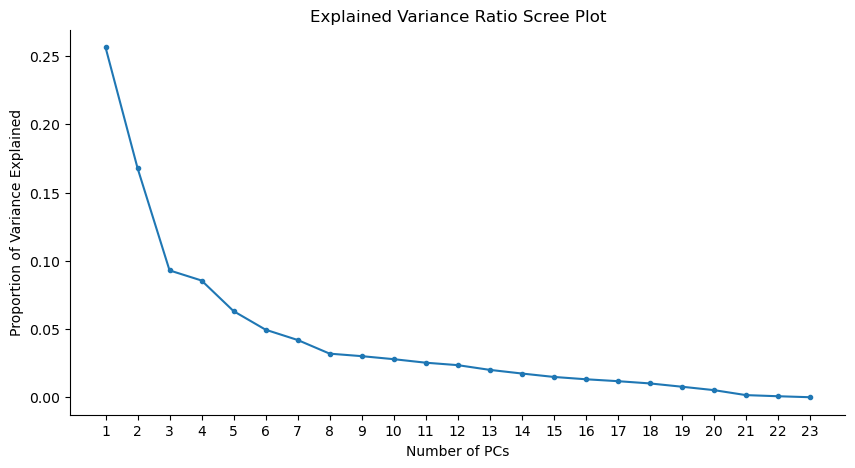

In [246]:
expl_var = model_PCA.explained_variance_ratio_

plt.figure(figsize=(10,5))

plt.plot(range(1,X_remainder_scaled.shape[1]+1),expl_var,marker='.')
plt.title('Explained Variance Ratio Scree Plot')
plt.xlabel('Number of PCs')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(range(1,X_remainder_scaled.shape[1]+1,1))


sns.despine()
plt.show()

The scree plot tells us that the ideal `n_components` for PCA would be 8 (elbow point). Let's use cumulative sums to see how many components we need to cover 80%, 90%, and 95% of variance. We will store the number of components in a list which we can later use to reduce dimension using PCA in a 5-fold GridSearchCV.

In [308]:
cumulative_sum = np.cumsum(expl_var)
components = [ 
    np.argmax(cumulative_sum > 0.85) + 1,
    np.argmax(cumulative_sum > 0.9) + 1,
    np.argmax(cumulative_sum > 0.95) + 1,
    None
]
components

[11, 13, 16, None]

- 11 components explain 85% of varaince in data
- 13 components explain 90% of varaince in data
- 16 components explain 95% of varaince in data

------------

### Logistic Regression

#### Five-fold Cross-Validation

We will use GridSearchCV and Pipeline to perform a 5-fold cross validation to optimize the following hyperparameters for Logistic Regression:

1. C or regularization 
2. solver

In addition, we will also test for 4 different values for PCA dimension reduction n_components (6, 7, 9, None) and two different Scalers (MinMax and Standard).

First let's create the list of pipeline estimators and create the Pipeline using this list.

In [567]:
# estimators for pipeline
estimators = [
    ('scale', StandardScaler()),
    ('reduce_dim', PCA()),
    ('LR', LogisticRegression())
]

# pipeline creation
pipe = Pipeline(estimators)

Next, let's create the `param-grid`:

In [568]:
# param-grid
params = [
    {'LR': [LogisticRegression(max_iter=5000, penalty='l2', random_state=1)],
     'scale': [StandardScaler(), MinMaxScaler()],
     'reduce_dim': [PCA()],
     'LR__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
     'LR__solver': ['liblinear', 'lbfgs'],
     'reduce_dim__n_components': components
    }
]

Now we create `GridSearchCV` object and fit the grid to the remainder data.

In [571]:
time = timer() # start timer
# GridSearchCv object
grid = GridSearchCV(pipe, param_grid=params, cv=5, verbose=2, n_jobs=-1)

# fitting the grid
fittedgrid_logreg = grid.fit(X_remainder, y_remainder)
runtime = timer(time)

Fitting 5 folds for each of 112 candidates, totalling 560 fits
The runtime of your code is: 0:00:39.110456 (h:mm:ss)


Let's find the best params and model.

In [259]:
# best model
best_model_logreg = fittedgrid_logreg.best_estimator_

In [260]:
# Best set of parameters
fittedgrid_logreg.best_params_

{'LR': LogisticRegression(C=1, max_iter=5000, random_state=1),
 'LR__C': 1,
 'LR__solver': 'lbfgs',
 'reduce_dim': PCA(),
 'reduce_dim__n_components': None,
 'scale': StandardScaler()}

In [261]:
# best score
fittedgrid_logreg.best_score_

0.7287287746672787

##### Accuracy Scores

Let's fit the best model to the remainder set and calculate accuracy scores.

In [262]:
time = timer()
# fit best_model
best_model_logreg.fit(X_remainder, y_remainder)
runtime = timer(time)

The runtime of your code is: 0:00:00.364832 (h:mm:ss)


In [263]:
time = timer()
# accuracy scores
print(f'Remainder Set Score: {best_model_logreg.score(X_remainder, y_remainder)}')
print(f'Test Set Score: {best_model_logreg.score(X_test, y_test)}')
runtime = timer(time)

Remainder Set Score: 0.7282698485543827
Test Set Score: 0.7280961504964292
The runtime of your code is: 0:00:00.036660 (h:mm:ss)


##### Precision and Recall

Let's plot the confusion matrix for the Logistic Regression model and get prediction for test set.

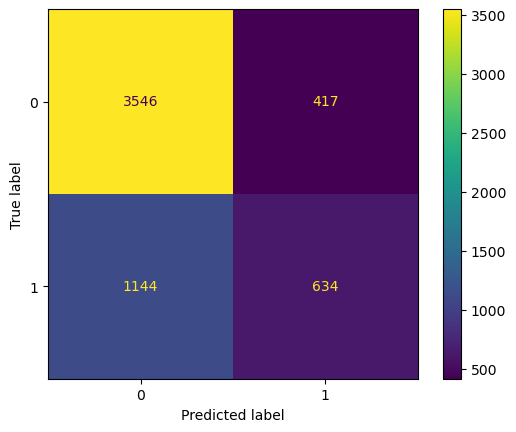

In [264]:
# plotting confusion matrix
plot_confusion_matrix(best_model_logreg, X_test, y_test);

In [265]:
# Get class predictions
y_pred = best_model_logreg.predict(X_test)

Let's get the Classification report.

In [266]:
# Classification score
logreg_report = classification_report(y_test, y_pred)
print(logreg_report)

              precision    recall  f1-score   support

           0       0.76      0.89      0.82      3963
           1       0.60      0.36      0.45      1778

    accuracy                           0.73      5741
   macro avg       0.68      0.63      0.63      5741
weighted avg       0.71      0.73      0.70      5741



Summary of Models:

|      **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                                                   |
|:-------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|-------------------------------------------------------------------------------------------------------|
| Logistic Regression | 0.728                  | 0.728             | 0.36       | 0.60          | 0.45         | StandardScaler(), No dimension reduction,  LR__C=1, LR__solver='lbfgs'                          |


-----------

### Decision Tree

#### Optimize for `max_depth`

Let's use a for loop to optimize for max_depth. We will use the unscaled train and validation sets for this.

In [270]:
# running model for different max depths
depth_list = list(range(1, int(np.sqrt(len(X_train))))) # range of max_depths to be tested
train_scores_dt = []
validation_scores_dt = []

for d in tqdm(depth_list):

    dt = DecisionTreeClassifier(max_depth = d)
    dt.fit(X_train, y_train)
        
    # Evaluate
    train_scores_dt.append(dt.score(X_train, y_train))
    validation_scores_dt.append(dt.score(X_validation, y_validation))



100%|██████████| 130/130 [00:56<00:00,  2.31it/s]


Let's plot the accuracy scores against max_depth to find out the best max_depth value.

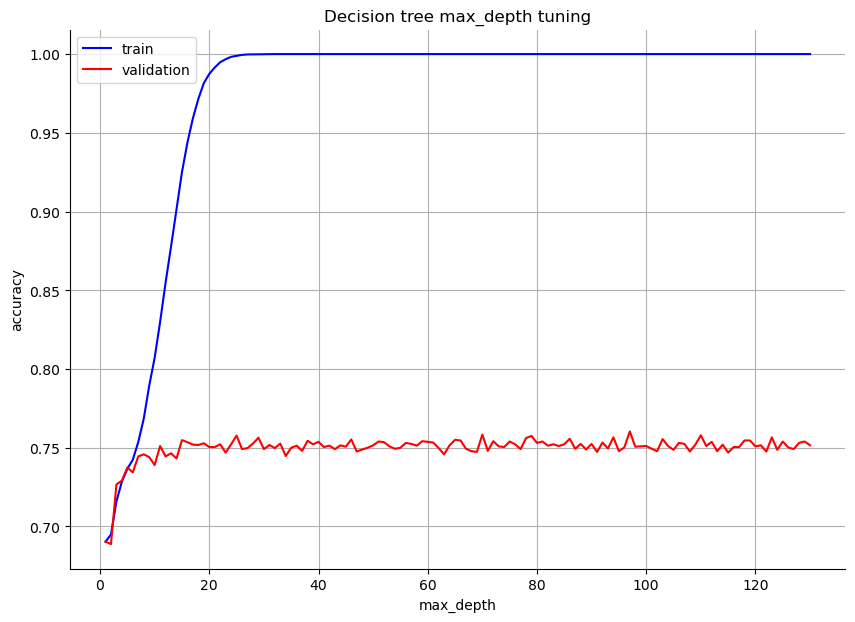

The runtime of your code is: 0:00:00.199166 (h:mm:ss)


In [271]:
time = timer()
plt.figure(figsize=(10, 7))
plt.plot(depth_list, train_scores_dt, c='blue', label='train')
plt.plot(depth_list, validation_scores_dt, c='red', label='validation')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.grid()
plt.title("Decision tree max_depth tuning")
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

From the plot, we can see that the model starts to seriously over fit sometime around a max_depth of 10. Let's make a plot for max_depth from 1-20.

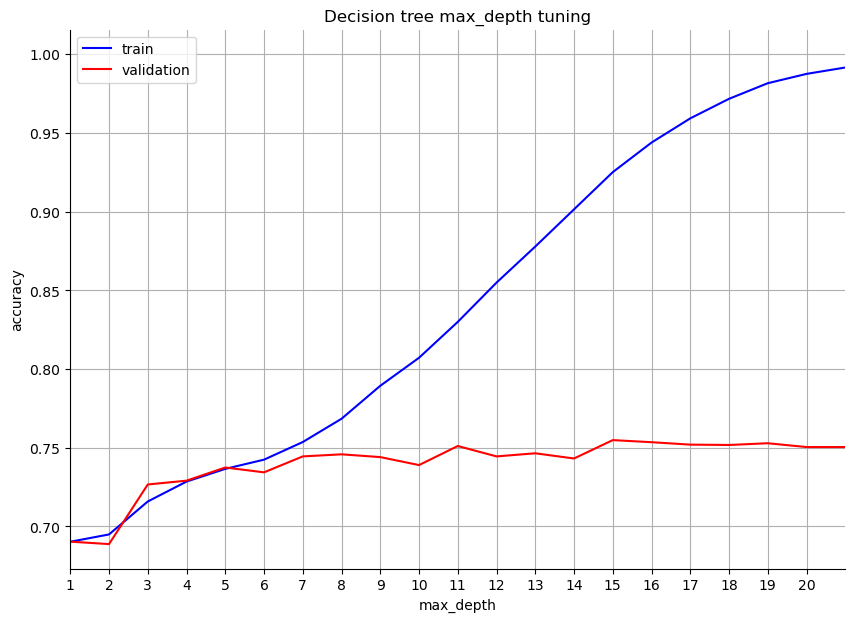

The runtime of your code is: 0:00:00.173083 (h:mm:ss)


In [295]:
time = timer()
plt.figure(figsize=(10, 7))
plt.plot(depth_list, train_scores_dt, c='blue', label='train')
plt.plot(depth_list, validation_scores_dt, c='red', label='validation')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title("Decision tree max_depth tuning")
plt.xlim([1,21])
plt.xticks(range(1,21,1))
plt.grid()
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

In [292]:
# print training and validation scores at different max_depth values
print(f'max_depth values and training accuracy scores:\n \
      {dict(zip(depth_list[0:21], train_scores_dt[0:21]))}')
print(f'max_depth values and validation accuracy scores:\n \
      {dict(zip(depth_list[0:21], validation_scores_dt[0:21]))}')

max_depth values and training accuracy scores:
       {1: 0.6903049982604662, 2: 0.6949437550736403, 3: 0.7158761451930883, 4: 0.7285167575089876, 5: 0.7365765974718775, 6: 0.7424330279485098, 7: 0.7536240287602922, 8: 0.7684100661022846, 9: 0.7893424562217326, 10: 0.8071436854922881, 11: 0.8299315783370057, 12: 0.8548648962078164, 13: 0.8777687579728632, 14: 0.9013684332598864, 15: 0.9250260930070741, 16: 0.943813058100429, 17: 0.9591789400440682, 18: 0.9715876145193089, 19: 0.9815029572074684, 20: 0.9874173721442653, 21: 0.9914762843557926}
max_depth values and validation accuracy scores:
       {1: 0.6903609154929577, 2: 0.6888204225352113, 3: 0.7266725352112676, 4: 0.7290933098591549, 5: 0.737455985915493, 6: 0.734375, 7: 0.7444982394366197, 8: 0.745818661971831, 9: 0.7440580985915493, 10: 0.7389964788732394, 11: 0.751100352112676, 12: 0.7444982394366197, 13: 0.7464788732394366, 14: 0.7431778169014085, 15: 0.7548415492957746, 16: 0.7535211267605634, 17: 0.7519806338028169, 18: 0.75

Based on the plot, we will choose a max_depth of 8. This will maximize test set accuracy while keeping over-fitting low. max_depth of 7 or 9 would also be a good option. Based on the plot, we could also pick 11, 15, or 16 for higher accuracy scores provided we can account for overfitting with other hyperparameters.

In [307]:
# range of ideal values for max_depth
depth_range = [7, 8, 9, 11, 15, 16]

Let's find the accuracy score for a DT Classifier model with max_depth of 8.

In [298]:
time = timer() # start timer

# Instantiate DT model
dt = DecisionTreeClassifier(max_depth=8, random_state=1)

# Fit the model
dt.fit(X_train, y_train)

runtime = timer(time) # stop timer

The runtime of your code is: 0:00:00.205429 (h:mm:ss)


In [299]:
time = timer()
# Accuracy scores
print(f'Train Set Score: {dt.score(X_train, y_train)}')
print(f'Validation Set Score: {dt.score(X_validation, y_validation)}')
runtime = timer(time)

Train Set Score: 0.7684100661022846
Validation Set Score: 0.7462588028169014
The runtime of your code is: 0:00:00.008936 (h:mm:ss)


We can see that the Decision Tree model is performing marginally better than the Logistic Regression model. Let's evaluate the model on the test data.

##### Accuracy Scores

Let's fit the best model to the remainder set and calculate accuracy scores.

In [330]:
# training model on remainder data
time = timer() # start timer

# Instantiate DT model
dt_one = DecisionTreeClassifier(max_depth=8)

# Fit the model
dt_one.fit(X_remainder, y_remainder)

runtime = timer(time) # stop timer

The runtime of your code is: 0:00:00.251499 (h:mm:ss)


In [331]:
time = timer()
# Accuracy scores
print(f'Remainder Set Score: {dt_one.score(X_remainder, y_remainder)}')
print(f'Test Set Score: {dt_one.score(X_test, y_test)}')
runtime = timer(time)

Remainder Set Score: 0.7752179899036256
Test Set Score: 0.75370144574116
The runtime of your code is: 0:00:00.012003 (h:mm:ss)


##### Precision and Recall

Let's plot the confusion matrix for the Decision Tree model and get prediction for test set.

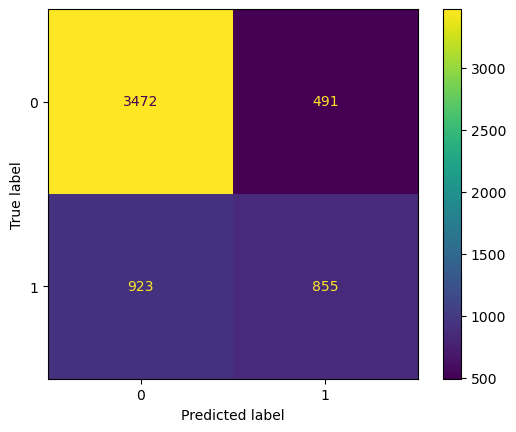

In [332]:
# plotting confusion matrix
plot_confusion_matrix(dt_one, X_test, y_test);

In [333]:
# Get class predictions
y_pred = dt_one.predict(X_test)

Let's get the Classification report.

In [334]:
# Classification score
dt_report_one = classification_report(y_test, y_pred)
print(dt_report_one)

              precision    recall  f1-score   support

           0       0.79      0.88      0.83      3963
           1       0.64      0.48      0.55      1778

    accuracy                           0.75      5741
   macro avg       0.71      0.68      0.69      5741
weighted avg       0.74      0.75      0.74      5741



Summary of Models:

|      **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                                                          |
|:-------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|--------------------------------------------------------------------------------------------------------------|
| Logistic Regression | 0.728                  | 0.728             | 0.36       | 0.60          | 0.45         | StandardScaler(), No dimension reduction,  C=1, solver='lbfgs'                                               |
| Decision Tree 1     | 0.775                  | 0.754             | 0.48       | 0.64          | 0.55         | max_depth=8                                                                                                  |



**Summary**

- Significant increase in Recall and therefore, F1 score.
- Moderate increases in Precision and Accuracy scores.

Let's run a `GridSearchCV` and see if we can improve on these scores.

#### 5-fold Cross Validation

In [319]:
# estimators for pipeline
estimators = [
    ('reduce_dim', PCA()),
    ('DT', DecisionTreeClassifier())
]

# pipeline creation
pipe = Pipeline(estimators)

Next, let's create the `param-grid`:

In [320]:
# param-grid
params = [
    {'DT': [DecisionTreeClassifier()],
     'reduce_dim': [PCA()],
     'DT__max_depth': depth_range,
     'DT__criterion': ['gini', 'entropy', 'log_loss'],
     'reduce_dim__n_components': components
    }
]

Now we create `GridSearchCV` object and fit the grid to the remainder data.

In [321]:
time = timer() # start timer
# GridSearchCv object
grid = GridSearchCV(pipe, param_grid=params, cv=5, verbose=2)

# fitting the grid
fittedgrid_dt = grid.fit(X_remainder, y_remainder)
runtime = timer(time)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END DT=DecisionTreeClassifier(), DT__criterion=gini, DT__max_depth=7, reduce_dim=PCA(), reduce_dim__n_components=11; total time=   0.1s
[CV] END DT=DecisionTreeClassifier(), DT__criterion=gini, DT__max_depth=7, reduce_dim=PCA(), reduce_dim__n_components=11; total time=   0.1s
[CV] END DT=DecisionTreeClassifier(), DT__criterion=gini, DT__max_depth=7, reduce_dim=PCA(), reduce_dim__n_components=11; total time=   0.1s
[CV] END DT=DecisionTreeClassifier(), DT__criterion=gini, DT__max_depth=7, reduce_dim=PCA(), reduce_dim__n_components=11; total time=   0.1s
[CV] END DT=DecisionTreeClassifier(), DT__criterion=gini, DT__max_depth=7, reduce_dim=PCA(), reduce_dim__n_components=11; total time=   0.1s
[CV] END DT=DecisionTreeClassifier(), DT__criterion=gini, DT__max_depth=7, reduce_dim=PCA(), reduce_dim__n_components=13; total time=   0.1s
[CV] END DT=DecisionTreeClassifier(), DT__criterion=gini, DT__max_depth=7, reduce_dim=PCA(),

Let's find the best params and model.

In [322]:
# best model
best_model_dt = fittedgrid_dt.best_estimator_

In [323]:
# Best set of parameters
fittedgrid_dt.best_params_

{'DT': DecisionTreeClassifier(max_depth=11),
 'DT__criterion': 'gini',
 'DT__max_depth': 11,
 'reduce_dim': PCA(n_components=16),
 'reduce_dim__n_components': 16}

In [324]:
# best score
fittedgrid_dt.best_score_

0.7211106011932078

##### Accuracy Scores

Let's fit the best model to the reaminder set and calculate accuracy scores.

In [325]:
time = timer()
# fit best_model
best_model_dt.fit(X_remainder, y_remainder)
runtime = timer(time)

The runtime of your code is: 0:00:00.421478 (h:mm:ss)


In [326]:
time = timer()
# accuracy scores
print(f'Remainder Set Score: {best_model_dt.score(X_remainder, y_remainder)}')
print(f'Test Set Score: {best_model_dt.score(X_test, y_test)}')
runtime = timer(time)

Remainder Set Score: 0.8267553923818265
Test Set Score: 0.7199094234453928
The runtime of your code is: 0:00:00.027008 (h:mm:ss)


##### Precision and Recall

Let's plot the confusion matrix for the Decision Tree model and get prediction for test set.

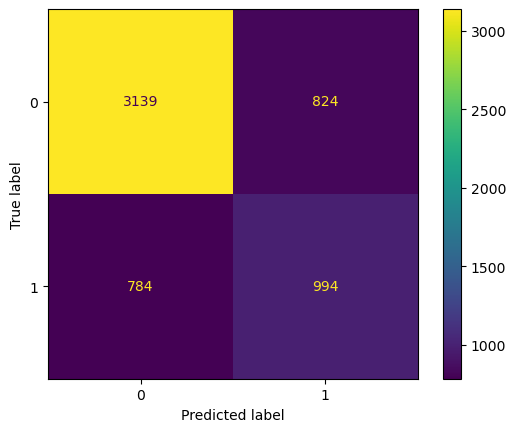

In [327]:
# plotting confusion matrix
plot_confusion_matrix(best_model_dt, X_test, y_test);

In [328]:
# Get class predictions
y_pred = best_model_dt.predict(X_test)

Let's get the Classification report.

In [329]:
# Classification score
dt_report_two = classification_report(y_test, y_pred)
print(dt_report_two)

              precision    recall  f1-score   support

           0       0.80      0.79      0.80      3963
           1       0.55      0.56      0.55      1778

    accuracy                           0.72      5741
   macro avg       0.67      0.68      0.67      5741
weighted avg       0.72      0.72      0.72      5741



Summary of Models:

|       **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                                                          |
|:--------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|--------------------------------------------------------------------------------------------------------------|
| Logistic Regression  | 0.728                  | 0.728             | 0.36       | 0.60          | 0.45         | StandardScaler(), No dimension reduction,  C=1, solver='lbfgs'                                               |
| Decision Tree 1      | 0.775                  | 0.754             | 0.48       | 0.64          | 0.55         | max_depth=8                                                                                                  |
| Decision Tree 2 (CV) | 0.827                  | 0.72              | 0.56       | 0.55          | 0.55         | max_depth=11, criterion='gini', PCA=16                                                                       |



**Summary**
- `GridSearchCV` has selected an overfitting model.
- Lower Test Accuracy and Precision scores.
- Moderately higher Recall score and the same F1 score as Decision Tree 1.

----------

### Random Forest

#### Optimize for `max_depth`

Let's use a for loop to optimize for max_depth. We will use the unscaled train and validation sets for this.

In [338]:
# running model for different max_depth values
depth_list = list(range(1, int(np.sqrt(len(X_train))))) # range of max_depth values to be tested
train_scores_rforest = []
validation_scores_rforest = []

for d in tqdm(depth_list):

    rforest = RandomForestClassifier(max_depth = d)
    rforest.fit(X_train, y_train)
        
    # Evaluate
    train_scores_rforest.append(rforest.score(X_train, y_train))
    validation_scores_rforest.append(rforest.score(X_validation, y_validation))



100%|██████████| 130/130 [11:31<00:00,  5.32s/it]


Let's plot the accuracy scores against max_depth to find out the best max_depth value.

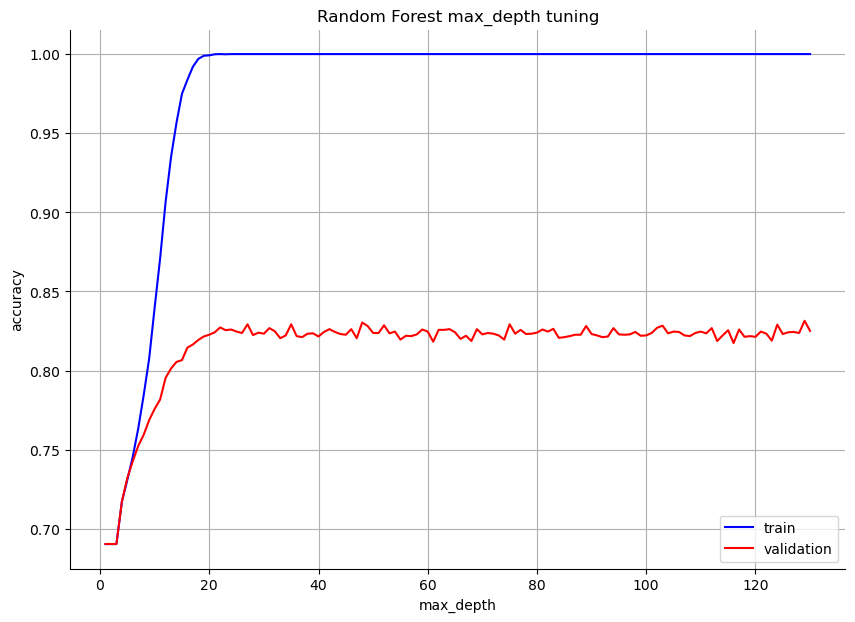

The runtime of your code is: 0:00:00.164483 (h:mm:ss)


In [342]:
time = timer()
plt.figure(figsize=(10, 7))
plt.plot(depth_list, train_scores_rforest, c='blue', label='train')
plt.plot(depth_list, validation_scores_rforest, c='red', label='validation')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.grid()
plt.title("Random Forest max_depth tuning")
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

From the plot, we can see that the model starts to seriously over fit sometime around a max_depth of 20. Let's make a plot for max_depth from 1-20.

In [343]:
# print training and validation scores at different max_depth values
print(f'max_depth values and training accuracy scores:\n \
      {dict(zip(depth_list[0:21], train_scores_rforest[0:21]))}')
print(f'max_depth values and validation accuracy scores:\n \
      {dict(zip(depth_list[0:21], validation_scores_rforest[0:21]))}')

max_depth values and training accuracy scores:
       {1: 0.6903049982604662, 2: 0.6903049982604662, 3: 0.6903049982604662, 4: 0.7170938188565464, 5: 0.730952104835904, 6: 0.745622173257567, 7: 0.7634813869882872, 8: 0.7845877304882292, 9: 0.8077235300939348, 10: 0.8398469210251652, 11: 0.8708106227531022, 12: 0.9064710657543779, 13: 0.9349414356952337, 14: 0.9566856082569871, 15: 0.9748927287486954, 16: 0.9837643511538907, 17: 0.9919981444972747, 18: 0.9969848080714369, 19: 0.9989562797170358, 20: 0.9991882175576945, 21: 0.9998840310796706}
max_depth values and validation accuracy scores:
       {1: 0.6903609154929577, 2: 0.6903609154929577, 3: 0.6903609154929577, 4: 0.7172095070422535, 5: 0.7321742957746479, 6: 0.742737676056338, 7: 0.7524207746478874, 8: 0.7594630281690141, 9: 0.768705985915493, 10: 0.7757482394366197, 11: 0.7816901408450704, 12: 0.7953345070422535, 13: 0.8012764084507042, 14: 0.8054577464788732, 15: 0.8065580985915493, 16: 0.8144806338028169, 17: 0.8164612676056338

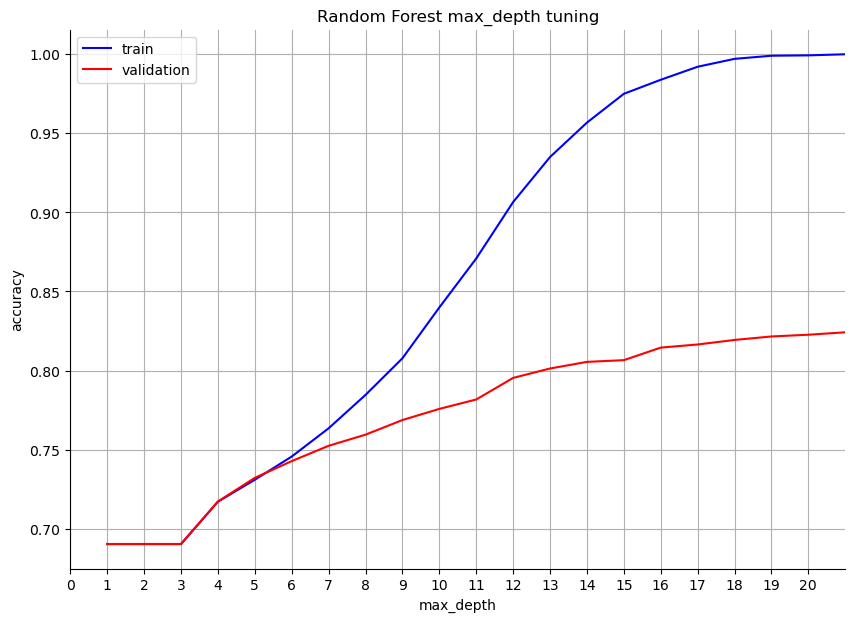

The runtime of your code is: 0:00:00.211185 (h:mm:ss)


In [346]:
time = timer()
plt.figure(figsize=(10, 7))
plt.plot(depth_list, train_scores_rforest, c='blue', label='train')
plt.plot(depth_list, validation_scores_rforest, c='red', label='validation')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title("Random Forest max_depth tuning")
plt.xlim([1,21])
plt.xticks(range(0,21,1))
plt.grid()
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

Based on the plot, the most probable ideal value for `max_depth` is 9. 

`max_depth` < 9 will help control overfitting albeit with lower accuracy scores. 

`max_depth > 9 will give higher accuracy scores but with increased likelihood of overfitting.

In [592]:
depth_range = list(range(8, 16, 1))

#### Optimize for `n_estimators`

Let's use a loop to optimize for `n_estimators`. We will use the unscaled train and validation sets for this.

In [348]:
# running model for different number of estimators
estimators_list = list(range(1, 200, 5)) # range of n_estimators to be tested
train_scores_rforest = []
validation_scores_rforest = []

for e in tqdm(estimators_list):

    rforest = RandomForestClassifier(n_estimators = e)
    rforest.fit(X_train, y_train)
        
    # Evaluate
    train_scores_rforest.append(rforest.score(X_train, y_train))
    validation_scores_rforest.append(rforest.score(X_validation, y_validation))

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [03:38<00:00,  5.47s/it]


Let's plot accuracy against different `n_estimator` values.

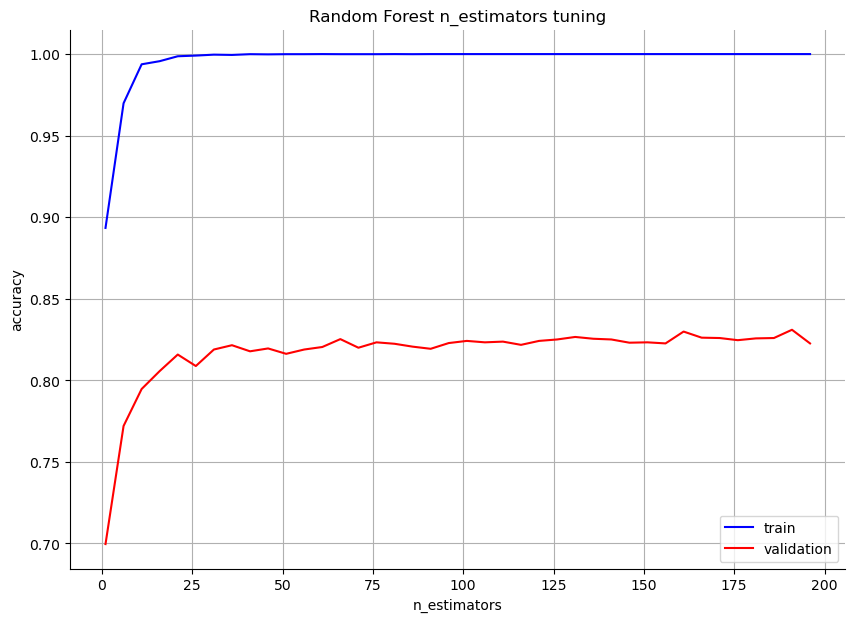

The runtime of your code is: 0:00:00.235334 (h:mm:ss)


In [352]:
time = timer()
plt.figure(figsize=(10, 7))
plt.plot(estimators_list, train_scores_rforest, c='blue', label='train')
plt.plot(estimators_list, validation_scores_rforest, c='red', label='validation')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.grid()
plt.title("Random Forest n_estimators tuning")
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

In [350]:
# print training and validation scores at different n_estimators values
print(f'n_estimators values and training accuracy scores:\n \
      {dict(zip(estimators_list[0:21], train_scores_rforest[0:21]))}')
print(f'n_estimators values and validation accuracy scores:\n \
      {dict(zip(estimators_list[0:21], validation_scores_rforest[0:21]))}')

n_estimators values and training accuracy scores:
       {1: 0.8934245622173258, 6: 0.9698480807143686, 11: 0.993737678302215, 16: 0.9956511654876493, 21: 0.9986663574162125, 26: 0.9990722486373652, 31: 0.9996520932390119, 36: 0.999478139858518, 41: 0.9999420155398353, 46: 0.999826046619506, 51: 0.9999420155398353, 56: 0.9999420155398353, 61: 1.0, 66: 0.9999420155398353, 71: 0.9999420155398353, 76: 0.9999420155398353, 81: 1.0, 86: 0.9999420155398353, 91: 1.0, 96: 1.0, 101: 1.0}
n_estimators values and validation accuracy scores:
       {1: 0.6996038732394366, 6: 0.7720070422535211, 11: 0.7946742957746479, 16: 0.8056778169014085, 21: 0.8158010563380281, 26: 0.8087588028169014, 31: 0.8188820422535211, 36: 0.8215228873239436, 41: 0.8177816901408451, 46: 0.8195422535211268, 51: 0.8162411971830986, 56: 0.8188820422535211, 61: 0.8204225352112676, 66: 0.8252640845070423, 71: 0.8199823943661971, 76: 0.8232834507042254, 81: 0.8224031690140845, 86: 0.8206426056338029, 91: 0.8193221830985915, 96:

The model has serious overfitting issues at all `n_estimators` values however the accuracy gains taper off at around 21 estimators with notable spikes at 36, 66, 161, and 191. Let's make a plot for `n_estimators` from 0-65.

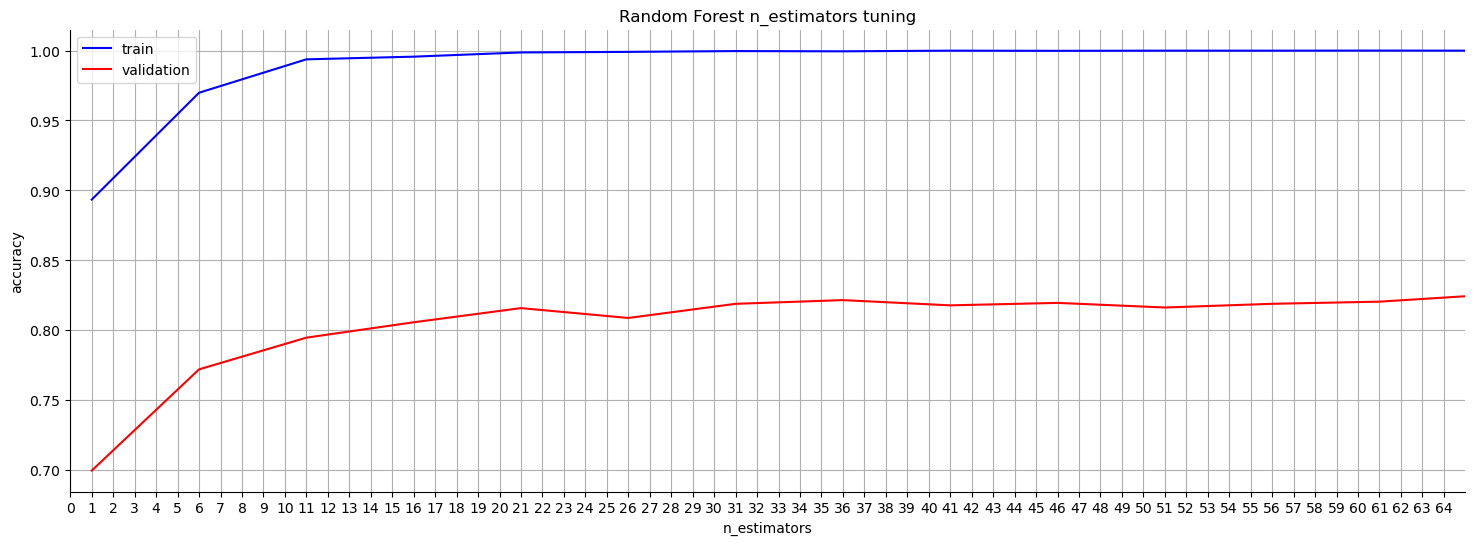

The runtime of your code is: 0:00:00.572210 (h:mm:ss)


In [370]:
time = timer()
plt.figure(figsize=(18, 6))
plt.plot(estimators_list, train_scores_rforest, c='blue', label='train')
plt.plot(estimators_list, validation_scores_rforest, c='red', label='validation')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.title("Random Forest n_estimators tuning")
plt.xlim([0,65])
plt.xticks(range(0,65,1))
plt.grid()
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

In [371]:
# create list of prospective estimator values for cross-validation
estimators_range = list(range(1,22,1))
estimators_outliers_list = [36, 66, 161, 191]
estimators_range.extend(estimators_outliers_list)
print(estimators_range)



[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 36, 66, 161, 191]


#### Optimize for `max_leaf_nodes`

Let's use a lopp to optimize for `max_leaf_nodes` value using unscaled train and validation data. 

In [577]:
# running model for different number of max_leaf_nodes
nodes_list = list(range(2, 1000, 10)) # range of max_leaf_nodes to be tested
train_scores_rforest = []
validation_scores_rforest = []

for n in tqdm(nodes_list):

    rforest = RandomForestClassifier(max_leaf_nodes= n, n_jobs=-1)
    rforest.fit(X_train, y_train)
        
    # Evaluate
    train_scores_rforest.append(rforest.score(X_train, y_train))
    validation_scores_rforest.append(rforest.score(X_validation, y_validation))

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [02:12<00:00,  1.32s/it]


Let's plot accuracy against different `max_leaf_nodes` values.

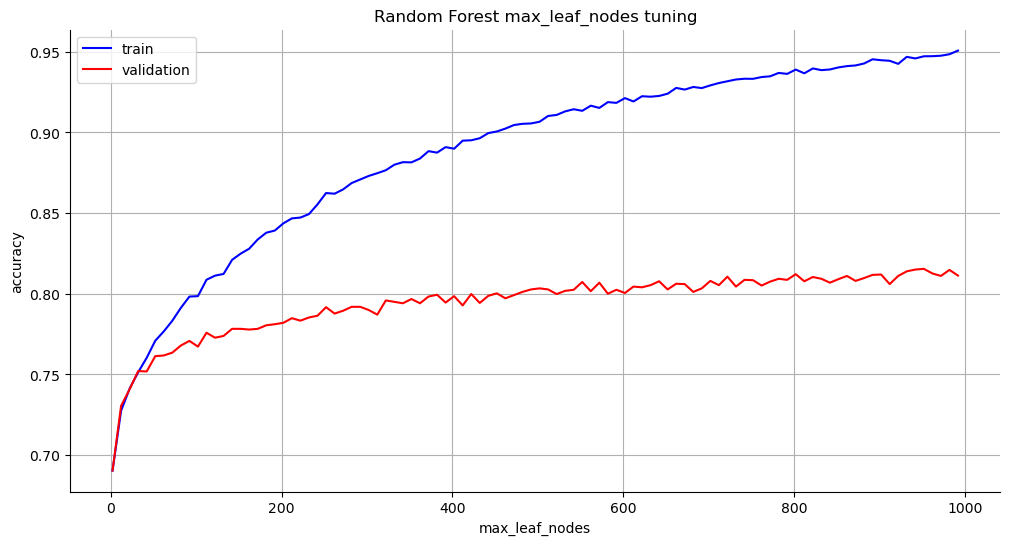

The runtime of your code is: 0:00:00.339258 (h:mm:ss)


In [579]:
time = timer()
plt.figure(figsize=(12, 6))
plt.plot(nodes_list, train_scores_rforest, c='blue', label='train')
plt.plot(nodes_list, validation_scores_rforest, c='red', label='validation')
plt.xlabel('max_leaf_nodes')
plt.ylabel('accuracy')
plt.grid()
plt.title("Random Forest max_leaf_nodes tuning")
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

Ideal value for `max_leaf_nodes` probably lies between 0 and 250.

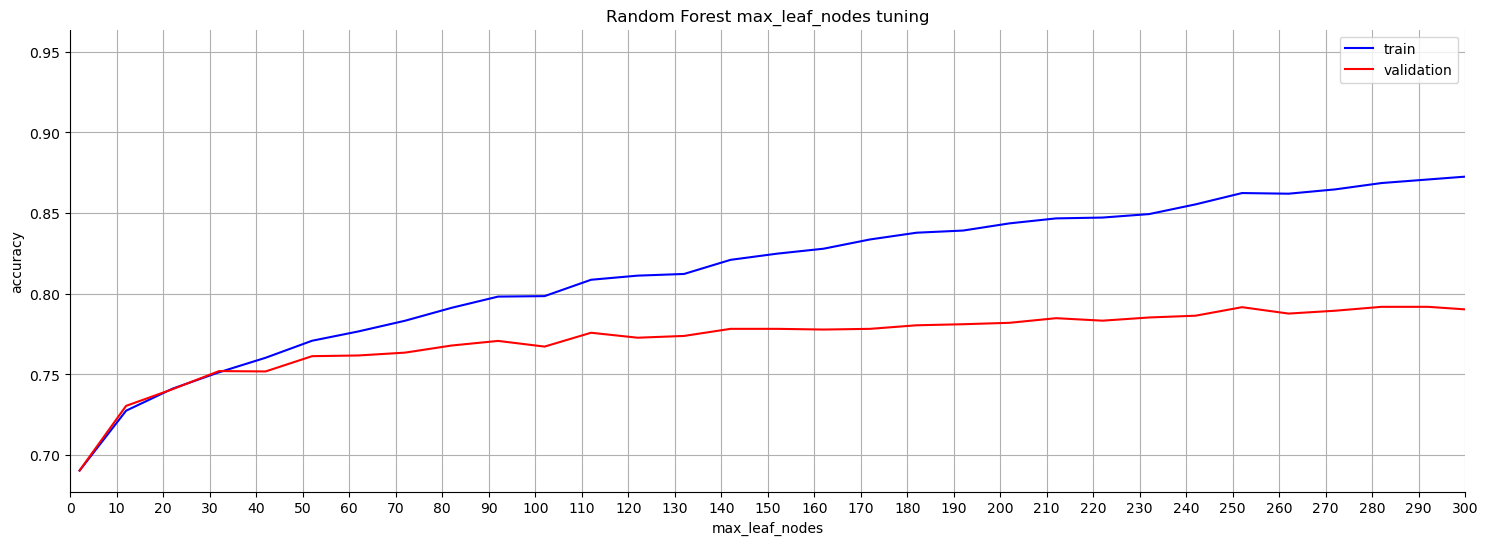

The runtime of your code is: 0:00:00.421486 (h:mm:ss)


In [580]:
time = timer()
plt.figure(figsize=(18, 6))
plt.plot(nodes_list, train_scores_rforest, c='blue', label='train')
plt.plot(nodes_list, validation_scores_rforest, c='red', label='validation')
plt.xlabel('max_leaf_nodes')
plt.ylabel('accuracy')
plt.title("Random Forest max_leaf_nodes tuning")
plt.xlim([0,300])
plt.xticks(range(0,301,10))
plt.grid()
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

Let's take acloser look at `max_leaf_nodes` values between 40 and 190. These should give us the best accuracy scores while keeping overfitting under control (p<0.05). 

In [581]:
# running model for different number of max_leaf_nodes
nodes_list = list(range(40, 191, 1)) # range of max_leaf_nodes to be tested
train_scores_rforest = []
validation_scores_rforest = []

for n in tqdm(nodes_list):

    rforest = RandomForestClassifier(max_leaf_nodes= n, n_jobs=-1)
    rforest.fit(X_train, y_train)
        
    # Evaluate
    train_scores_rforest.append(rforest.score(X_train, y_train))
    validation_scores_rforest.append(rforest.score(X_validation, y_validation))

100%|██████████| 151/151 [02:57<00:00,  1.18s/it]


Let's plot accuracy against different `max_leaf_nodes` values.

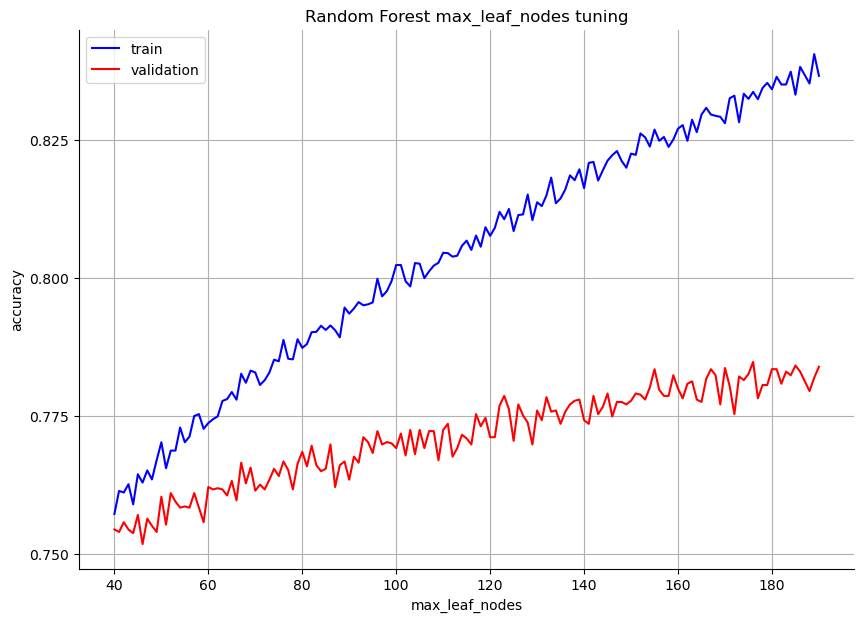

The runtime of your code is: 0:00:00.271820 (h:mm:ss)


In [582]:
time = timer()
plt.figure(figsize=(10, 7))
plt.plot(nodes_list, train_scores_rforest, c='blue', label='train')
plt.plot(nodes_list, validation_scores_rforest, c='red', label='validation')
plt.xlabel('max_leaf_nodes')
plt.ylabel('accuracy')
plt.grid()
plt.yticks(np.arange(0.75, 0.85, 0.025))
plt.title("Random Forest max_leaf_nodes tuning")
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

Let's run a loop to create a dictionary of all the `max_leaf_nodes` values for which the difference between train scores and validation scores is 5% or less (i.e. overfitting is under control). We will then plot the resulting values to get a closer look and pick the top 5 for use in `GridSearchCV`. 

In [584]:
train_scores_rf_optimal = {} # dict to store hyperparam values as keys and training accuracy scores as values
validation_scores_rf_optimal = {} # dict to store hyperparam values as keys and validation accuracy scores as values
for i in range(len(nodes_list)): 
    if (train_scores_rforest[i] - validation_scores_rforest[i]) <= .05:
        train_scores_rf_optimal[nodes_list[i]] = train_scores_rforest[i]
        validation_scores_rf_optimal[nodes_list[i]] = validation_scores_rforest[i]
    else:
        continue


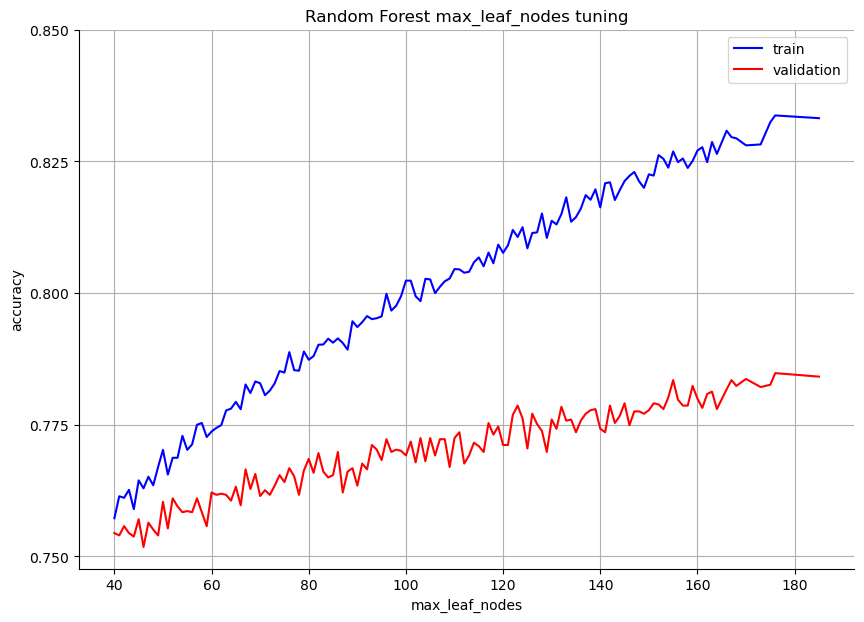

The runtime of your code is: 0:00:00.217503 (h:mm:ss)


In [587]:
time = timer()
plt.figure(figsize=(10, 7))
plt.plot(list(train_scores_rf_optimal.keys()), list(train_scores_rf_optimal.values()), c='blue', label='train')
plt.plot(list(validation_scores_rf_optimal.keys()), list(validation_scores_rf_optimal.values()), c='red', label='validation')
plt.xlabel('max_leaf_nodes')
plt.ylabel('accuracy')
plt.grid()
plt.yticks(np.arange(0.75, 0.851, 0.025))
plt.title("Random Forest max_leaf_nodes tuning")
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

In [589]:
# get top 5 hyper param values based on validation accuracy score
nodes_range = sorted(validation_scores_rf_optimal, key=validation_scores_rf_optimal.get, reverse=True)[:5]
nodes_range

[176, 185, 170, 155, 167]

#### 5-fold Cross Validation

We will optimize for `max_depth`, `n_estimators`, and `criterion`. I will also add PCA() optimization to the mix.

In [593]:
# estimators for pipeline
estimators = [
    ('reduce_dim', PCA()),
    ('RF', RandomForestClassifier())
]

# pipeline creation
pipe = Pipeline(estimators)

Next, let's create the `param-grid`:

In [595]:
# param-grid
params = [
    {'RF': [RandomForestClassifier()],
     'reduce_dim': [PCA()],
     'RF__max_depth': depth_range,
     'RF__n_estimators': estimators_range,
     'RF__max_leaf_nodes': nodes_range,
     'RF__criterion': ['gini', 'entropy', 'log_loss'],
     'reduce_dim__n_components': components
    }
]

Now we create `GridSearchCV` object and fit the grid to the remainder data.

In [596]:
time = timer() # start timer
# GridSearchCv object
grid = GridSearchCV(pipe, param_grid=params, cv=5, verbose = 2, n_jobs=-1)

# fitting the grid
fittedgrid_rf = grid.fit(X_remainder, y_remainder)
runtime = timer(time)

The runtime of your code is: 3:56:36.411552 (h:mm:ss)


I will save fittedgrid_rf as a .pkl file to save future computation.

In [597]:
# saving file as .pkl
joblib.dump(fittedgrid_rf, 'randomForest_gridSearch.pkl')

['randomForest_gridSearch.pkl']

Let's find the best params and model.

In [598]:
# load .pkl file
fitgrid_rf = joblib.load('randomForest_gridSearch.pkl')

In [599]:
# best model
best_model_rf = fitgrid_rf.best_estimator_

In [600]:
# Best set of parameters
fitgrid_rf.best_params_

{'RF': RandomForestClassifier(max_depth=14, max_leaf_nodes=185, n_estimators=161),
 'RF__criterion': 'gini',
 'RF__max_depth': 14,
 'RF__max_leaf_nodes': 185,
 'RF__n_estimators': 161,
 'reduce_dim': PCA(),
 'reduce_dim__n_components': None}

In [601]:
# best score
fitgrid_rf.best_score_

0.7596603946764571

##### Accuracy Scores

Let's fit the best model to the reaminder set and calculate accuracy scores.

In [602]:
time = timer()
# fit best_model
best_model_rf.fit(X_remainder, y_remainder)
runtime = timer(time)

The runtime of your code is: 0:00:08.260411 (h:mm:ss)


In [603]:
time = timer()
# accuracy scores
print(f'Remainder Set Score: {best_model_rf.score(X_remainder, y_remainder)}')
print(f'Test Set Score: {best_model_rf.score(X_test, y_test)}')
runtime = timer(time)

Remainder Set Score: 0.8174850849013309
Test Set Score: 0.7594495732450792
The runtime of your code is: 0:00:00.448541 (h:mm:ss)


##### Precision and Recall

Let's plot the confusion matrix for the Random Forest model and get prediction for test set.

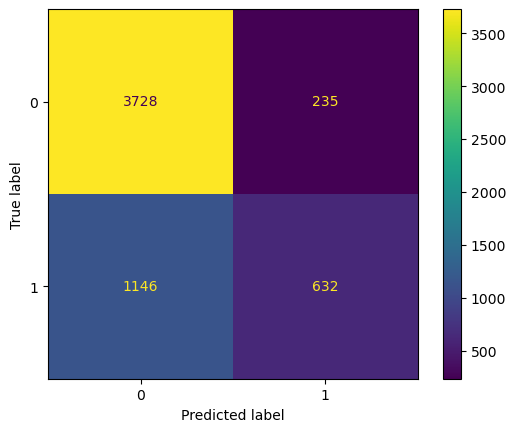

In [604]:
# plotting confusion matrix
plot_confusion_matrix(best_model_rf, X_test, y_test);

In [605]:
# Get class predictions
y_pred = best_model_rf.predict(X_test)

Let's get the Classification report.

In [606]:
# Classification score
rForest_report_one = classification_report(y_test, y_pred)
print(rForest_report_one)

              precision    recall  f1-score   support

           0       0.76      0.94      0.84      3963
           1       0.73      0.36      0.48      1778

    accuracy                           0.76      5741
   macro avg       0.75      0.65      0.66      5741
weighted avg       0.75      0.76      0.73      5741



Summary of Models:

|       **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                                                          |
|:--------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|--------------------------------------------------------------------------------------------------------------|
| Logistic Regression  | 0.728                  | 0.728             | 0.36       | 0.60          | 0.45         | StandardScaler(), No dimension reduction,  C=1, solver='lbfgs'                                               |
| Decision Tree 1      | 0.775                  | 0.754             | 0.48       | 0.64          | 0.55         | max_depth=8                                                                                                  |
| Decision Tree 2 (CV) | 0.827                  | 0.72              | 0.56       | 0.55          | 0.55         | max_depth=11, criterion='gini', PCA=16                                                                       |
| Random Forest 1 (CV) | 0.817                  | 0.759             | 0.36       | 0.73          | 0.48         | max_depth=14, criterion='gini', n_estimators=161, max_leaf_nodes=185, PCA=none                               |




**Summary**
- Slightly overfitting.

- Similar accuracy to Decision Tree 1.
- Significantly increased Precision score.
- Drastically lower Recall.
- Moderately lower F1 score.


#### Random Forest 2

We are looking to increase accuracy and recall scores with this test model. I will try to accomplish that by changing `max_leaf_nodes` value.

In [607]:
# instantiate the model
rforest_two = RandomForestClassifier(max_depth=14, n_estimators=161, max_leaf_nodes=176)

# fit the model
rforest_two.fit(X_remainder, y_remainder)

RandomForestClassifier(max_depth=14, max_leaf_nodes=176, n_estimators=161)

##### Accuracy Scores

In [608]:
time = timer()
# accuracy scores
print(f'Remainder Set Score: {rforest_two.score(X_remainder, y_remainder)}')
print(f'Test Set Score: {rforest_two.score(X_test, y_test)}')
runtime = timer(time)

Remainder Set Score: 0.8256539697108766
Test Set Score: 0.7730360564361609
The runtime of your code is: 0:00:00.412164 (h:mm:ss)


##### Precision and Recall

Let's plot the confusion matrix for the Random Forest model and get prediction for test set.

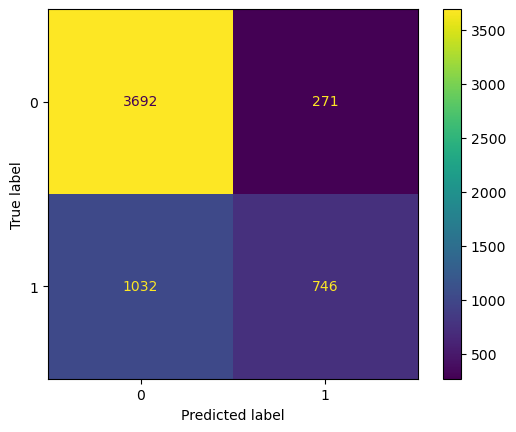

In [609]:
# plotting confusion matrix
plot_confusion_matrix(rforest_two, X_test, y_test);

In [610]:
# Get class predictions
y_pred = rforest_two.predict(X_test)

Let's get the Classification report.

In [611]:
# Classification score
rforest_report_two = classification_report(y_test, y_pred)
print(rforest_report_two)

              precision    recall  f1-score   support

           0       0.78      0.93      0.85      3963
           1       0.73      0.42      0.53      1778

    accuracy                           0.77      5741
   macro avg       0.76      0.68      0.69      5741
weighted avg       0.77      0.77      0.75      5741



Summary of Models:

|       **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                                                          |
|:--------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|--------------------------------------------------------------------------------------------------------------|
| Logistic Regression  | 0.728                  | 0.728             | 0.36       | 0.60          | 0.45         | StandardScaler(), No dimension reduction,  C=1, solver='lbfgs'                                               |
| Decision Tree 1      | 0.775                  | 0.754             | 0.48       | 0.64          | 0.55         | max_depth=8                                                                                                  |
| Decision Tree 2 (CV) | 0.827                  | 0.72              | 0.56       | 0.55          | 0.55         | max_depth=11, criterion='gini', PCA=16                                                                       |
| Random Forest 1 (CV) | 0.817                  | 0.759             | 0.36       | 0.73          | 0.48         | max_depth=14, criterion='gini', n_estimators=161, max_leaf_nodes=185, PCA=none                               |
| Random Forest 2      | 0.826                  | 0.773             | 0.42       | 0.73          | 0.53         | max_depth=14, max_leaf_nodes=176, n_estimators=161, criterion='gini'                                         |


**Summary**
- No overfitting issue.

- Slight increase to Accuracy score yielding best accuracy yet.
- Moderate increase to Recall and F1 score.
- Unchanged Precision score from Random Forest 1.

#### Random Forest 3

The Recall score is still underwhelming. I will try to increase that at the risk of introducing some overfitting. 

1. max_depth=15, n_estimators=191, max_leaf_nodes=155
2. max_depth=15, n_estimators=300, max_leaf_nodes=176
3. max_depth=15, n_estimators=161, max_leaf_nodes=200

In [793]:
# instantiate the model
rforest_three = RandomForestClassifier(max_depth=15, n_estimators=191, max_leaf_nodes=200, n_jobs=-1)

# fit the model
rforest_three.fit(X_remainder, y_remainder)

RandomForestClassifier(max_depth=15, max_leaf_nodes=200, n_estimators=191,
                       n_jobs=-1)

##### Accuracy Scores

In [794]:
time = timer()
# accuracy scores
print(f'Remainder Set Score: {rforest_three.score(X_remainder, y_remainder)}')
print(f'Test Set Score: {rforest_three.score(X_test, y_test)}')
runtime = timer(time)

Remainder Set Score: 0.8322625057365765
Test Set Score: 0.7747779132555304
The runtime of your code is: 0:00:00.380612 (h:mm:ss)


##### Precision and Recall

Let's plot the confusion matrix for the Random Forest model and get prediction for test set.

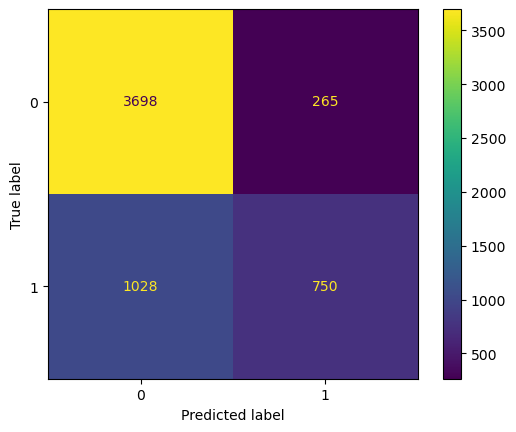

In [795]:
# plotting confusion matrix
plot_confusion_matrix(rforest_three, X_test, y_test);

In [796]:
# Get class predictions
y_pred = rforest_three.predict(X_test)

Let's get the Classification report.

In [797]:
# Classification score
rforest_report_three = classification_report(y_test, y_pred)
print(rforest_report_three)

              precision    recall  f1-score   support

           0       0.78      0.93      0.85      3963
           1       0.74      0.42      0.54      1778

    accuracy                           0.77      5741
   macro avg       0.76      0.68      0.69      5741
weighted avg       0.77      0.77      0.75      5741



Summary of Models:

|       **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                                                          |
|:--------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|--------------------------------------------------------------------------------------------------------------|
| Logistic Regression  | 0.728                  | 0.728             | 0.36       | 0.60          | 0.45         | StandardScaler(), No dimension reduction,  C=1, solver='lbfgs'                                               |
| Decision Tree 1      | 0.775                  | 0.754             | 0.48       | 0.64          | 0.55         | max_depth=8                                                                                                  |
| Decision Tree 2 (CV) | 0.827                  | 0.72              | 0.56       | 0.55          | 0.55         | max_depth=11, criterion='gini', PCA=16                                                                       |
| Random Forest 1 (CV) | 0.817                  | 0.759             | 0.36       | 0.73          | 0.48         | max_depth=14, criterion='gini', n_estimators=161, max_leaf_nodes=185, PCA=none                               |
| Random Forest 2      | 0.826                  | 0.773             | 0.42       | 0.73          | 0.53         | max_depth=14, max_leaf_nodes=176, n_estimators=161, criterion='gini'                                         |
| Random Forest 3      | 0.832                  | 0.775             | 0.42       | 0.74          | 0.54         | max_depth=15, criterion='gini', n_estimators=191, max_leaf_nodes=200                                         |



**Summary** 
- Negligible changes in all evaluation metrics. 

We seem to have reached the limit of what Random Forest models can offer.

------

### XGBoost 

XGBoost is an example of gradient tree boosting algorithm, which trains an ensemble of decision trees. Each tree is trained to predict the prediction error of all previous trees. 

#### Optimize for `n_estimators`

Let's use a loop to optimize for `n_estimators`. We will once again use the unscaled train and validation sets for this.

Range: [10, $\infty$]

_Note: Decreasing this hyperparameter reduces likelihood of overfitting._

In [806]:
# running model for different n_estimators
estimators_list = list(range(5, 250, 5)) # range of n_estimators to be tested
train_scores_xgb = []
validation_scores_xgb = []

for e in tqdm(estimators_list):

    xgb = XGBClassifier(n_estimators = e, verbosity = 0, n_jobs=-1) # verbosity set to 0 to filter out warnings
    xgb.fit(X_train, y_train)
        
    # Evaluate
    train_scores_xgb.append(xgb.score(X_train, y_train))
    validation_scores_xgb.append(xgb.score(X_validation, y_validation))

100%|██████████| 49/49 [01:37<00:00,  2.00s/it]


Let's plot the accuracy scores against `n_estimators` to find the ideal value.

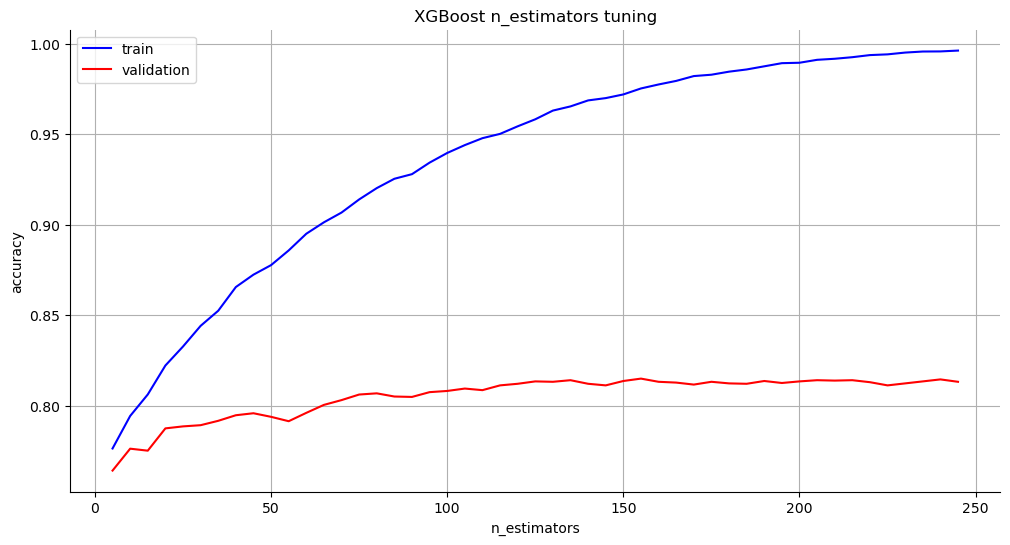

The runtime of your code is: 0:00:00.131591 (h:mm:ss)


In [807]:
time = timer()
plt.figure(figsize=(12, 6))
plt.plot(estimators_list, train_scores_xgb, c='blue', label='train')
plt.plot(estimators_list, validation_scores_xgb, c='red', label='validation')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.grid()
plt.title("XGBoost n_estimators tuning")
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

From the plot, we can see that test accuracy gains slow down after 120 estimators whereas the training accuracy keeps increasing. This leads to overfitting. It would be prudent to select a value for n_estimators between 10 and 120.

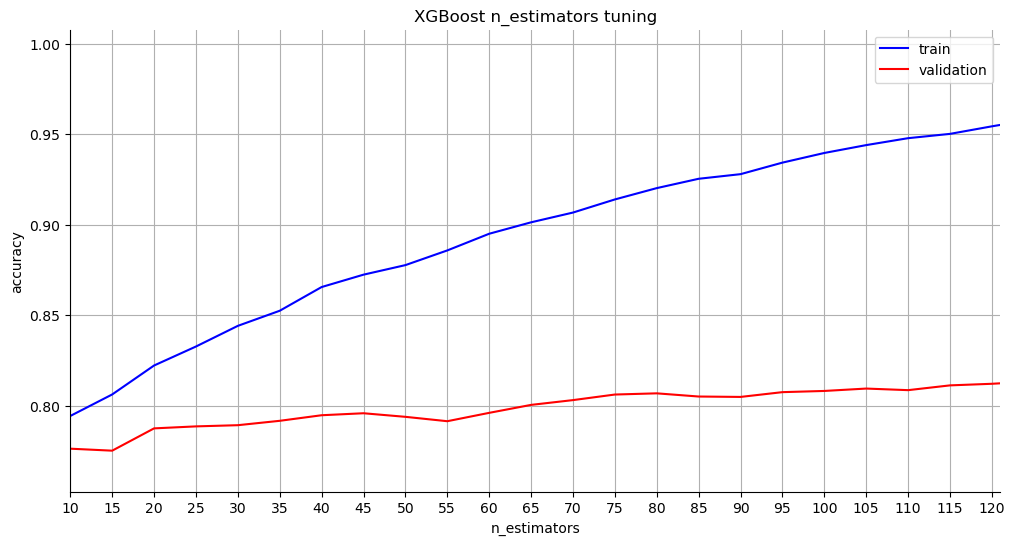

The runtime of your code is: 0:00:00.341859 (h:mm:ss)


In [808]:
time = timer()
plt.figure(figsize=(12, 6))
plt.plot(estimators_list, train_scores_xgb, c='blue', label='train')
plt.plot(estimators_list, validation_scores_xgb, c='red', label='validation')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.title("XGBoost n_estimators tuning")
plt.xlim([10,121])
plt.xticks(range(10,121,5))
plt.grid()
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

I will select `n_estimators` values between 30 and 45 for cross-validation testing. I will also add some larger values to try and achieve higher accuracy scores.

In [874]:
estimators_range = list(range(35,46,5)) 
estimators_range.extend([140, 155])
estimators_range

[35, 40, 45, 140, 155]

#### Optimize for `max_depth`

Let's use a for loop to optimize for max_depth. We will use the unscaled train and validation sets for this.

Range: [0, $\infty$]

_Note: Decreasing this hyperparameter reduces likelihood of overfitting._

In [810]:
# running model for different max depths
depth_list = list(range(1, 60)) # range of max_depths to be tested
train_scores_xgb = []
validation_scores_xgb = []

for d in tqdm(depth_list):

    xgb = XGBClassifier(max_depth = d, verbosity = 0, n_jobs=-1)
    xgb.fit(X_train, y_train)
        
    # Evaluate
    train_scores_xgb.append(xgb.score(X_train, y_train))
    validation_scores_xgb.append(xgb.score(X_validation, y_validation))



100%|██████████| 59/59 [05:14<00:00,  5.33s/it]


Let's plot the accuracy scores against max_depth to find out the best max_depth value.

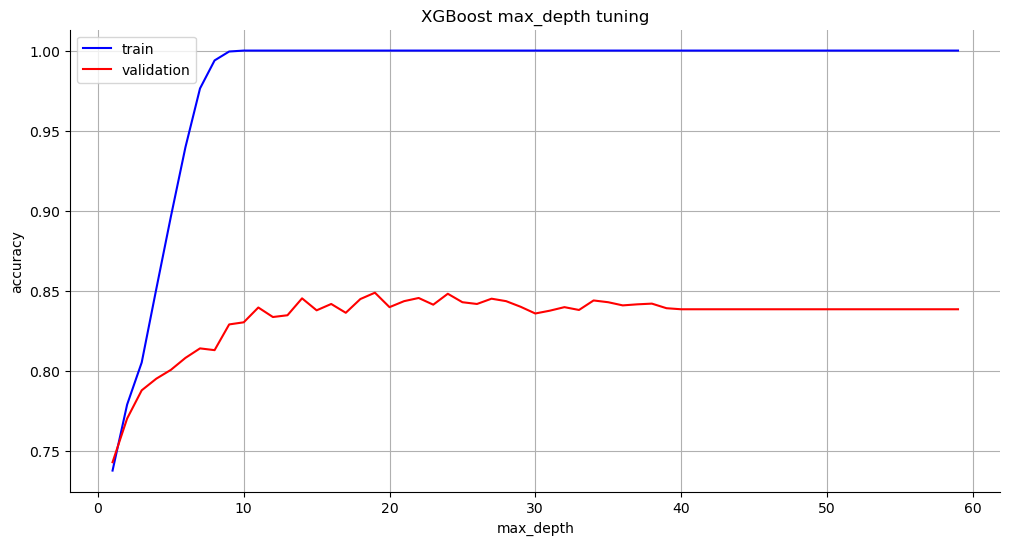

The runtime of your code is: 0:00:00.151988 (h:mm:ss)


In [812]:
time = timer()
plt.figure(figsize=(12, 6))
plt.plot(depth_list, train_scores_xgb, c='blue', label='train')
plt.plot(depth_list, validation_scores_xgb, c='red', label='validation')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.grid()
plt.title("XGBoost max_depth tuning")
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

From the plot, we can see that the model starts to seriously over fit sometime before a max_depth of 10. Let's make a plot for max_depth from 1-10.

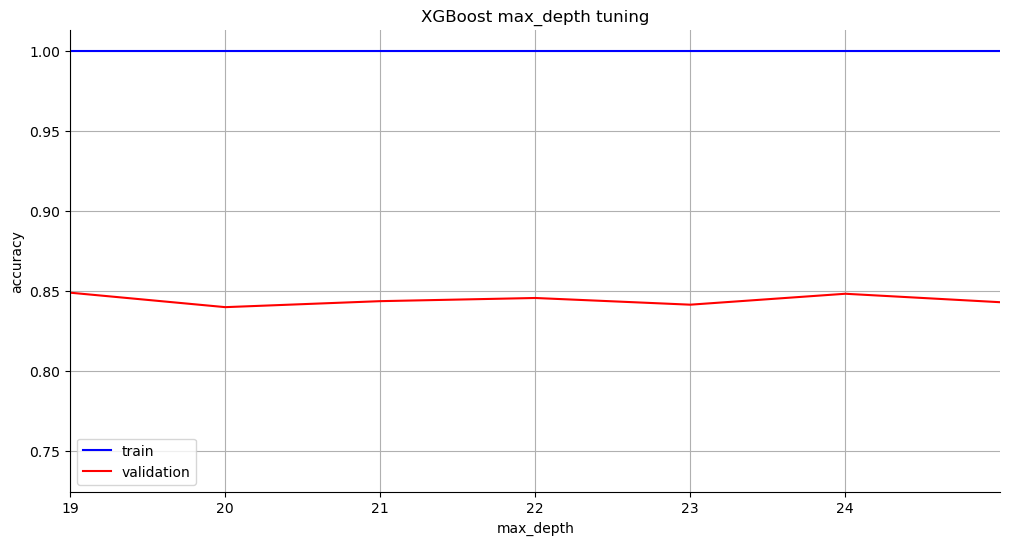

The runtime of your code is: 0:00:00.128239 (h:mm:ss)


In [814]:
time = timer()
plt.figure(figsize=(12, 6))
plt.plot(depth_list, train_scores_xgb, c='blue', label='train')
plt.plot(depth_list, validation_scores_xgb, c='red', label='validation')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title("XGBoost max_depth tuning")
plt.xlim([1,11])
plt.xticks(range(0,11,1))
plt.grid()
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

Based on the plot, ideal values for `max_depth` could lie between 3 and 6. I will add some peaks from the plot to try and increase accuracy scores.

In [873]:
depths_range = [5, 6, 19]
depths_range

[5, 6, 19]

#### Optimize for `learning_rate`

Let's use a for loop to optimize for learning_rate. We will also use the unscaled train and validation sets for this.

Range: [0, 1]

_Note: Decreasing this hyperparameter reduces likelihood of overfitting._

In [816]:
# running model for different learning_rate
learning_list = list(np.arange(0, 1, 0.01)) # range of learning_rate to be tested
train_scores_xgb = []
validation_scores_xgb = []

for l in tqdm(learning_list):

    xgb = XGBClassifier(learning_rate = l, verbosity = 0, n_jobs=-1)
    xgb.fit(X_train, y_train)
        
    # Evaluate
    train_scores_xgb.append(xgb.score(X_train, y_train))
    validation_scores_xgb.append(xgb.score(X_validation, y_validation))



100%|██████████| 100/100 [03:11<00:00,  1.91s/it]


Let's plot the accuracy scores against max_depth to find out the best max_depth value.

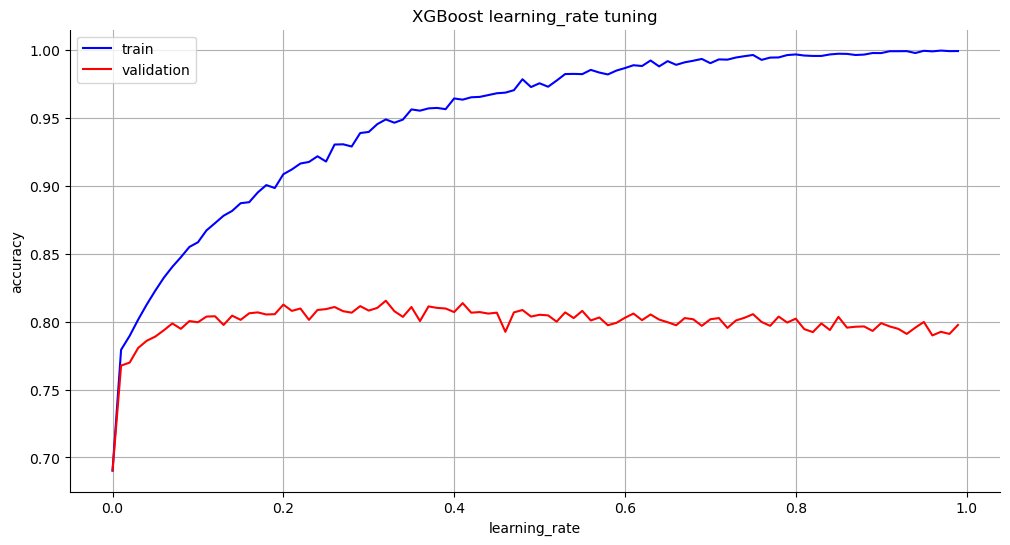

The runtime of your code is: 0:00:00.139997 (h:mm:ss)


In [817]:
time = timer()
plt.figure(figsize=(12, 6))
plt.plot(learning_list, train_scores_xgb, c='blue', label='train')
plt.plot(learning_list, validation_scores_xgb, c='red', label='validation')
plt.xlabel('learning_rate')
plt.ylabel('accuracy')
plt.title("XGBoost learning_rate tuning")
plt.grid()
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

Validation accuracy starts to drop for `learning_rate` values beyond 0.41. Let's take a closer look.

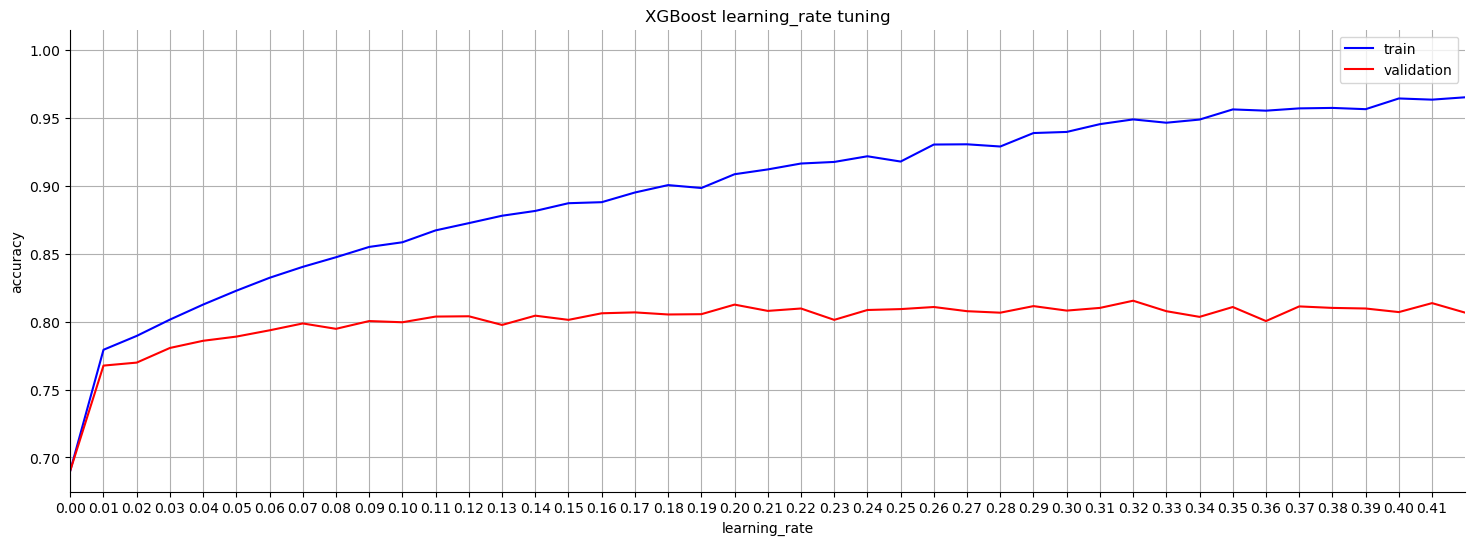

The runtime of your code is: 0:00:00.405906 (h:mm:ss)


In [820]:
time = timer()
plt.figure(figsize=(18, 6))
plt.plot(learning_list, train_scores_xgb, c='blue', label='train')
plt.plot(learning_list, validation_scores_xgb, c='red', label='validation')
plt.xlabel('learning_rate')
plt.ylabel('accuracy')
plt.title("XGBoost learning_rate tuning")
plt.xlim([0,0.42])
plt.xticks(np.arange(0,0.42,0.01))
plt.grid()
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

Based on the plot, ideal values for `learning_rate` could lie between 0.07 and 0.09. Once again, I will add a few peak points from the plot to try and get better accuracy scores with cross-validation.

In [872]:
learning_range = [0.07, 0.09]
learning_range.extend([0.2])
learning_range

[0.07, 0.09, 0.2]

#### Optimize for `gamma`

`gamma` specifies the minimum loss reduction required to make node split. Let's use a for loop to optimize for `gamma`. We will also use the unscaled train and validation sets for this.

Range: [0, $\infty$]

_Note: Increasing this hyperparameter makes the model more conservative and reduces overfitting._

In [830]:
# running model for different gamma
gamma_list = list(np.arange(0, 16.1, 0.1)) # range of gamma to be tested
train_scores_xgb = []
validation_scores_xgb = []

for g in tqdm(gamma_list):

    xgb = XGBClassifier(gamma = g, verbosity = 0, n_jobs=-1)
    xgb.fit(X_train, y_train)
        
    # Evaluate
    train_scores_xgb.append(xgb.score(X_train, y_train))
    validation_scores_xgb.append(xgb.score(X_validation, y_validation))



100%|██████████| 161/161 [04:34<00:00,  1.70s/it]


Let's plot the accuracy scores against `gamma` to find out the best `gamma` value.

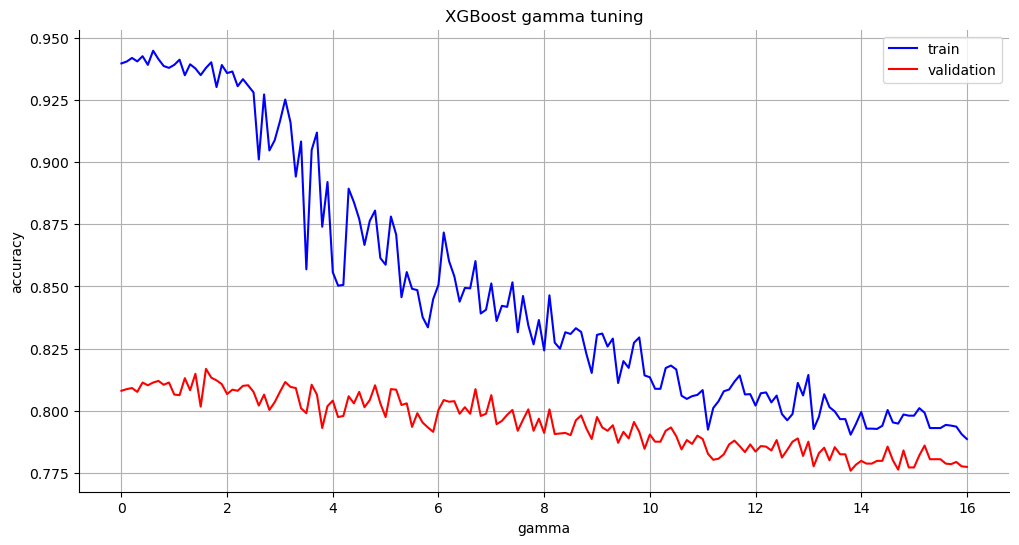

The runtime of your code is: 0:00:00.167795 (h:mm:ss)


In [831]:
time = timer()
plt.figure(figsize=(12, 6))
plt.plot(gamma_list, train_scores_xgb, c='blue', label='train')
plt.plot(gamma_list, validation_scores_xgb, c='red', label='validation')
plt.xlabel('gamma')
plt.ylabel('accuracy')
plt.title("XGBoost gamma tuning")
plt.yticks(np.arange(0.775, 0.96, 0.025))
plt.grid()
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

Let's take a closer look at the distribution and select peak values between 4 and 7.

In [871]:
gamma_range = [5.3, 6.7, 7]
print(gamma_range)

[5.3, 6.7, 7]


#### Optimize for `min_child_weight`

`min_child_weight` defines the minimum sum of weights of all observations required in a child. Let's use a for loop to optimize. We will use the unscaled train and validation sets for this.

Range: [0, $\infty$]

_Note: Increasing this hyperparameter makes the model conservative and reduces overfitting._

In [842]:
# running model for different min_child_weight
min_child_weight_list = list(range(50, 201, 1)) # range of min_child_weight to be tested
train_scores_xgb = []
validation_scores_xgb = []

for m in tqdm(min_child_weight_list):

    xgb = XGBClassifier(min_child_weight = m, verbosity = 0, n_jobs=-1)
    xgb.fit(X_train, y_train)
        
    # Evaluate
    train_scores_xgb.append(xgb.score(X_train, y_train))
    validation_scores_xgb.append(xgb.score(X_validation, y_validation))



100%|██████████| 151/151 [03:52<00:00,  1.54s/it]


Let's plot the accuracy scores against `min_child_weight` to find out the best `min_child_weight` value.

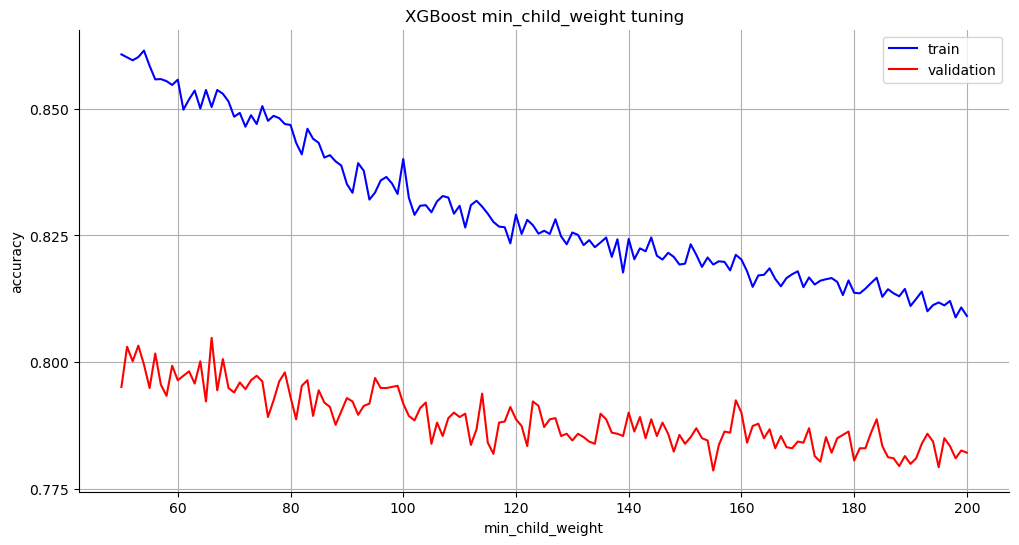

The runtime of your code is: 0:00:00.168660 (h:mm:ss)


In [846]:
time = timer()
plt.figure(figsize=(12, 6))
plt.plot(min_child_weight_list, train_scores_xgb, c='blue', label='train')
plt.plot(min_child_weight_list, validation_scores_xgb, c='red', label='validation')
plt.xlabel('min_child_weight')
plt.ylabel('accuracy')
plt.title("XGBoost min_child_weight tuning")
plt.yticks(np.arange(0.775, 0.875, 0.025))
plt.grid()
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

Ideal value for `min_child_weight` should be between 63 and 100. Let's take a closer look.

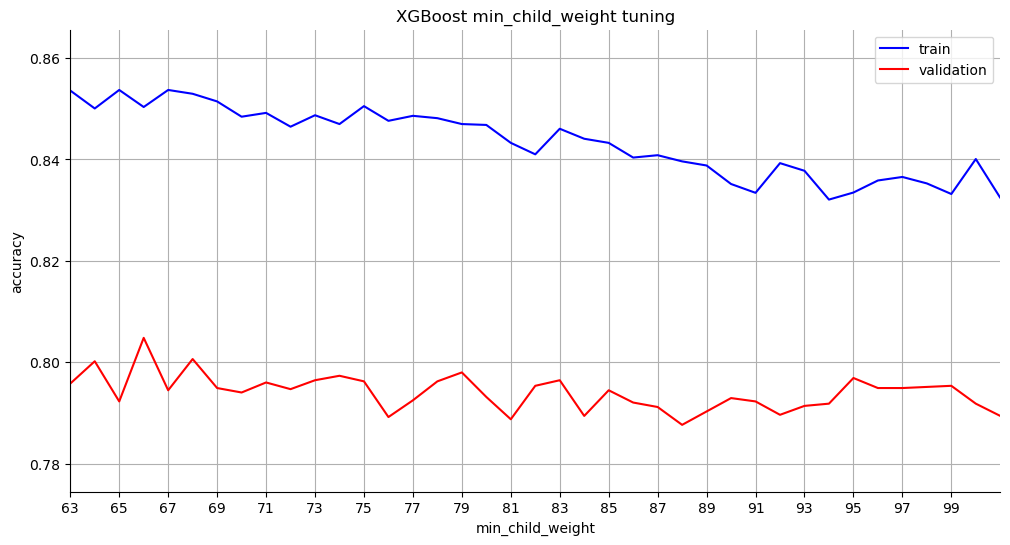

The runtime of your code is: 0:00:00.189741 (h:mm:ss)


In [847]:
time = timer()
plt.figure(figsize=(12, 6))
plt.plot(min_child_weight_list, train_scores_xgb, c='blue', label='train')
plt.plot(min_child_weight_list, validation_scores_xgb, c='red', label='validation')
plt.xlabel('min_child_weight')
plt.ylabel('accuracy')
plt.title("XGBoost min_child_weight tuning")
plt.xlim([63,101])
plt.xticks(range(63,101,2))
plt.grid()
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

We can inspect the peaks in the validation score line to select potential values for `min_child_weight`.

In [870]:
min_child_weight_range = [66, 68]
min_child_weight_range

[66, 68]

#### Optimize for `reg_lambda`

`reg_lambda` is the L2 regularization term on weights. Let's use a for loop to optimize. We will use the unscaled train and validation sets for this.

Range: [0,1]


_Note: Increasing this hyperparameter makes the model more conservative and reduces overfitting._

In [849]:
# running model for different reg_lambda
reg_lambda_list = list(np.arange(0, 1, .01).round(2)) # range of reg_lambda values to be tested
train_scores_xgb = []
validation_scores_xgb = []

for l in tqdm(reg_lambda_list):

    xgb = XGBClassifier(reg_lambda = l, verbosity = 0, n_jobs=-1)
    xgb.fit(X_train, y_train)
        
    # Evaluate
    train_scores_xgb.append(xgb.score(X_train, y_train))
    validation_scores_xgb.append(xgb.score(X_validation, y_validation))



100%|██████████| 100/100 [02:50<00:00,  1.71s/it]


Let's plot the accuracy scores against `reg_lambda`.

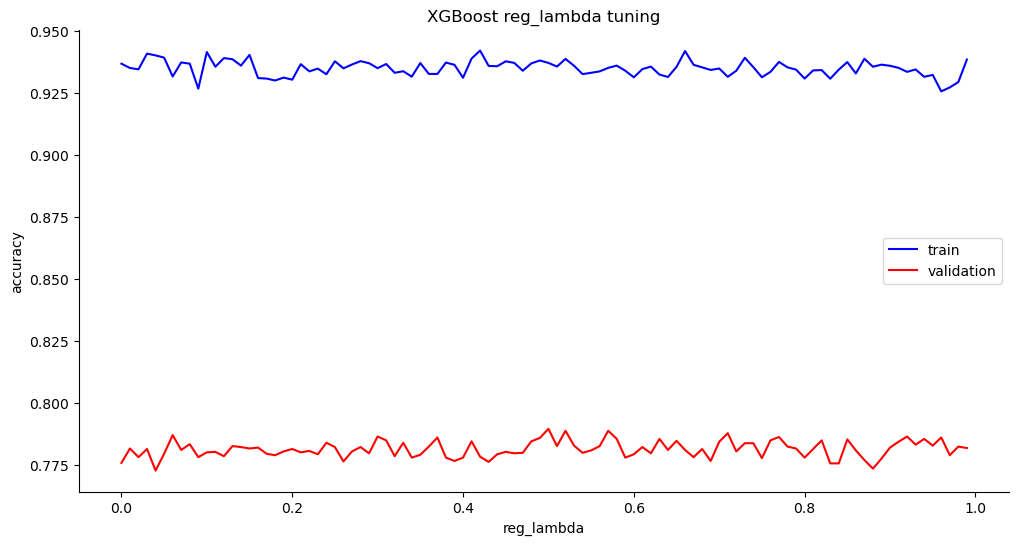

The runtime of your code is: 0:00:00.140126 (h:mm:ss)


In [158]:
time = timer()
plt.figure(figsize=(12, 6))
plt.plot(reg_lambda_list, train_scores_xgb, c='blue', label='train')
plt.plot(reg_lambda_list, validation_scores_xgb, c='red', label='validation')
plt.xlabel('reg_lambda')
plt.ylabel('accuracy')
plt.title("XGBoost reg_lambda tuning")
plt.grid()
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

`reg_lambda` seems to have a negligible effect on accuracy scores and isn't too helpful in minimizing overfitting either. We can leave it out of our future cross-validation testing and use the default value.

#### Optimize for `reg_alpha`

`reg_alpha` is the L1 regularization term on weights. Let's use a for loop to optimize. We will use the unscaled train and validation sets for this.

Range: [0, $\infty$]


_Note: Increasing this hyperparameter makes the model more conservative and reduces overfitting._

In [850]:
# running model for different reg_alpha
reg_alpha_list = list(range(5, 51, 1)) # range of reg_alpha values to be tested
train_scores_xgb = []
validation_scores_xgb = []

for a in tqdm(reg_alpha_list):

    xgb = XGBClassifier(reg_alpha = a, verbosity = 0, n_jobs=-1)
    xgb.fit(X_train, y_train)
        
    # Evaluate
    train_scores_xgb.append(xgb.score(X_train, y_train))
    validation_scores_xgb.append(xgb.score(X_validation, y_validation))



100%|██████████| 46/46 [01:22<00:00,  1.79s/it]


Let's plot the accuracy scores against `reg_alpha`.

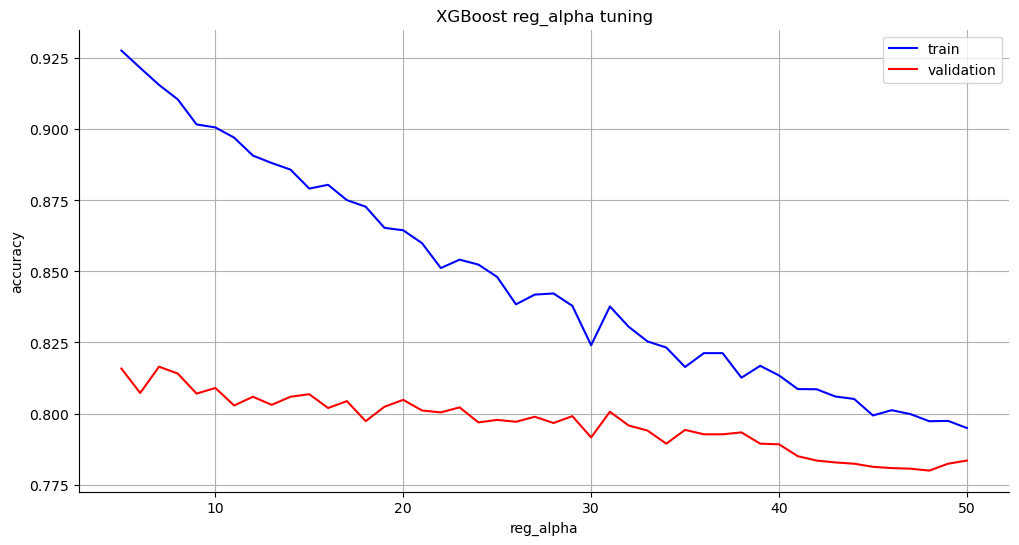

The runtime of your code is: 0:00:00.138021 (h:mm:ss)


In [852]:
time = timer()
plt.figure(figsize=(12, 6))
plt.plot(reg_alpha_list, train_scores_xgb, c='blue', label='train')
plt.plot(reg_alpha_list, validation_scores_xgb, c='red', label='validation')
plt.xlabel('reg_alpha')
plt.ylabel('accuracy')
plt.title("XGBoost reg_alpha tuning")
plt.yticks(np.arange(0.775, 0.925, 0.025))
plt.grid()
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

The ideal value for `reg_alpha` appears to lie between 20 and 35. Let's take a closer look.

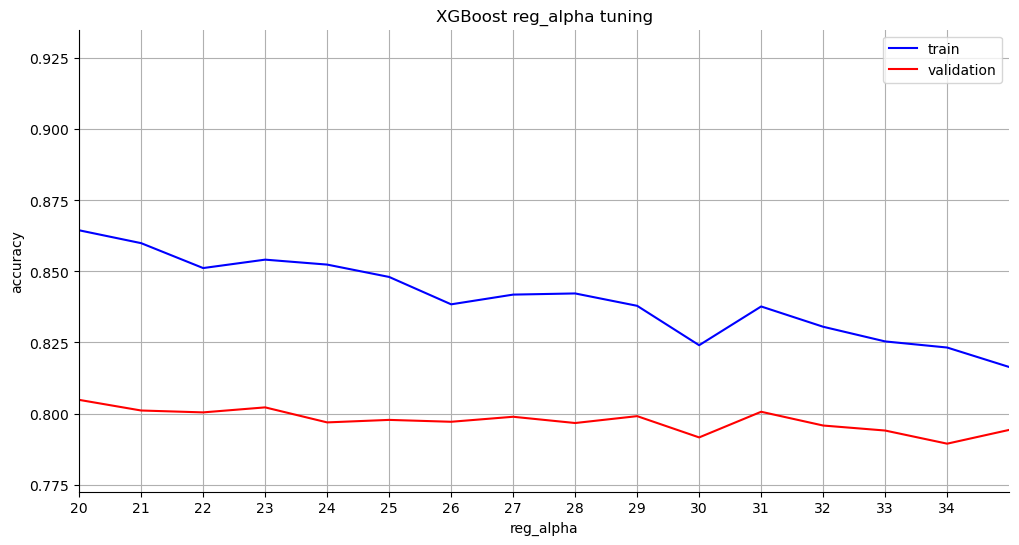

The runtime of your code is: 0:00:00.147860 (h:mm:ss)


In [854]:
time = timer()
plt.figure(figsize=(12, 6))
plt.plot(reg_alpha_list, train_scores_xgb, c='blue', label='train')
plt.plot(reg_alpha_list, validation_scores_xgb, c='red', label='validation')
plt.xlabel('reg_alpha')
plt.ylabel('accuracy')
plt.title("XGBoost reg_alpha tuning")
plt.xlim([20,35])
plt.xticks(range(20,35,1))
plt.yticks(np.arange(0.775, 0.925, 0.025))
plt.grid()
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

I will select values between 20 to 31 for cross-validation testing.

In [869]:
reg_alpha_range = [23, 31]
reg_alpha_range

[23, 31]

#### 5-fold Cross Validation

I will run a `GridSearchCV` to optimize for `max_depth`, `n_estimators`, `learning_rate`, `gamma`, `min_child_weight`, and `reg_alpha`. Every cross-validation test so far has yielded 'None' as the dimension reduction value. Therefore, I will leave out PCA() dimension reduction in future modeling. 

In [876]:
# specify the components
estimators = [
    ('model', XGBClassifier())
]

# create pipeline
my_pipe = Pipeline(estimators)


# grid for searching
param_grid = [
    {
        'model': [XGBClassifier(n_jobs=-2)],
        'model__n_estimators': estimators_range,
        'model__max_depth': depths_range,
        'model__learning_rate': learning_range,
        'model__gamma': gamma_range,
        'model__min_child_weight': min_child_weight_range,
        'model__reg_alpha': reg_alpha_range,
        'model__booster': ['gbtree', 'dart']
    }
]

time = timer() # start timer
grid = GridSearchCV(my_pipe, param_grid, cv=5, verbose=2, n_jobs=-2)

fittedgrid = grid.fit(X_train, y_train)
runtime = timer(time)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
The runtime of your code is: 2:32:33.941736 (h:mm:ss)


I will save the fittedgrid to a .pkl file.

In [877]:
# saving to .pkl
joblib.dump(fittedgrid, 'XGBoost_gridsearch.pkl')

['XGBoost_gridsearch.pkl']

In [878]:
xgb_fitgrid = joblib.load('XGBoost_gridsearch.pkl')

In [879]:
# best model
best_model = xgb_fitgrid.best_estimator_

In [880]:
# Best set of parameters
xgb_fitgrid.best_params_

{'model': XGBClassifier(base_score=None, booster='gbtree', colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None,
               enable_categorical=False, gamma=5.3, gpu_id=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.07, max_delta_step=None, max_depth=19,
               min_child_weight=66, missing=nan, monotone_constraints=None,
               n_estimators=140, n_jobs=-2, num_parallel_tree=None,
               predictor=None, random_state=None, reg_alpha=23, reg_lambda=None,
               scale_pos_weight=None, subsample=None, tree_method=None,
               validate_parameters=None, verbosity=None),
 'model__booster': 'gbtree',
 'model__gamma': 5.3,
 'model__learning_rate': 0.07,
 'model__max_depth': 19,
 'model__min_child_weight': 66,
 'model__n_estimators': 140,
 'model__reg_alpha': 23}

In [881]:
# best score
xgb_fitgrid.best_score_

0.7579722414814628

##### Accuracy Scores

Let's fit the best model to the remainder set and calculate accuracy scores.

In [882]:
time = timer()
# fit best_model
best_model.fit(X_remainder, y_remainder)
runtime = timer(time)

The runtime of your code is: 0:00:03.277019 (h:mm:ss)


In [883]:
time = timer()
# accuracy scores
print(f'Remainder Set Score: {best_model.score(X_remainder, y_remainder)}')
print(f'Test Set Score: {best_model.score(X_test, y_test)}')
runtime = timer(time)

Remainder Set Score: 0.7988067921064709
Test Set Score: 0.7746037275735934
The runtime of your code is: 0:00:00.066128 (h:mm:ss)


##### Precision and Recall

Let's plot the confusion matrix for the XGBoost model and get prediction for test set.

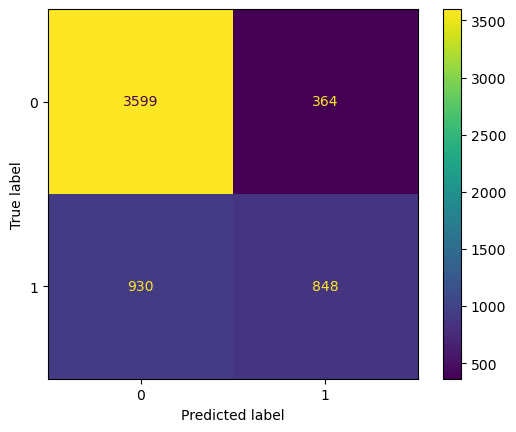

In [884]:
# plotting confusion matrix
plot_confusion_matrix(best_model, X_test, y_test);

In [885]:
# Get class predictions
y_pred = best_model.predict(X_test)

Let's get the Classification report.

In [886]:
# Classification score
xgb_report = classification_report(y_test, y_pred)
print(xgb_report)

              precision    recall  f1-score   support

           0       0.79      0.91      0.85      3963
           1       0.70      0.48      0.57      1778

    accuracy                           0.77      5741
   macro avg       0.75      0.69      0.71      5741
weighted avg       0.77      0.77      0.76      5741



Summary of Models:

|       **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                                                                |
|:--------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|--------------------------------------------------------------------------------------------------------------------|
| Logistic Regression  | 0.728                  | 0.728             | 0.36       | 0.60          | 0.45         | StandardScaler(), No dimension reduction,  C=1, solver='lbfgs'                                                     |
| Decision Tree 1      | 0.775                  | 0.754             | 0.48       | 0.64          | 0.55         | max_depth=8                                                                                                        |
| Decision Tree 2 (CV) | 0.827                  | 0.72              | 0.56       | 0.55          | 0.55         | max_depth=11, criterion='gini', PCA=16                                                                             |
| Random Forest 1 (CV) | 0.817                  | 0.759             | 0.36       | 0.73          | 0.48         | max_depth=14, criterion='gini', n_estimators=161, max_leaf_nodes=185, PCA=none                                     |
| Random Forest 2      | 0.826                  | 0.773             | 0.42       | 0.73          | 0.53         | max_depth=14, max_leaf_nodes=176, n_estimators=161, criterion='gini'                                               |
| Random Forest 3      | 0.832                  | 0.775             | 0.42       | 0.74          | 0.54         | max_depth=15, criterion='gini', n_estimators=191, max_leaf_nodes=200                                               |
| XGBoost 1 (CV)       | 0.799                  | 0.775             | 0.48       | 0.70          | 0.57         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=23 |


We have managed to control overfitting with XGBoost which can usually be an issue. However, our evaluation metrics have scope for improvement. Let's adjust the model based on our earlier hyperparameter optimization. 

**Summary**
- No overfitting.

- Moderate increase in Recall score over Random Forest 3..
- Slight increase in F1 score (best so far).

#### XGBoost 2

`XGBClassifier()` with all default values. I expect imporved scores for evaluation metrics albeit with significant overfitting.

In [899]:
# instantiate the model
xgb_two = XGBClassifier()

# fit the model
xgb_two.fit(X_remainder, y_remainder)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=6,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

##### Accuracy Scores

In [900]:
time = timer()
# accuracy scores
print(f'Remainder Set Score: {xgb_two.score(X_remainder, y_remainder)}')
print(f'Test Set Score: {xgb_two.score(X_test, y_test)}')
runtime = timer(time)

Remainder Set Score: 0.9218448829738413
Test Set Score: 0.7975962375892701
The runtime of your code is: 0:00:00.043078 (h:mm:ss)


##### Precision and Recall

Let's plot the confusion matrix for the XGBoost model and get prediction for test set.

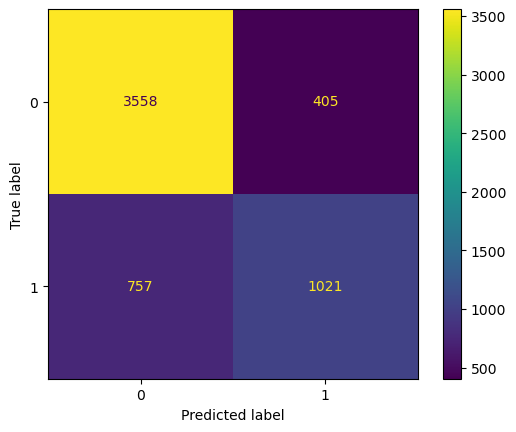

In [901]:
# plotting confusion matrix
plot_confusion_matrix(xgb_two, X_test, y_test);

In [903]:
# Get class predictions
y_pred = xgb_two.predict(X_test)

Let's get the Classification report.

In [904]:
# Classification score
xgb_report_two = classification_report(y_test, y_pred)
print(xgb_report_two)

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      3963
           1       0.72      0.57      0.64      1778

    accuracy                           0.80      5741
   macro avg       0.77      0.74      0.75      5741
weighted avg       0.79      0.80      0.79      5741



Summary of Models:

|       **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                                                                |
|:--------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|--------------------------------------------------------------------------------------------------------------------|
| Logistic Regression  | 0.728                  | 0.728             | 0.36       | 0.60          | 0.45         | StandardScaler(), No dimension reduction,  C=1, solver='lbfgs'                                                     |
| Decision Tree 1      | 0.775                  | 0.754             | 0.48       | 0.64          | 0.55         | max_depth=8                                                                                                        |
| Decision Tree 2 (CV) | 0.827                  | 0.72              | 0.56       | 0.55          | 0.55         | max_depth=11, criterion='gini', PCA=16                                                                             |
| Random Forest 1 (CV) | 0.817                  | 0.759             | 0.36       | 0.73          | 0.48         | max_depth=14, criterion='gini', n_estimators=161, max_leaf_nodes=185, PCA=none                                     |
| Random Forest 2      | 0.826                  | 0.773             | 0.42       | 0.73          | 0.53         | max_depth=14, max_leaf_nodes=176, n_estimators=161, criterion='gini'                                               |
| Random Forest 3      | 0.832                  | 0.775             | 0.42       | 0.74          | 0.54         | max_depth=15, criterion='gini', n_estimators=191, max_leaf_nodes=200                                               |
| XGBoost 1 (CV)       | 0.799                  | 0.775             | 0.48       | 0.70          | 0.57         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=23 |
| XGBoost 2            | 0.922                  | 0.798             | 0.57       | 0.72          | 0.64         | default                                                                                                            |



As expected, evaluation metric scores have imporoved (specially for Recall) but with overfitting problems. 

#### XGBoost 3

In [923]:
print(gamma_range)
print(learning_range)
print(depths_range)
print(min_child_weight_range)
print(estimators_range)
print(reg_alpha_range)

[5.3, 6.7, 7]
[0.07, 0.09, 0.2]
[5, 6, 19]
[66, 68]
[35, 40, 45, 140, 155]
[23, 31]


There is room to increase Accuracy scores over XGBoost 1 without worrying too much about overfitting. Lowering the 'L1' regularization factor `reg_alpha` should increase the accuracy scores. We can run another `GridSearchCV` keeping all the other hyperparameters the same as in XGBoost 1. However, `GridSearchCV` tends to give overfitting models. A better option here would be to use a `for` loop and plot the accuracy scores like we did for hyperparameter tuning. 

In [977]:
# running model for different reg_alpha
reg_alpha_list = list(np.arange(0, 7, 0.05)) # range of reg_alpha values to be tested
train_scores_xgb = []
validation_scores_xgb = []

for a in tqdm(reg_alpha_list):

    xgb = XGBClassifier(reg_alpha = a, booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140)
    xgb.fit(X_train, y_train)
        
    # Evaluate
    train_scores_xgb.append(xgb.score(X_train, y_train))
    validation_scores_xgb.append(xgb.score(X_validation, y_validation))



100%|██████████| 140/140 [09:18<00:00,  3.99s/it]


Let's plot the accuracy scores against `reg_alpha`.

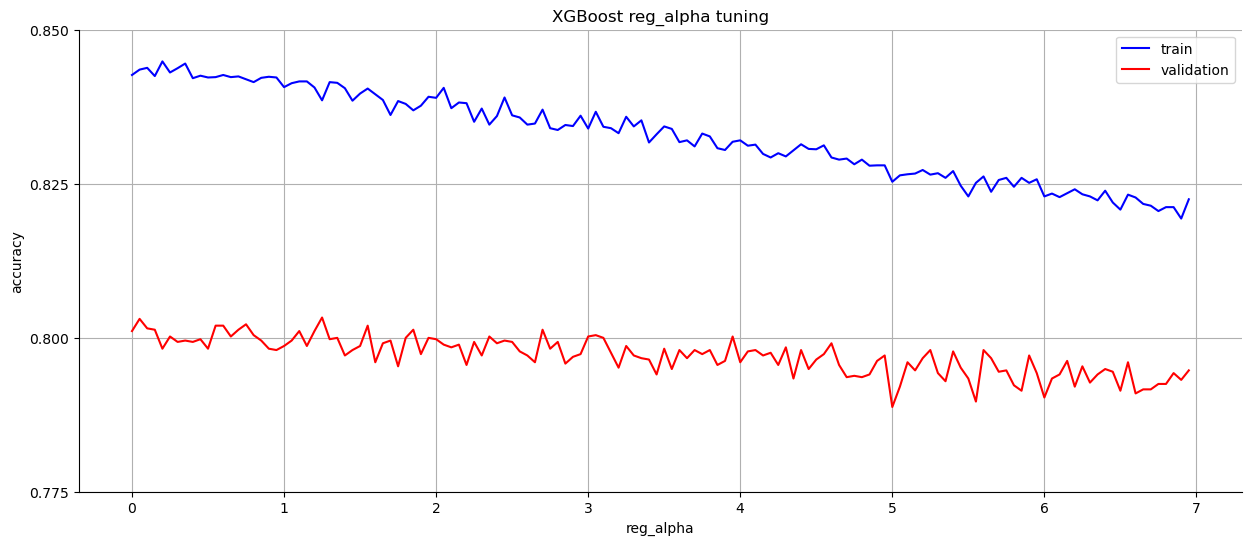

The runtime of your code is: 0:00:00.150040 (h:mm:ss)


In [1024]:
time = timer()
plt.figure(figsize=(15, 6))
plt.plot(reg_alpha_list, train_scores_xgb, c='blue', label='train')
plt.plot(reg_alpha_list, validation_scores_xgb, c='red', label='validation')
plt.xlabel('reg_alpha')
plt.ylabel('accuracy')
plt.title("XGBoost reg_alpha tuning")
plt.yticks(np.arange(0.775, 0.851, 0.025))
plt.grid()
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

Based on the plot, ideal value probably lies between 0 and 2.

In [1025]:
# instantiate the model
xgb_three = XGBClassifier(booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=1.6)

# fit the model
xgb_three.fit(X_remainder, y_remainder)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=5.3, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.07, max_delta_step=0,
              max_depth=19, min_child_weight=66, missing=nan,
              monotone_constraints='()', n_estimators=140, n_jobs=6,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=1.6, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

##### Accuracy Scores

In [1026]:
time = timer()
# accuracy scores
print(f'Remainder Set Score: {xgb_three.score(X_remainder, y_remainder)}')
print(f'Test Set Score: {xgb_three.score(X_test, y_test)}')
runtime = timer(time)

Remainder Set Score: 0.8466727856815053
Test Set Score: 0.7982929803170179
The runtime of your code is: 0:00:00.107022 (h:mm:ss)


##### Precision and Recall

Let's plot the confusion matrix for the XGBoost model and get prediction for test set.

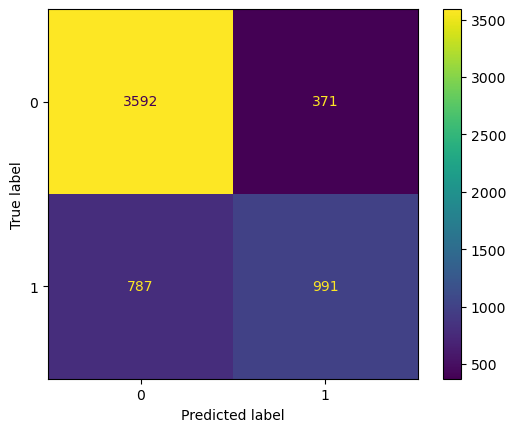

In [1027]:
# plotting confusion matrix
plot_confusion_matrix(xgb_three, X_test, y_test);

In [1028]:
# Get class predictions
y_pred = xgb_three.predict(X_test)

Let's get the Classification report.

In [1029]:
# Classification score
xgb_report_three = classification_report(y_test, y_pred)
print(xgb_report_three)

              precision    recall  f1-score   support

           0       0.82      0.91      0.86      3963
           1       0.73      0.56      0.63      1778

    accuracy                           0.80      5741
   macro avg       0.77      0.73      0.75      5741
weighted avg       0.79      0.80      0.79      5741



Summary of Models:

|       **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                                                                 |
|:--------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|---------------------------------------------------------------------------------------------------------------------|
| Logistic Regression  | 0.728                  | 0.728             | 0.36       | 0.60          | 0.45         | StandardScaler(), No dimension reduction,  C=1, solver='lbfgs'                                                      |
| Decision Tree 1      | 0.775                  | 0.754             | 0.48       | 0.64          | 0.55         | max_depth=8                                                                                                         |
| Decision Tree 2 (CV) | 0.827                  | 0.72              | 0.56       | 0.55          | 0.55         | max_depth=11, criterion='gini', PCA=16                                                                              |
| Random Forest 1 (CV) | 0.817                  | 0.759             | 0.36       | 0.73          | 0.48         | max_depth=14, criterion='gini', n_estimators=161, max_leaf_nodes=185, PCA=none                                      |
| Random Forest 2      | 0.826                  | 0.773             | 0.42       | 0.73          | 0.53         | max_depth=14, max_leaf_nodes=176, n_estimators=161, criterion='gini'                                                |
| Random Forest 3      | 0.832                  | 0.775             | 0.42       | 0.74          | 0.54         | max_depth=15, criterion='gini', n_estimators=191, max_leaf_nodes=200                                                |
| XGBoost 1 (CV)       | 0.799                  | 0.775             | 0.48       | 0.70          | 0.57         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=23  |
| XGBoost 2            | 0.922                  | 0.798             | 0.57       | 0.72          | 0.64         | default                                                                                                             |
| XGBoost 3            | 0.847                  | 0.798             | 0.56       | 0.73          | 0.63         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=1.6 |



**Summary**
- No overfitting issues.

- Slight increase in Accuracy (best so far) and Precision scores over XGBoost 1.
- Significant increase in Recall and F1 scores over XGBoost 1. 

#### XGBoost 4

In [1102]:
# instantiate the model
xgb = XGBClassifier(booster='gbtree', gamma=5.3, learning_rate=0.04, max_depth=19, min_child_weight=54, n_estimators=140, reg_alpha=1.6)

# fit the model
xgb.fit(X_remainder, y_remainder)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=5.3, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.04, max_delta_step=0,
              max_depth=19, min_child_weight=54, missing=nan,
              monotone_constraints='()', n_estimators=140, n_jobs=6,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=1.6, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

##### Accuracy Scores

In [1103]:
time = timer()
# accuracy scores
print(f'Remainder Set Score: {xgb.score(X_remainder, y_remainder)}')
print(f'Test Set Score: {xgb.score(X_test, y_test)}')
runtime = timer(time)

Remainder Set Score: 0.8376778338687472
Test Set Score: 0.7946350809963421
The runtime of your code is: 0:00:00.155038 (h:mm:ss)


##### Precision and Recall

Let's plot the confusion matrix for the XGBoost model and get prediction for test set.

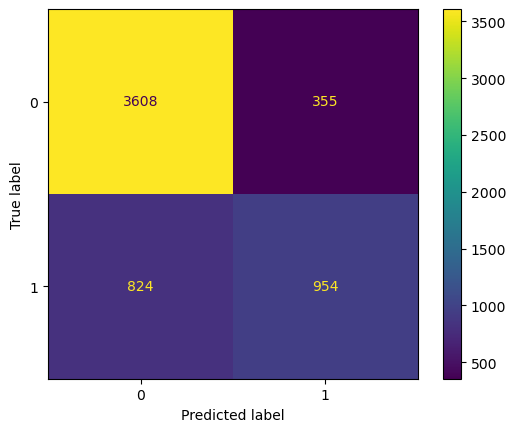

In [1104]:
# plotting confusion matrix
plot_confusion_matrix(xgb, X_test, y_test);

In [1105]:
# Get class predictions
y_pred = xgb.predict(X_test)

Let's get the Classification report.

In [1106]:
# Classification score
xgb_report = classification_report(y_test, y_pred)
print(xgb_report)

              precision    recall  f1-score   support

           0       0.81      0.91      0.86      3963
           1       0.73      0.54      0.62      1778

    accuracy                           0.79      5741
   macro avg       0.77      0.72      0.74      5741
weighted avg       0.79      0.79      0.78      5741



Summary of Models:

|       **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                                                                 |
|:--------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|---------------------------------------------------------------------------------------------------------------------|
| Logistic Regression  | 0.728                  | 0.728             | 0.36       | 0.60          | 0.45         | StandardScaler(), No dimension reduction,  C=1, solver='lbfgs'                                                      |
| Decision Tree 1      | 0.775                  | 0.754             | 0.48       | 0.64          | 0.55         | max_depth=8                                                                                                         |
| Decision Tree 2 (CV) | 0.827                  | 0.72              | 0.56       | 0.55          | 0.55         | max_depth=11, criterion='gini', PCA=16                                                                              |
| Random Forest 1 (CV) | 0.817                  | 0.759             | 0.36       | 0.73          | 0.48         | max_depth=14, criterion='gini', n_estimators=161, max_leaf_nodes=185, PCA=none                                      |
| Random Forest 2      | 0.826                  | 0.773             | 0.42       | 0.73          | 0.53         | max_depth=14, max_leaf_nodes=176, n_estimators=161, criterion='gini'                                                |
| Random Forest 3      | 0.832                  | 0.775             | 0.42       | 0.74          | 0.54         | max_depth=15, criterion='gini', n_estimators=191, max_leaf_nodes=200                                                |
| XGBoost 1 (CV)       | 0.799                  | 0.775             | 0.48       | 0.70          | 0.57         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=23  |
| XGBoost 2            | 0.922                  | 0.798             | 0.57       | 0.72          | 0.64         | default                                                                                                             |
| XGBoost 3            | 0.847                  | 0.798             | 0.56       | 0.73          | 0.63         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=1.6 |
| XGBoost 4            | 0.838                  | 0.795             | 0.54       | 0.73          | 0.62         | booster='gbtree', gamma=5.3, learning_rate=0.04, max_depth=19, min_child_weight=54, n_estimators=140, reg_alpha=1.6 |



**Summary**
- No overfitting.

- Negligible difference in scores from XGBoost 3.

-----

### Support Vector Machine (SVM)

SVM classifiers need scaled data. We scaled the data using the `StandardScaler()` earlier in the process.

#### Optimize for `kernel`

`kernel` sepcifies the type of kernel used in the algorithm for classification. I will use a `for` loop to find optimal `kernel` while keeping the other hyperparameters at their default values. 

In [1108]:
# running model for different kernel values
kernel_list = ['linear', 'poly', 'rbf', 'sigmoid'] # range of kernel values to be tested
train_scores_svm = []
validation_scores_svm = []

for k in tqdm(kernel_list):

    svm = SVC(kernel=k) 
    svm.fit(X_train_scaled, y_train)
        
    # Evaluate
    train_scores_svm.append(svm.score(X_train_scaled, y_train))
    validation_scores_svm.append(svm.score(X_validation_scaled, y_validation))

100%|██████████| 4/4 [01:39<00:00, 24.93s/it]


Let's plot the accuracy scores against `kernel` to find the ideal value.

In [1109]:
print(f'Kernel value to validation accuracy scores:\n {dict(zip(kernel_list, validation_scores_svm))}')

Kernel value to validation accuracy scores:
 {'linear': 0.6903609154929577, 'poly': 0.748899647887324, 'rbf': 0.7662852112676056, 'sigmoid': 0.6362235915492958}


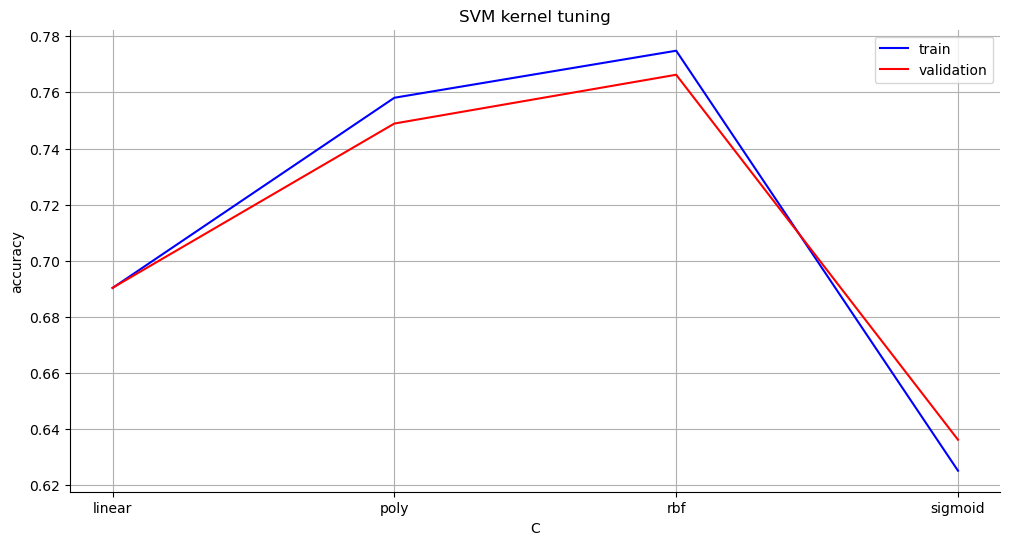

The runtime of your code is: 0:00:00.147345 (h:mm:ss)


In [1110]:
time = timer()
plt.figure(figsize=(12, 6))
plt.plot(kernel_list, train_scores_svm, c='blue', label='train')
plt.plot(kernel_list, validation_scores_svm, c='red', label='validation')
plt.xlabel('C')
plt.ylabel('accuracy')
plt.title("SVM kernel tuning")
plt.grid()
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

The best choice for `kernel` is 'rbf'. 'poly' also gives similar if not as good results. We will go with 'rbf' from this point forth as it effective at capturing complex non-linear relationships. If overfitting becomes a big issue we can also try out 'poly' `kernel`.

#### Optimize for `C` (regularization)

The strength of regularization is inversely proportional to `C`. I will optimize for `C` using `for` loop and then plotting the accuracy scores vs `C` values.

In [ ]:
np.logspace(-3,3,7)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [1136]:
# running model for different C (regularization) values
c_list = list(np.logspace(-3,3,7)) # range of C values to be tested
train_scores_svm = []
validation_scores_svm = []

for c in tqdm(c_list):

    svm = SVC(C = c, kernel='rbf') 
    svm.fit(X_train_scaled, y_train)
        
    # Evaluate
    train_scores_svm.append(svm.score(X_train_scaled, y_train))
    validation_scores_svm.append(svm.score(X_validation_scaled, y_validation))

100%|██████████| 7/7 [09:44<00:00, 83.52s/it] 


Let's plot the accuracy scores against `C` to find the ideal value.

In [1137]:
print(f'C value to validation accuracy scores:\n {dict(zip(c_list, validation_scores_svm))}')

C value to validation accuracy scores:
 {0.001: 0.6903609154929577, 0.01: 0.6903609154929577, 0.1: 0.7378961267605634, 1.0: 0.7662852112676056, 10.0: 0.7808098591549296, 100.0: 0.7834507042253521, 1000.0: 0.7689260563380281}


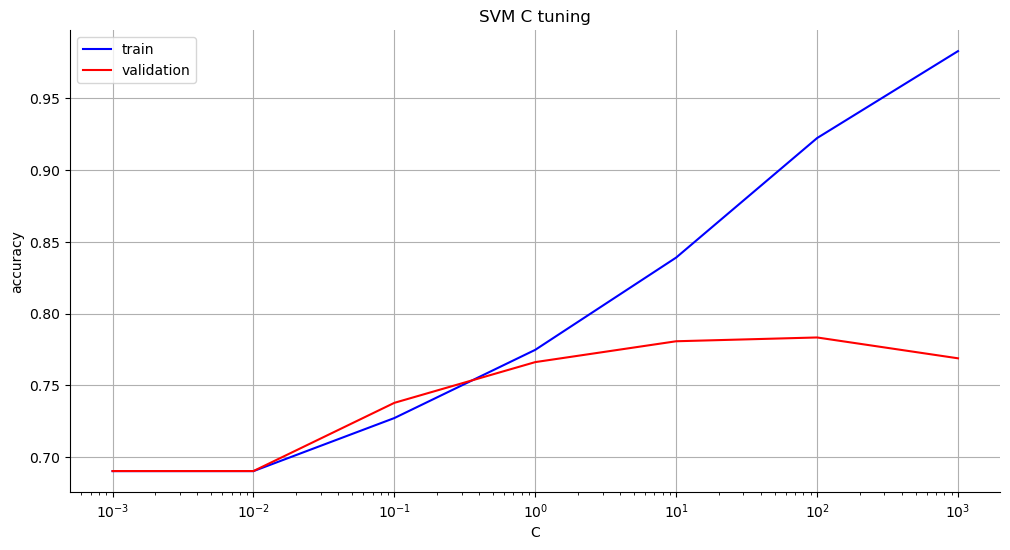

The runtime of your code is: 0:00:00.937037 (h:mm:ss)


In [1143]:
time = timer()
plt.figure(figsize=(12, 6))
plt.plot(c_list, train_scores_svm, c='blue', label='train')
plt.plot(c_list, validation_scores_svm, c='red', label='validation')
plt.xlabel('C')
plt.ylabel('accuracy')
plt.xscale('log')
plt.xticks(c_list)
plt.title("SVM C tuning")
plt.grid()
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

Most proabable ideal value for `C` is 100. 10 is also a good option, especially if overfitting is an issue. Let's take a look at values from 10 to 100.

In [1145]:
# running model for different C (regularization) values
c_list = list(range(10,101,10)) # range of C values to be tested
train_scores_svm = []
validation_scores_svm = []

for c in tqdm(c_list):

    svm = SVC(C = c, kernel='rbf') 
    svm.fit(X_train_scaled, y_train)
        
    # Evaluate
    train_scores_svm.append(svm.score(X_train_scaled, y_train))
    validation_scores_svm.append(svm.score(X_validation_scaled, y_validation))

100%|██████████| 10/10 [11:44<00:00, 70.47s/it]


In [1146]:
print(f'C value to validation accuracy scores:\n {dict(zip(c_list, validation_scores_svm))}')

C value to validation accuracy scores:
 {10: 0.7808098591549296, 20: 0.7819102112676056, 30: 0.7797095070422535, 40: 0.7792693661971831, 50: 0.7805897887323944, 60: 0.7805897887323944, 70: 0.7808098591549296, 80: 0.7816901408450704, 90: 0.78125, 100: 0.7834507042253521}


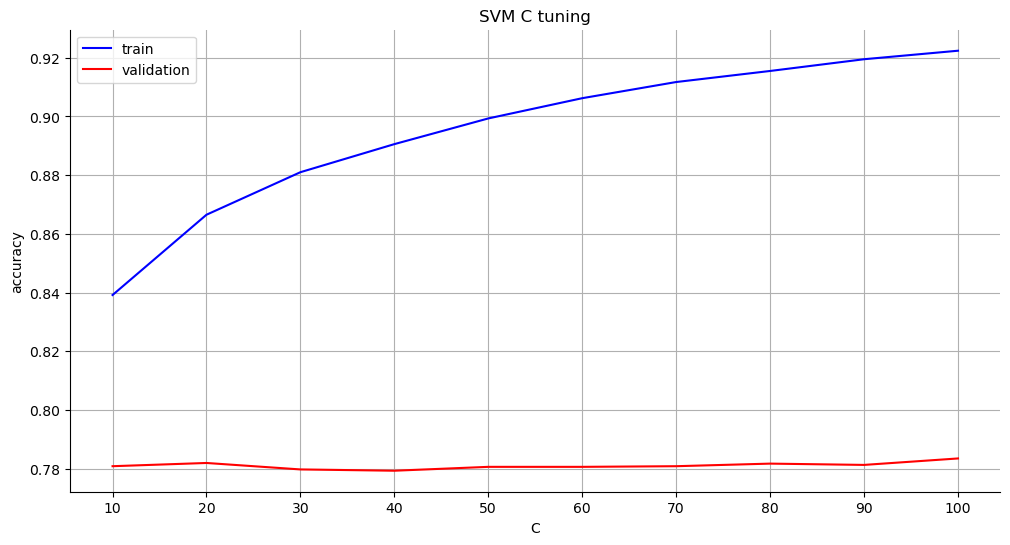

The runtime of your code is: 0:00:00.153578 (h:mm:ss)


In [1147]:
# plot C values vs accuracy scores 
time = timer()
plt.figure(figsize=(12, 6))
plt.plot(c_list, train_scores_svm, c='blue', label='train')
plt.plot(c_list, validation_scores_svm, c='red', label='validation')
plt.xlabel('C')
plt.xticks(c_list)
plt.ylabel('accuracy')
plt.title("SVM C tuning")
plt.grid()
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

In [1148]:
# probable C values
c_range = [10, 20, 80, 100]
c_range

[10, 20, 80, 100]

#### Optimize for `gamma` 

`gamma` is the kernel coefficient for 'rbf', 'poly' and 'sigmoid'. 

In [1150]:
# running model for different gamma
gamma_list = list(np.logspace(-9, 1, 11)) # range of gamma to be tested
train_scores_svm = []
validation_scores_svm = []

for g in tqdm(gamma_list):

    svm = SVC(gamma = g, kernel='rbf') 
    svm.fit(X_train_scaled, y_train)
    
    # Evaluate
    train_scores_svm.append(svm.score(X_train_scaled, y_train))
    validation_scores_svm.append(svm.score(X_validation_scaled, y_validation))

100%|██████████| 11/11 [10:09<00:00, 55.45s/it]


In [1151]:
print(f'gamma values and validation accuracy scores:\n \
      {dict(zip(gamma_list, validation_scores_svm))}')

gamma values and validation accuracy scores:
       {1e-09: 0.6903609154929577, 1e-08: 0.6903609154929577, 1e-07: 0.6903609154929577, 1e-06: 0.6903609154929577, 1e-05: 0.6903609154929577, 0.0001: 0.6903609154929577, 0.001: 0.6903609154929577, 0.01: 0.738556338028169, 0.1: 0.7790492957746479, 1.0: 0.7544014084507042, 10.0: 0.6903609154929577}


Let's plot the accuracy scores against `gamma` to find the ideal value.

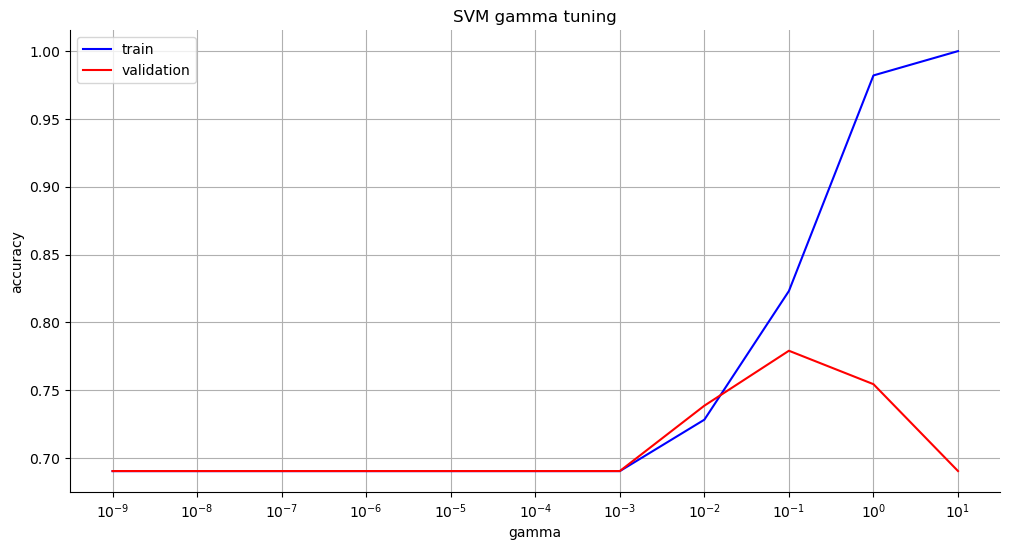

The runtime of your code is: 0:00:00.381832 (h:mm:ss)


In [1152]:
time = timer()
plt.figure(figsize=(12, 6))
plt.plot(gamma_list, train_scores_svm, c='blue', label='train')
plt.plot(gamma_list, validation_scores_svm, c='red', label='validation')
plt.xlabel('gamma')
plt.ylabel('accuracy')
plt.xscale('log')
plt.xticks(gamma_list)
plt.title("SVM gamma tuning")
plt.grid()
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

Probable ideal value for `gamma` should be between 0.1 and 1.

In [1153]:
# running model for different gamma
gamma_list = list(np.arange(0.1, 2.1, 0.1).round(1)) # range of gamma to be tested
train_scores_svm = []
validation_scores_svm = []

for g in tqdm(gamma_list):

    svm = SVC(gamma = g, kernel='rbf')
    svm.fit(X_train_scaled, y_train)
    
    # Evaluate
    train_scores_svm.append(svm.score(X_train_scaled, y_train))
    validation_scores_svm.append(svm.score(X_validation_scaled, y_validation))

100%|██████████| 20/20 [29:31<00:00, 88.56s/it]


In [1154]:
print(f'gamma values and validation accuracy scores:\n \
      {dict(zip(gamma_list, validation_scores_svm))}')

gamma values and validation accuracy scores:
       {0.1: 0.7790492957746479, 0.2: 0.7874119718309859, 0.3: 0.7893926056338029, 0.4: 0.7876320422535211, 0.5: 0.7805897887323944, 0.6: 0.7797095070422535, 0.7: 0.7757482394366197, 0.8: 0.7682658450704225, 0.9: 0.7596830985915493, 1.0: 0.7544014084507042, 1.1: 0.746919014084507, 1.2: 0.7418573943661971, 1.3: 0.7367957746478874, 1.4: 0.734375, 1.5: 0.7295334507042254, 1.6: 0.7268926056338029, 1.7: 0.7249119718309859, 1.8: 0.7220510563380281, 1.9: 0.717649647887324, 2.0: 0.7150088028169014}


Let's plot the accuracy scores against `C` to find the ideal value.

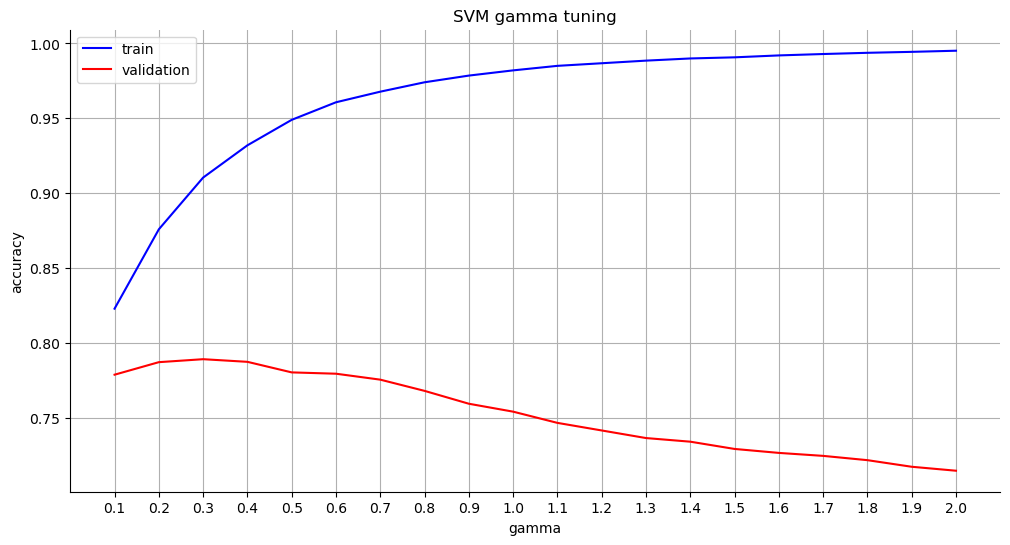

The runtime of your code is: 0:00:00.212098 (h:mm:ss)


In [1155]:
time = timer()
plt.figure(figsize=(12, 6))
plt.plot(gamma_list, train_scores_svm, c='blue', label='train')
plt.plot(gamma_list, validation_scores_svm, c='red', label='validation')
plt.xlabel('gamma')
plt.ylabel('accuracy')
plt.xlim(0,2.1)
plt.xticks(gamma_list)
plt.title("SVM gamma tuning")
plt.grid()
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

We have narrowed down the probable ideal `gamma` value to between 0.1 and 0.6.

In [1156]:
# running model for different gamma
gamma_list = list(np.arange(0.1, 0.61, 0.025).round(3)) # range of gamma to be tested
train_scores_svm = []
validation_scores_svm = []

for g in tqdm(gamma_list):

    svm = SVC(gamma = g, kernel='rbf') 
    svm.fit(X_train_scaled, y_train)
    
    # Evaluate
    train_scores_svm.append(svm.score(X_train_scaled, y_train))
    validation_scores_svm.append(svm.score(X_validation_scaled, y_validation))

100%|██████████| 21/21 [24:01<00:00, 68.62s/it]


In [1157]:
print(f'gamma values and validation accuracy scores:\n \
      {dict(zip(gamma_list, validation_scores_svm))}')

gamma values and validation accuracy scores:
       {0.1: 0.7790492957746479, 0.125: 0.7845510563380281, 0.15: 0.7865316901408451, 0.175: 0.7867517605633803, 0.2: 0.7874119718309859, 0.225: 0.7860915492957746, 0.25: 0.788512323943662, 0.275: 0.7898327464788732, 0.3: 0.7893926056338029, 0.325: 0.7904929577464789, 0.35: 0.789612676056338, 0.375: 0.7893926056338029, 0.4: 0.7876320422535211, 0.425: 0.7852112676056338, 0.45: 0.7832306338028169, 0.475: 0.7808098591549296, 0.5: 0.7805897887323944, 0.525: 0.7816901408450704, 0.55: 0.7803697183098591, 0.575: 0.7797095070422535, 0.6: 0.7797095070422535}


Let's plot the accuracy scores against `gamma` to find the ideal value.

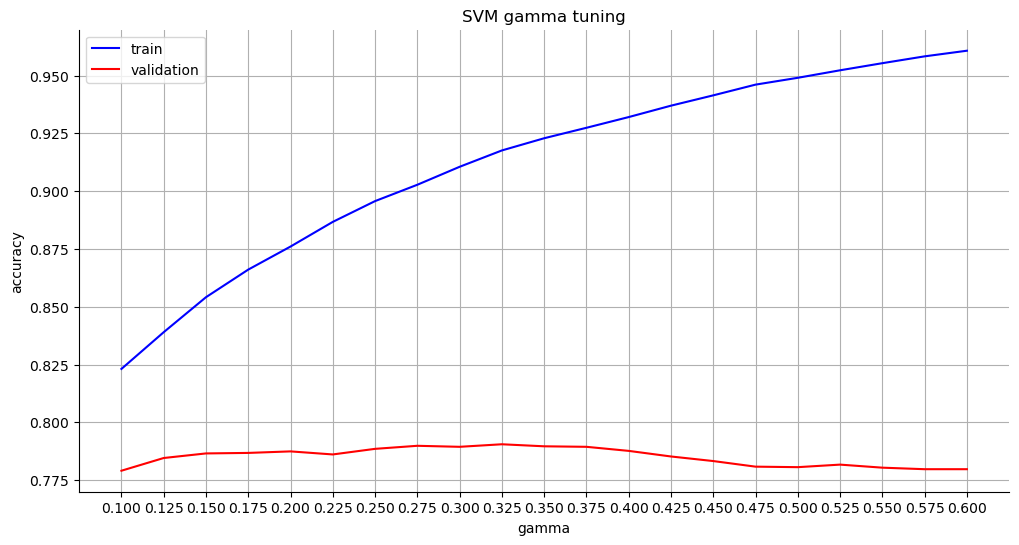

The runtime of your code is: 0:00:00.217080 (h:mm:ss)


In [1160]:
time = timer()
plt.figure(figsize=(12, 6))
plt.plot(gamma_list, train_scores_svm, c='blue', label='train')
plt.plot(gamma_list, validation_scores_svm, c='red', label='validation')
plt.xlabel('gamma')
plt.ylabel('accuracy')
# plt.xlim(0,1)
plt.xticks(gamma_list)
plt.title("SVM gamma tuning")
plt.grid()
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

In [1163]:
# running model for different gamma
gamma_list = list(np.arange(0.2, 0.4, 0.005).round(3)) # range of gamma to be tested
train_scores_svm = []
validation_scores_svm = []

for g in tqdm(gamma_list):

    svm = SVC(gamma = g, kernel='rbf') 
    svm.fit(X_train_scaled, y_train)
    
    # Evaluate
    train_scores_svm.append(svm.score(X_train_scaled, y_train))
    validation_scores_svm.append(svm.score(X_validation_scaled, y_validation))

100%|██████████| 40/40 [47:15<00:00, 70.89s/it]


In [1190]:
print(f'gamma values and validation accuracy scores:\n \
      {dict(zip(gamma_list, validation_scores_svm))}')

gamma values and validation accuracy scores:
       {0.2: 0.7874119718309859, 0.205: 0.7876320422535211, 0.21: 0.7878521126760564, 0.215: 0.7867517605633803, 0.22: 0.7863116197183099, 0.225: 0.7860915492957746, 0.23: 0.7871919014084507, 0.235: 0.7876320422535211, 0.24: 0.7876320422535211, 0.245: 0.788512323943662, 0.25: 0.788512323943662, 0.255: 0.788512323943662, 0.26: 0.7893926056338029, 0.265: 0.7898327464788732, 0.27: 0.7904929577464789, 0.275: 0.7898327464788732, 0.28: 0.7909330985915493, 0.285: 0.7904929577464789, 0.29: 0.7898327464788732, 0.295: 0.7887323943661971, 0.3: 0.7893926056338029, 0.305: 0.789612676056338, 0.31: 0.789612676056338, 0.315: 0.7902728873239436, 0.32: 0.7900528169014085, 0.325: 0.7904929577464789, 0.33: 0.789612676056338, 0.335: 0.7893926056338029, 0.34: 0.7891725352112676, 0.345: 0.7893926056338029, 0.35: 0.789612676056338, 0.355: 0.7889524647887324, 0.36: 0.7891725352112676, 0.365: 0.7898327464788732, 0.37: 0.7900528169014085, 0.375: 0.7893926056338029, 0.

In [1165]:
print(f'gamma values and train accuracy scores:\n \
      {dict(zip(gamma_list, train_scores_svm))}')

gamma values and train accuracy scores:
       {0.2: 0.876029224167923, 0.205: 0.8785805404151688, 0.21: 0.8811318566624144, 0.215: 0.8832192972283428, 0.22: 0.884784877652789, 0.225: 0.8866983648382234, 0.23: 0.8882059608025049, 0.235: 0.8907572770497507, 0.24: 0.8924968108546909, 0.245: 0.8941203757393019, 0.25: 0.8956859561637481, 0.255: 0.8969036298272063, 0.26: 0.8984112257914879, 0.265: 0.8998608372956047, 0.27: 0.9013104487997217, 0.275: 0.9027600603038386, 0.28: 0.9039777339672967, 0.285: 0.9056012988519077, 0.29: 0.9072828481966833, 0.295: 0.9089064130812942, 0.3: 0.9105299779659052, 0.305: 0.9113997448683753, 0.31: 0.9130812942131509, 0.315: 0.9138930766554564, 0.32: 0.9162704395222081, 0.325: 0.9176040821059956, 0.33: 0.9185898179287951, 0.335: 0.9196335382117592, 0.34: 0.9206192740345588, 0.345: 0.9220688855386756, 0.35: 0.9228806679809811, 0.355: 0.9238084193436159, 0.36: 0.924678186246086, 0.365: 0.9257798909892149, 0.37: 0.926475704511191, 0.375: 0.9274034558738258, 0.38

Let's plot the accuracy scores against `gamma` to find the ideal value.

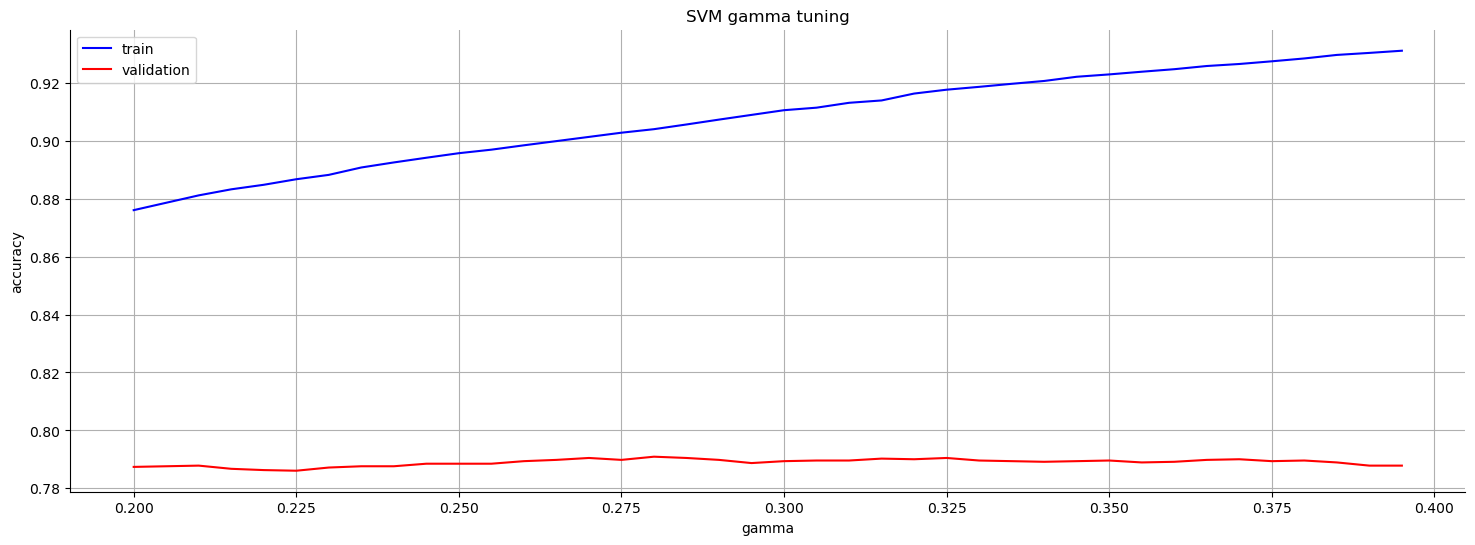

The runtime of your code is: 0:00:00.291718 (h:mm:ss)


In [1199]:
time = timer()
plt.figure(figsize=(18, 6))
plt.plot(gamma_list, train_scores_svm, c='blue', label='train')
plt.plot(gamma_list, validation_scores_svm, c='red', label='validation')
plt.xlabel('gamma')
plt.ylabel('accuracy')
# plt.xticks(gamma_list)
# plt.xlim(0.25, 0.375)
plt.grid()
plt.title("SVM gamma tuning")
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

To find the `gamma` values with the highest validation scores, let's create a dictionary with `gamma` values as keys and validation scores as values. Then we can sort the dictionary and get the `gamma` values corresponding to the top 5 validation scores.

In [1205]:
# create a dictionary with gamma as key and validation scores as value
gamma_validation_svm_optimal = dict()
for i in range(len(gamma_list)):
    gamma_validation_svm_optimal[gamma_list[i]] = validation_scores_svm[i]

In [1207]:
# get indices i.e. gamma values for top 5 validation scores
gamma_range = sorted(gamma_validation_svm_optimal, key=gamma_validation_svm_optimal.get, reverse=True)[:5]
gamma_range

[0.28, 0.27, 0.285, 0.325, 0.315]

#### 5-fold Cross-Validation

In [1208]:
# estimators for pipeline
estimators = [
    ('scale', StandardScaler()),
    ('SVM', SVC())
]

# pipeline creation
pipe = Pipeline(estimators)

In [1212]:
# param-grid
params = [
    {'SVM': [SVC()],
     'scale': [StandardScaler(), MinMaxScaler()],
     'SVM__C': c_range,
     'SVM__kernel': ['rbf'],
     'SVM__gamma': gamma_range
    }
]

Now we create a `GridSearchCV` object abd fit the grid to the remainder data.

In [1213]:
time = timer() # start timer
# GridSearchCv object
grid = GridSearchCV(pipe, param_grid=params, cv=5, verbose=2)

# fitting the grid
fittedgrid = grid.fit(X_remainder, y_remainder)
runtime = timer(time)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END SVM=SVC(), SVM__C=10, SVM__gamma=0.28, SVM__kernel=rbf, scale=StandardScaler(); total time= 1.3min
[CV] END SVM=SVC(), SVM__C=10, SVM__gamma=0.28, SVM__kernel=rbf, scale=StandardScaler(); total time= 1.2min
[CV] END SVM=SVC(), SVM__C=10, SVM__gamma=0.28, SVM__kernel=rbf, scale=StandardScaler(); total time= 1.2min
[CV] END SVM=SVC(), SVM__C=10, SVM__gamma=0.28, SVM__kernel=rbf, scale=StandardScaler(); total time= 1.2min
[CV] END SVM=SVC(), SVM__C=10, SVM__gamma=0.28, SVM__kernel=rbf, scale=StandardScaler(); total time= 1.1min
[CV] END SVM=SVC(), SVM__C=10, SVM__gamma=0.28, SVM__kernel=rbf, scale=MinMaxScaler(); total time=  18.5s
[CV] END SVM=SVC(), SVM__C=10, SVM__gamma=0.28, SVM__kernel=rbf, scale=MinMaxScaler(); total time=  18.5s
[CV] END SVM=SVC(), SVM__C=10, SVM__gamma=0.28, SVM__kernel=rbf, scale=MinMaxScaler(); total time=  18.6s
[CV] END SVM=SVC(), SVM__C=10, SVM__gamma=0.28, SVM__kernel=rbf, scale=MinMaxSca

In [1214]:
joblib.dump(fittedgrid, 'svm_grid.pkl')

['svm_grid.pkl']

In [1215]:
svm_grid_one = joblib.load('svm_grid.pkl')

In [1216]:
# best model
best_model = svm_grid_one.best_estimator_

In [1217]:
svm_grid_one.best_estimator_

Pipeline(steps=[('scale', StandardScaler()), ('SVM', SVC(C=10, gamma=0.315))])

In [1218]:
# Best set of parameters
svm_grid_one.best_params_

{'SVM': SVC(C=10, gamma=0.315),
 'SVM__C': 10,
 'SVM__gamma': 0.315,
 'SVM__kernel': 'rbf',
 'scale': StandardScaler()}

In [1219]:
# best score
svm_grid_one.best_score_

0.8027076640660853

##### Accuracy Scores

Let's fit the best model to the remainder set and calculate accuracy scores.

In [1220]:
time = timer()
# fit best_model
best_model.fit(X_remainder, y_remainder)
runtime = timer(time)

The runtime of your code is: 0:02:20.577461 (h:mm:ss)


In [1221]:
time = timer()
# accuracy scores
print(f'Remainder Set Score: {best_model.score(X_remainder, y_remainder)}')
print(f'Test Set Score: {best_model.score(X_test, y_test)}')
runtime = timer(time)

Remainder Set Score: 0.9944011014226709
Test Set Score: 0.8181501480578296
The runtime of your code is: 0:00:44.081960 (h:mm:ss)


##### Precision and Recall

Let's plot the confusion matrix for the SVM model and get prediction for test set.

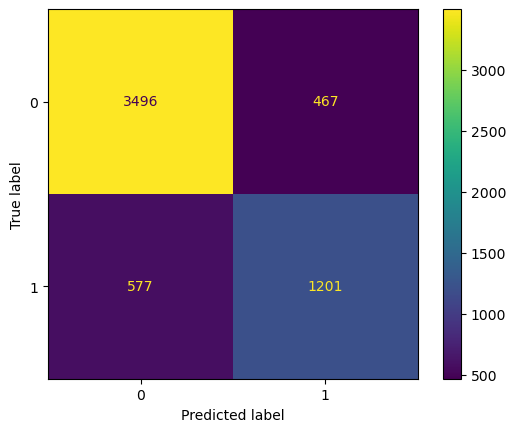

In [1222]:
# plotting confusion matrix
plot_confusion_matrix(best_model, X_test, y_test);

In [1223]:
# Get class predictions
y_pred = best_model.predict(X_test)

Let's get the Classification report.

In [1224]:
# Classification score
svm_report_one = classification_report(y_test, y_pred)
print(svm_report_one)

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      3963
           1       0.72      0.68      0.70      1778

    accuracy                           0.82      5741
   macro avg       0.79      0.78      0.78      5741
weighted avg       0.82      0.82      0.82      5741



Summary of Models:

|       **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                                                                 |
|:--------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|---------------------------------------------------------------------------------------------------------------------|
| Logistic Regression  | 0.728                  | 0.728             | 0.36       | 0.60          | 0.45         | StandardScaler(), No dimension reduction,  C=1, solver='lbfgs'                                                      |
| Decision Tree 1      | 0.775                  | 0.754             | 0.48       | 0.64          | 0.55         | max_depth=8                                                                                                         |
| Decision Tree 2 (CV) | 0.827                  | 0.72              | 0.56       | 0.55          | 0.55         | max_depth=11, criterion='gini', PCA=16                                                                              |
| Random Forest 1 (CV) | 0.817                  | 0.759             | 0.36       | 0.73          | 0.48         | max_depth=14, criterion='gini', n_estimators=161, max_leaf_nodes=185, PCA=none                                      |
| Random Forest 2      | 0.826                  | 0.773             | 0.42       | 0.73          | 0.53         | max_depth=14, max_leaf_nodes=176, n_estimators=161, criterion='gini'                                                |
| Random Forest 3      | 0.832                  | 0.775             | 0.42       | 0.74          | 0.54         | max_depth=15, criterion='gini', n_estimators=191, max_leaf_nodes=200                                                |
| XGBoost 1 (CV)       | 0.799                  | 0.775             | 0.48       | 0.70          | 0.57         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=23  |
| XGBoost 2            | 0.922                  | 0.798             | 0.57       | 0.72          | 0.64         | default                                                                                                             |
| XGBoost 3            | 0.847                  | 0.798             | 0.56       | 0.73          | 0.63         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=1.6 |
| XGBoost 4            | 0.838                  | 0.795             | 0.54       | 0.73          | 0.62         | booster='gbtree', gamma=5.3, learning_rate=0.04, max_depth=19, min_child_weight=54, n_estimators=140, reg_alpha=1.6 |
| SVM 1 (CV)           | 0.994                  | 0.818             | 0.68       | 0.72          | 0.70         | C=10, gamma=0.315, kernel='rbf', scale='StandardScaler()'                                                           |

`GridSearchCV` has outputted an extremely overfitting model.

#### SVM 2

We have to control the overfitting in SVM 1 model. We can do this either by reducing the regularization parameter `C` or adjusting the `gamma` value based on hyperparameter tuning conducted previously. Considering the level of overfitting we saw with SVM 1, I will have to adjust both hyperparameters.

In [61]:
# instantiate the model
svm_two = SVC(C=1, gamma=0.1, kernel='rbf')

# fit the model
svm_two.fit(X_remainder_scaled, y_remainder)

SVC(C=1, gamma=0.1)

##### Accuracy Scores

In [62]:
time = timer()
# accuracy scores
print(f'Remainder Set Score: {svm_two.score(X_remainder_scaled, y_remainder)}')
print(f'Test Set Score: {svm_two.score(X_test_scaled, y_test)}')
runtime = timer(time)

Remainder Set Score: 0.8232675539238182
Test Set Score: 0.7765197700748998
The runtime of your code is: 0:00:42.642182 (h:mm:ss)


##### Precision and Recall

Let's plot the confusion matrix for the XGBoost model and get prediction for test set.

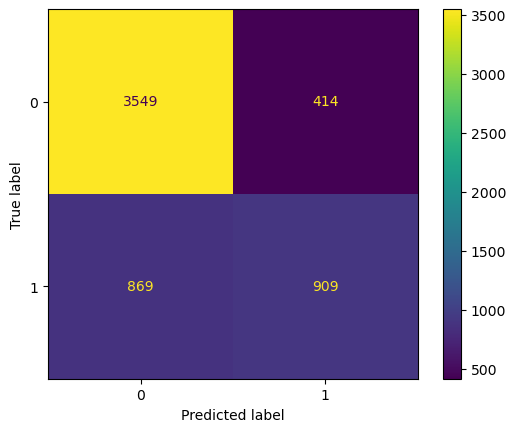

In [63]:
# plotting confusion matrix
plot_confusion_matrix(svm_two, X_test_scaled, y_test);

In [64]:
# Get class predictions
y_pred = svm_two.predict(X_test_scaled)

Let's get the Classification report.

In [65]:
# Classification score
svm_two_report = classification_report(y_test, y_pred)
print(svm_two_report)

              precision    recall  f1-score   support

           0       0.80      0.90      0.85      3963
           1       0.69      0.51      0.59      1778

    accuracy                           0.78      5741
   macro avg       0.75      0.70      0.72      5741
weighted avg       0.77      0.78      0.77      5741



Summary of Models:

|       **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                                                                 |
|:--------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|---------------------------------------------------------------------------------------------------------------------|
| Logistic Regression  | 0.728                  | 0.728             | 0.36       | 0.60          | 0.45         | StandardScaler(), No dimension reduction,  C=1, solver='lbfgs'                                                      |
| Decision Tree 1      | 0.775                  | 0.754             | 0.48       | 0.64          | 0.55         | max_depth=8                                                                                                         |
| Decision Tree 2 (CV) | 0.827                  | 0.72              | 0.56       | 0.55          | 0.55         | max_depth=11, criterion='gini', PCA=16                                                                              |
| Random Forest 1 (CV) | 0.817                  | 0.759             | 0.36       | 0.73          | 0.48         | max_depth=14, criterion='gini', n_estimators=161, max_leaf_nodes=185, PCA=none                                      |
| Random Forest 2      | 0.826                  | 0.773             | 0.42       | 0.73          | 0.53         | max_depth=14, max_leaf_nodes=176, n_estimators=161, criterion='gini'                                                |
| Random Forest 3      | 0.832                  | 0.775             | 0.42       | 0.74          | 0.54         | max_depth=15, criterion='gini', n_estimators=191, max_leaf_nodes=200                                                |
| XGBoost 1 (CV)       | 0.799                  | 0.775             | 0.48       | 0.70          | 0.57         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=23  |
| XGBoost 2            | 0.922                  | 0.798             | 0.57       | 0.72          | 0.64         | default                                                                                                             |
| XGBoost 3            | 0.847                  | 0.798             | 0.56       | 0.73          | 0.63         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=1.6 |
| XGBoost 4            | 0.838                  | 0.795             | 0.54       | 0.73          | 0.62         | booster='gbtree', gamma=5.3, learning_rate=0.04, max_depth=19, min_child_weight=54, n_estimators=140, reg_alpha=1.6 |
| SVM 1 (CV)           | 0.994                  | 0.818             | 0.68       | 0.72          | 0.70         | C=10, gamma=0.315, kernel='rbf', scale='StandardScaler()'                                                           |
| SVM 2                | 0.823                  | 0.777             | 0.51       | 0.69          | 0.59         | C=1, gamma=0.1, kernel='rbf', scale='StandardScaler()'                                                              |



**Summary**
- No overfitting.

- Lower evaluation scores than XGBoost 2 which has been the best model so far. 

#### SVM 3

In [84]:
# instantiate the model
svm_three = SVC(C=7.75, gamma=0.05, kernel='rbf')

# fit the model
svm_three.fit(X_remainder_scaled, y_remainder)

SVC(C=7.75, gamma=0.05)

##### Accuracy Scores

In [85]:
time = timer()
# accuracy scores
print(f'Remainder Set Score: {svm_three.score(X_remainder_scaled, y_remainder)}')
print(f'Test Set Score: {svm_three.score(X_test_scaled, y_test)}')
runtime = timer(time)

Remainder Set Score: 0.839008719596145
Test Set Score: 0.7827904546246298
The runtime of your code is: 0:00:36.907518 (h:mm:ss)


##### Precision and Recall

Let's plot the confusion matrix for the XGBoost model and get prediction for test set.

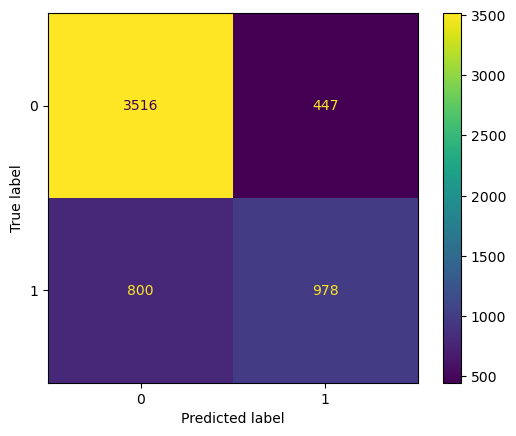

In [86]:
# plotting confusion matrix
plot_confusion_matrix(svm_three, X_test_scaled, y_test);

In [87]:
# Get class predictions
y_pred = svm_three.predict(X_test_scaled)

Let's get the Classification report.

In [88]:
# Classification score
svm_three_report = classification_report(y_test, y_pred)
print(svm_three_report)

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      3963
           1       0.69      0.55      0.61      1778

    accuracy                           0.78      5741
   macro avg       0.75      0.72      0.73      5741
weighted avg       0.77      0.78      0.78      5741



Summary of Models:

|       **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                                                                 |
|:--------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|---------------------------------------------------------------------------------------------------------------------|
| Logistic Regression  | 0.728                  | 0.728             | 0.36       | 0.60          | 0.45         | StandardScaler(), No dimension reduction,  C=1, solver='lbfgs'                                                      |
| Decision Tree 1      | 0.775                  | 0.754             | 0.48       | 0.64          | 0.55         | max_depth=8                                                                                                         |
| Decision Tree 2 (CV) | 0.827                  | 0.72              | 0.56       | 0.55          | 0.55         | max_depth=11, criterion='gini', PCA=16                                                                              |
| Random Forest 1 (CV) | 0.817                  | 0.759             | 0.36       | 0.73          | 0.48         | max_depth=14, criterion='gini', n_estimators=161, max_leaf_nodes=185, PCA=none                                      |
| Random Forest 2      | 0.826                  | 0.773             | 0.42       | 0.73          | 0.53         | max_depth=14, max_leaf_nodes=176, n_estimators=161, criterion='gini'                                                |
| Random Forest 3      | 0.832                  | 0.775             | 0.42       | 0.74          | 0.54         | max_depth=15, criterion='gini', n_estimators=191, max_leaf_nodes=200                                                |
| XGBoost 1 (CV)       | 0.799                  | 0.775             | 0.48       | 0.70          | 0.57         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=23  |
| XGBoost 2            | 0.922                  | 0.798             | 0.57       | 0.72          | 0.64         | default                                                                                                             |
| XGBoost 3            | 0.847                  | 0.798             | 0.56       | 0.73          | 0.63         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=1.6 |
| XGBoost 4            | 0.838                  | 0.795             | 0.54       | 0.73          | 0.62         | booster='gbtree', gamma=5.3, learning_rate=0.04, max_depth=19, min_child_weight=54, n_estimators=140, reg_alpha=1.6 |
| SVM 1 (CV)           | 0.994                  | 0.818             | 0.68       | 0.72          | 0.70         | C=10, gamma=0.315, kernel='rbf', scale='StandardScaler()'                                                           |
| SVM 2                | 0.823                  | 0.777             | 0.51       | 0.69          | 0.59         | C=1, gamma=0.1, kernel='rbf', scale='StandardScaler()'                                                              |
| SVM 3                | 0.839                  | 0.783             | 0.55       | 0.69          | 0.61         | C=7.75, gamma=0.05, kernel='rbf', scale='StandardScaler()'                                                          |


**Summary**
- Very slightly overfitting.

- Slightly improved Accuracy, Recall and F1 score.

Summary of Models:

|       **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                                                                 |
|:--------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|---------------------------------------------------------------------------------------------------------------------|
| Logistic Regression  | 0.728                  | 0.728             | 0.36       | 0.60          | 0.45         | StandardScaler(), No dimension reduction,  C=1, solver='lbfgs'                                                      |
| Decision Tree 1      | 0.775                  | 0.754             | 0.48       | 0.64          | 0.55         | max_depth=8                                                                                                         |
| Decision Tree 2 (CV) | 0.827                  | 0.72              | 0.56       | 0.55          | 0.55         | max_depth=11, criterion='gini', PCA=16                                                                              |
| Random Forest 1 (CV) | 0.817                  | 0.759             | 0.36       | 0.73          | 0.48         | max_depth=14, criterion='gini', n_estimators=161, max_leaf_nodes=185, PCA=none                                      |
| Random Forest 2      | 0.826                  | 0.773             | 0.42       | 0.73          | 0.53         | max_depth=14, max_leaf_nodes=176, n_estimators=161, criterion='gini'                                                |
| Random Forest 3      | 0.832                  | 0.775             | 0.42       | 0.74          | 0.54         | max_depth=15, criterion='gini', n_estimators=191, max_leaf_nodes=200                                                |
| XGBoost 1 (CV)       | 0.799                  | 0.775             | 0.48       | 0.70          | 0.57         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=23  |
| XGBoost 2            | 0.922                  | 0.798             | 0.57       | 0.72          | 0.64         | default                                                                                                             |
| XGBoost 3            | 0.847                  | 0.798             | 0.56       | 0.73          | 0.63         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=1.6 |
| XGBoost 4            | 0.838                  | 0.795             | 0.54       | 0.73          | 0.62         | booster='gbtree', gamma=5.3, learning_rate=0.04, max_depth=19, min_child_weight=54, n_estimators=140, reg_alpha=1.6 |
| SVM 1 (CV)           | 0.994                  | 0.818             | 0.68       | 0.72          | 0.70         | C=10, gamma=0.315, kernel='rbf', scale='StandardScaler()'                                                           |
| SVM 2                | 0.823                  | 0.777             | 0.51       | 0.69          | 0.59         | C=1, gamma=0.1, kernel='rbf', scale='StandardScaler()'                                                              |
| SVM 3                | 0.839                  | 0.783             | 0.55       | 0.69          | 0.61         | C=7.75, gamma=0.05, kernel='rbf', scale='StandardScaler()'                                                          |


**Summary**
- Very slightly overfitting.

- Slightly improved Accuracy, Recall and F1 score.

-------

### Neural Networks

#### Neural 1

Let's start by creating a basic neural network consisting of 5 hidden layers with 10 units each and a Batch Normalization layer after each hidden layer. The batch Normalization layer should help help avoid overfit and improve overall performance. Since we are trying to make binary clasification predictions, our output layer (for all neural network models) will consist of a single 'sigmoid' activated node. In addition, I will train the neural network for 1000 epochs and pass scaled training and validation data to it. 

In [119]:
# Create a new sequential model
neural_one = keras.Sequential()

# Declare the hidden layers
neural_one.add(layers.Dense(10, activation="relu"))
neural_one.add(layers.BatchNormalization())

neural_one.add(layers.Dense(10, activation="relu"))
neural_one.add(layers.BatchNormalization())

neural_one.add(layers.Dense(10, activation="relu"))
neural_one.add(layers.BatchNormalization())

neural_one.add(layers.Dense(10, activation="relu"))
neural_one.add(layers.BatchNormalization())

neural_one.add(layers.Dense(10, activation="relu"))
neural_one.add(layers.BatchNormalization())


# Declare the output layer
neural_one.add(layers.Dense(1, activation="sigmoid"))

neural_one.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()]
)

In [120]:
time = timer()
history = neural_one.fit(X_train_scaled, y_train, epochs=1000, verbose=1, validation_data=(X_validation_scaled, y_validation))
runtime = timer(time)

Epoch 1/1000
539/539 [==============================] - 1s 2ms/step - loss: 0.6273 - binary_accuracy: 0.6538 - val_loss: 0.5774 - val_binary_accuracy: 0.6882
Epoch 2/1000
539/539 [==============================] - 1s 2ms/step - loss: 0.5767 - binary_accuracy: 0.6947 - val_loss: 0.5647 - val_binary_accuracy: 0.7049
Epoch 3/1000
539/539 [==============================] - 1s 1ms/step - loss: 0.5664 - binary_accuracy: 0.7015 - val_loss: 0.5550 - val_binary_accuracy: 0.7121
Epoch 4/1000
539/539 [==============================] - 1s 2ms/step - loss: 0.5593 - binary_accuracy: 0.7078 - val_loss: 0.5468 - val_binary_accuracy: 0.7247
Epoch 5/1000
539/539 [==============================] - 1s 2ms/step - loss: 0.5546 - binary_accuracy: 0.7147 - val_loss: 0.5411 - val_binary_accuracy: 0.7287
Epoch 6/1000
539/539 [==============================] - 1s 2ms/step - loss: 0.5476 - binary_accuracy: 0.7205 - val_loss: 0.5364 - val_binary_accuracy: 0.7337
Epoch 7/1000
539/539 [==============================

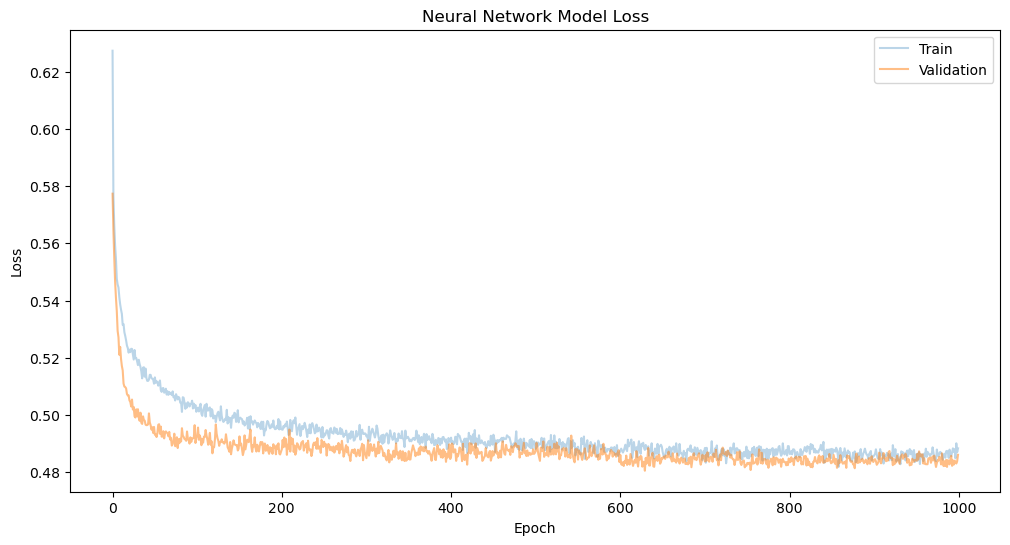

In [131]:
# plot to check how the network optimized loss
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], alpha=0.3)
plt.plot(history.history['val_loss'], alpha=0.5)
plt.title('Neural Network Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

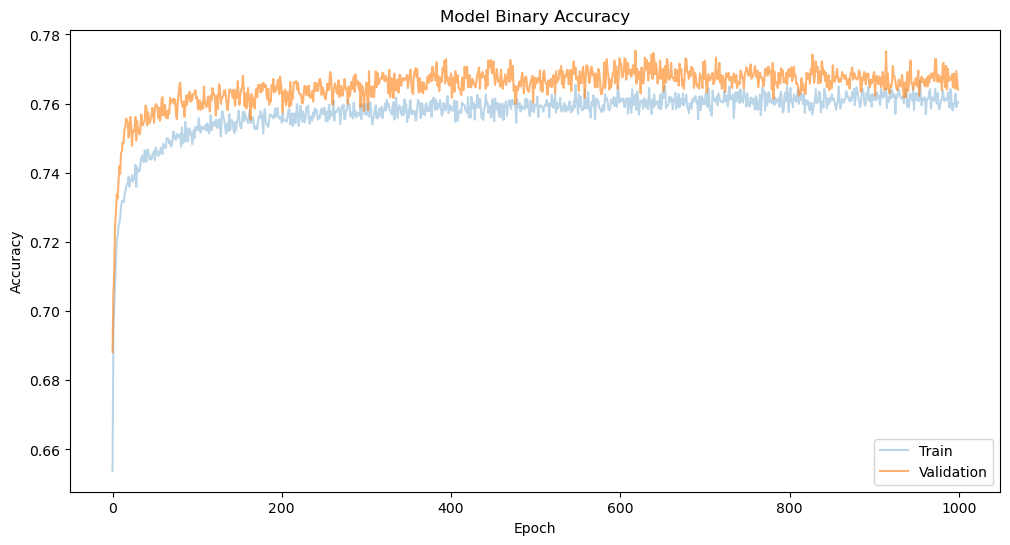

In [140]:
# plot to check binary accuracy
plt.figure(figsize=(12,6))
plt.plot(history.history['binary_accuracy'], alpha=0.3)
plt.plot(history.history['val_binary_accuracy'], alpha=0.6)
plt.title('Model Binary Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [141]:
# sanity check for metric names
neural_one.metrics_names

['loss', 'binary_accuracy']

In [144]:
# Evaluate the network
train_accuracy = history.history[neural_one.metrics_names[1]][-1]
result = neural_one.evaluate(X_test_scaled,y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

Train Accuracy: 0.7602
Test Accuracy: 0.7565


In [134]:
# Get class predictions (soft predictions)
y_pred = neural_one.predict(X_test_scaled)

Predictions for neural network models are probabilistic in nature. To convert them to hard predictions, we can classify soft predictions under 0.5 as 0, and over 0.5 as 1. We chose these values since the sigmoid function gives output between 0 and 1. We can then use the hard (boolean) predictions to calculate Precision and Recall for the test set.

___Note: We can prioritize high Recall or high Precision by changing the threshold values for soft predictions. For higher Recall, threshold values should be set to less than 0.5.___

In [135]:
y_pred_bool = (y_pred>0.5)
y_pred_bool

array([[ True],
       [ True],
       [False],
       ...,
       [False],
       [False],
       [ True]])

Let's get the classification report. 

In [136]:
# Classification score
neural_one_report = classification_report(y_test, y_pred_bool)
print(neural_one_report)

              precision    recall  f1-score   support

           0       0.79      0.89      0.83      3963
           1       0.65      0.46      0.54      1778

    accuracy                           0.76      5741
   macro avg       0.72      0.67      0.69      5741
weighted avg       0.74      0.76      0.74      5741



Summary of Models:

|       **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                                                                 |
|:--------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|---------------------------------------------------------------------------------------------------------------------|
| Logistic Regression  | 0.728                  | 0.728             | 0.36       | 0.60          | 0.45         | StandardScaler(), No dimension reduction,  C=1, solver='lbfgs'                                                      |
| Decision Tree 1      | 0.775                  | 0.754             | 0.48       | 0.64          | 0.55         | max_depth=8                                                                                                         |
| Decision Tree 2 (CV) | 0.827                  | 0.72              | 0.56       | 0.55          | 0.55         | max_depth=11, criterion='gini', PCA=16                                                                              |
| Random Forest 1 (CV) | 0.817                  | 0.759             | 0.36       | 0.73          | 0.48         | max_depth=14, criterion='gini', n_estimators=161, max_leaf_nodes=185, PCA=none                                      |
| Random Forest 2      | 0.826                  | 0.773             | 0.42       | 0.73          | 0.53         | max_depth=14, max_leaf_nodes=176, n_estimators=161, criterion='gini'                                                |
| Random Forest 3      | 0.832                  | 0.775             | 0.42       | 0.74          | 0.54         | max_depth=15, criterion='gini', n_estimators=191, max_leaf_nodes=200                                                |
| XGBoost 1 (CV)       | 0.799                  | 0.775             | 0.48       | 0.70          | 0.57         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=23  |
| XGBoost 2            | 0.922                  | 0.798             | 0.57       | 0.72          | 0.64         | default                                                                                                             |
| XGBoost 3            | 0.847                  | 0.798             | 0.56       | 0.73          | 0.63         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=1.6 |
| XGBoost 4            | 0.838                  | 0.795             | 0.54       | 0.73          | 0.62         | booster='gbtree', gamma=5.3, learning_rate=0.04, max_depth=19, min_child_weight=54, n_estimators=140, reg_alpha=1.6 |
| SVM 1 (CV)           | 0.994                  | 0.818             | 0.68       | 0.72          | 0.70         | C=10, gamma=0.315, kernel='rbf', scale='StandardScaler()'                                                           |
| SVM 2                | 0.823                  | 0.777             | 0.51       | 0.69          | 0.59         | C=1, gamma=0.1, kernel='rbf', scale='StandardScaler()'                                                              |
| SVM 3                | 0.839                  | 0.783             | 0.55       | 0.69          | 0.61         | C=7.75, gamma=0.05, kernel='rbf', scale='StandardScaler()'                                                          |
| Neural 1             | 0.760                  | 0.757             | 0.46       | 0.65          | 0.54         | Layers=5x10relu w/ BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy               |


**Summary**
- No overfitting issue.

- All evaluation metrics lower than XGBoost 3 model. 

#### Neural 2


In [145]:
# Create a new sequential model
neural_two = keras.Sequential()

# Declare the hidden layers
# First 5 layers
neural_two.add(layers.Dense(20, activation="relu"))
neural_two.add(layers.BatchNormalization())
neural_two.add(layers.Dense(20, activation="relu"))
neural_two.add(layers.BatchNormalization())
neural_two.add(layers.Dense(20, activation="relu"))
neural_two.add(layers.BatchNormalization())
neural_two.add(layers.Dense(20, activation="relu"))
neural_two.add(layers.BatchNormalization())
neural_two.add(layers.Dense(20, activation="relu"))
neural_two.add(layers.BatchNormalization())
# Final 5 layers
neural_two.add(layers.Dense(20, activation="relu"))
neural_two.add(layers.BatchNormalization())
neural_two.add(layers.Dense(20, activation="relu"))
neural_two.add(layers.BatchNormalization())
neural_two.add(layers.Dense(20, activation="relu"))
neural_two.add(layers.BatchNormalization())
neural_two.add(layers.Dense(20, activation="relu"))
neural_two.add(layers.BatchNormalization())
neural_two.add(layers.Dense(20, activation="relu"))
neural_two.add(layers.BatchNormalization())

# Declare the output layer
neural_two.add(layers.Dense(1, activation="sigmoid"))

neural_two.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall()]
)

In [146]:
time = timer()
history = neural_two.fit(X_train_scaled, y_train, epochs=1000, verbose=1, validation_data=(X_validation_scaled, y_validation))
runtime = timer(time)

Epoch 1/1000
539/539 [==============================] - 2s 4ms/step - loss: 0.6307 - binary_accuracy: 0.6614 - precision_1: 0.3851 - recall_1: 0.1563 - val_loss: 0.5957 - val_binary_accuracy: 0.6895 - val_precision_1: 0.4941 - val_recall_1: 0.1187
Epoch 2/1000
539/539 [==============================] - 1s 2ms/step - loss: 0.5946 - binary_accuracy: 0.6930 - precision_1: 0.5192 - recall_1: 0.1189 - val_loss: 0.5799 - val_binary_accuracy: 0.6939 - val_precision_1: 0.5303 - val_recall_1: 0.0995
Epoch 3/1000
539/539 [==============================] - 1s 3ms/step - loss: 0.5822 - binary_accuracy: 0.6952 - precision_1: 0.5259 - recall_1: 0.1599 - val_loss: 0.5650 - val_binary_accuracy: 0.7016 - val_precision_1: 0.5556 - val_recall_1: 0.1812
Epoch 4/1000
539/539 [==============================] - 1s 2ms/step - loss: 0.5699 - binary_accuracy: 0.6978 - precision_1: 0.5304 - recall_1: 0.2123 - val_loss: 0.5593 - val_binary_accuracy: 0.7069 - val_precision_1: 0.6081 - val_recall_1: 0.1500
Epoch 5/

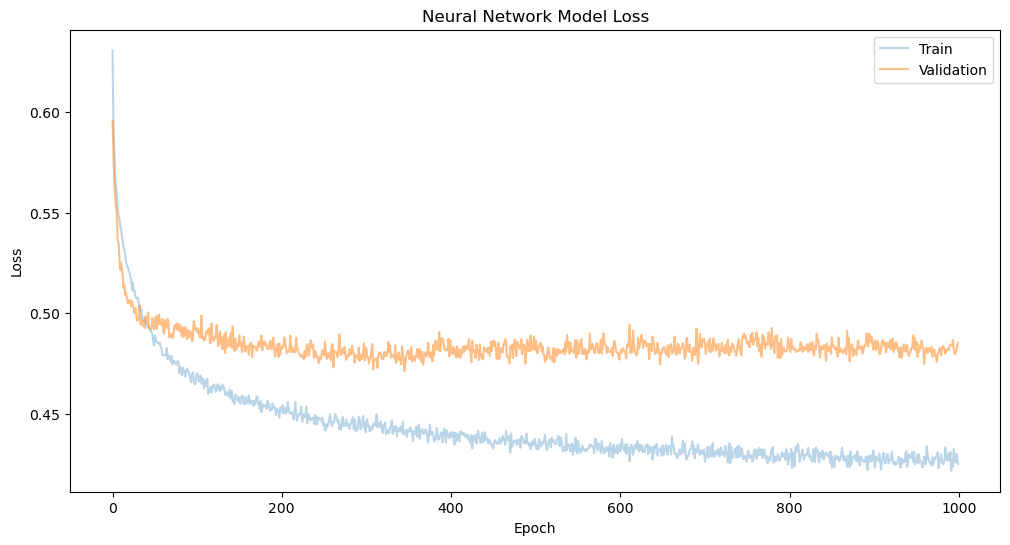

In [147]:
# plot to check how the network optimized loss
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], alpha=0.3)
plt.plot(history.history['val_loss'], alpha=0.5)
plt.title('Neural Network Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

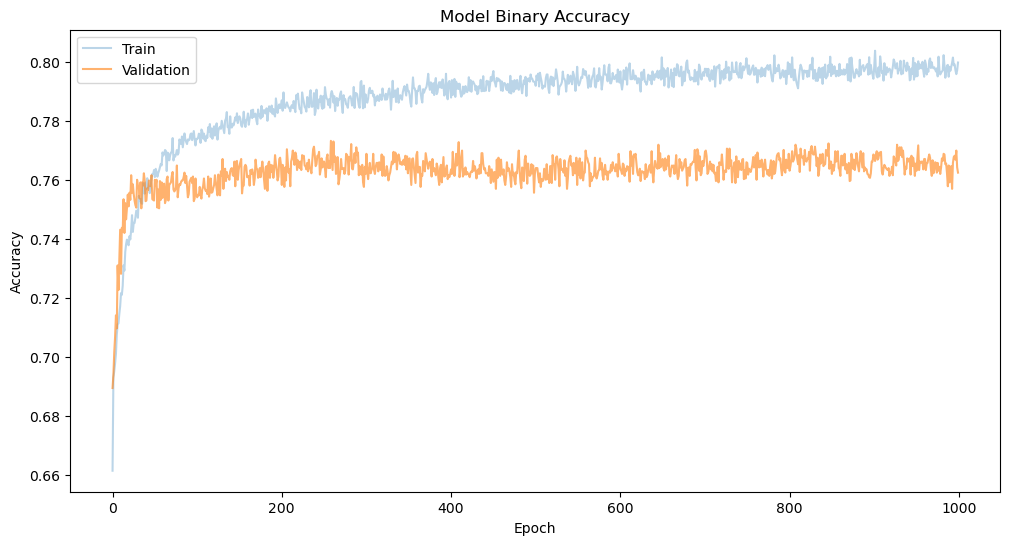

In [148]:
# plot to check binary accuracy
plt.figure(figsize=(12,6))
plt.plot(history.history['binary_accuracy'], alpha=0.3)
plt.plot(history.history['val_binary_accuracy'], alpha=0.6)
plt.title('Model Binary Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [150]:
# sanity check for metric names
neural_two.metrics_names

['loss', 'binary_accuracy', 'precision_1', 'recall_1']

In [151]:
# Evaluate the network
train_accuracy = history.history[neural_two.metrics_names[1]][-1]
recall = history.history[neural_two.metrics_names[3]][-1]
precision = history.history[neural_two.metrics_names[2]][-1]
result = neural_two.evaluate(X_test_scaled,y_test, verbose=2)

# accuracy
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")
# precision
print(f"Train Precision: {precision:.4f}")
print(f"Test Precision: {result[2]:.4f}")
# recall 
print(f"Train Recall: {recall:.4f}")
print(f"Test Recall: {result[3]:.4f}")

180/180 - 0s - loss: 0.4843 - binary_accuracy: 0.7690 - precision_1: 0.6601 - recall_1: 0.5242
Train Accuracy: 0.7999
Test Accuracy: 0.7690
Train Precision: 0.7072
Test Precision: 0.6601
Train Recall: 0.6038
Test Recall: 0.5242


In [152]:
# Get class predictions (soft predictions)
y_pred = neural_two.predict(X_test_scaled)

In [153]:
y_pred_bool = (y_pred>0.5)
y_pred_bool

array([[ True],
       [ True],
       [False],
       ...,
       [False],
       [ True],
       [ True]])

Let's get the classification report. 

In [154]:
# Classification score
neural_two_report = classification_report(y_test, y_pred_bool)
print(neural_two_report)

              precision    recall  f1-score   support

           0       0.80      0.88      0.84      3963
           1       0.66      0.52      0.58      1778

    accuracy                           0.77      5741
   macro avg       0.73      0.70      0.71      5741
weighted avg       0.76      0.77      0.76      5741



Summary of Models:

|       **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                                                                 |
|:--------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|---------------------------------------------------------------------------------------------------------------------|
| Logistic Regression  | 0.728                  | 0.728             | 0.36       | 0.60          | 0.45         | StandardScaler(), No dimension reduction,  C=1, solver='lbfgs'                                                      |
| Decision Tree 1      | 0.775                  | 0.754             | 0.48       | 0.64          | 0.55         | max_depth=8                                                                                                         |
| Decision Tree 2 (CV) | 0.827                  | 0.72              | 0.56       | 0.55          | 0.55         | max_depth=11, criterion='gini', PCA=16                                                                              |
| Random Forest 1 (CV) | 0.817                  | 0.759             | 0.36       | 0.73          | 0.48         | max_depth=14, criterion='gini', n_estimators=161, max_leaf_nodes=185, PCA=none                                      |
| Random Forest 2      | 0.826                  | 0.773             | 0.42       | 0.73          | 0.53         | max_depth=14, max_leaf_nodes=176, n_estimators=161, criterion='gini'                                                |
| Random Forest 3      | 0.832                  | 0.775             | 0.42       | 0.74          | 0.54         | max_depth=15, criterion='gini', n_estimators=191, max_leaf_nodes=200                                                |
| XGBoost 1 (CV)       | 0.799                  | 0.775             | 0.48       | 0.70          | 0.57         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=23  |
| XGBoost 2            | 0.922                  | 0.798             | 0.57       | 0.72          | 0.64         | default                                                                                                             |
| XGBoost 3            | 0.847                  | 0.798             | 0.56       | 0.73          | 0.63         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=1.6 |
| XGBoost 4            | 0.838                  | 0.795             | 0.54       | 0.73          | 0.62         | booster='gbtree', gamma=5.3, learning_rate=0.04, max_depth=19, min_child_weight=54, n_estimators=140, reg_alpha=1.6 |
| SVM 1 (CV)           | 0.994                  | 0.818             | 0.68       | 0.72          | 0.70         | C=10, gamma=0.315, kernel='rbf', scale='StandardScaler()'                                                           |
| SVM 2                | 0.823                  | 0.777             | 0.51       | 0.69          | 0.59         | C=1, gamma=0.1, kernel='rbf', scale='StandardScaler()'                                                              |
| SVM 3                | 0.839                  | 0.783             | 0.55       | 0.69          | 0.61         | C=7.75, gamma=0.05, kernel='rbf', scale='StandardScaler()'                                                          |
| Neural 1             | 0.760                  | 0.757             | 0.46       | 0.65          | 0.54         | Layers=5x10relu w/ BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy               |
| Neural 2             | 0.800                  | 0.769             | 0.52       | 0.66          | 0.58         | Layers=10x20relu w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy               |


#### Neural 3

We will construct a model with 5 layers and 32 nodes with 'relu' activation. The output layer will have a single 'sigmoid' node. 


In [182]:
# Create a new sequential model
neural_three = keras.Sequential()

# Declare the hidden layers
# 5 layers 32 nodes per layer
neural_three.add(layers.Dense(32, activation="relu"))
neural_three.add(layers.BatchNormalization())
neural_three.add(layers.Dense(32, activation="relu"))
neural_three.add(layers.BatchNormalization())
neural_three.add(layers.Dense(32, activation="relu"))
neural_three.add(layers.BatchNormalization())
neural_three.add(layers.Dense(32, activation="relu"))
neural_three.add(layers.BatchNormalization())
neural_three.add(layers.Dense(32, activation="relu"))
neural_three.add(layers.BatchNormalization())


# Declare the output layer
neural_three.add(layers.Dense(1, activation="sigmoid"))

neural_three.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall()]
)

In [183]:
time = timer()
history = neural_three.fit(X_train_scaled, y_train, epochs=1000, verbose=1, validation_data=(X_validation_scaled, y_validation))
runtime = timer(time)

Epoch 1/1000
539/539 [==============================] - 1s 2ms/step - loss: 0.6024 - binary_accuracy: 0.6788 - precision_4: 0.4746 - recall_4: 0.3460 - val_loss: 0.5435 - val_binary_accuracy: 0.7247 - val_precision_4: 0.5768 - val_recall_4: 0.4165
Epoch 2/1000
539/539 [==============================] - 1s 2ms/step - loss: 0.5572 - binary_accuracy: 0.7140 - precision_4: 0.5651 - recall_4: 0.3318 - val_loss: 0.5262 - val_binary_accuracy: 0.7302 - val_precision_4: 0.5932 - val_recall_4: 0.4094
Epoch 3/1000
539/539 [==============================] - 1s 2ms/step - loss: 0.5448 - binary_accuracy: 0.7207 - precision_4: 0.5781 - recall_4: 0.3638 - val_loss: 0.5170 - val_binary_accuracy: 0.7386 - val_precision_4: 0.6090 - val_recall_4: 0.4350
Epoch 4/1000
539/539 [==============================] - 1s 2ms/step - loss: 0.5341 - binary_accuracy: 0.7332 - precision_4: 0.6072 - recall_4: 0.3924 - val_loss: 0.5155 - val_binary_accuracy: 0.7410 - val_precision_4: 0.6366 - val_recall_4: 0.3810
Epoch 5/

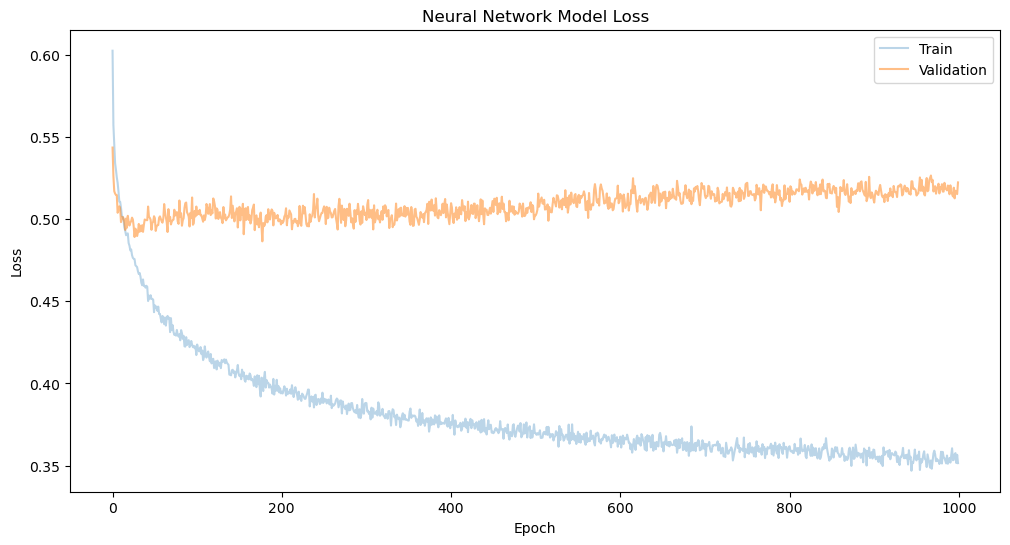

In [191]:
# plot to check how the network optimized loss
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], alpha=0.3)
plt.plot(history.history['val_loss'], alpha=0.5)
plt.title('Neural Network Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.ylim(0.4, 0.8)
plt.legend(['Train', 'Validation'])
plt.show()

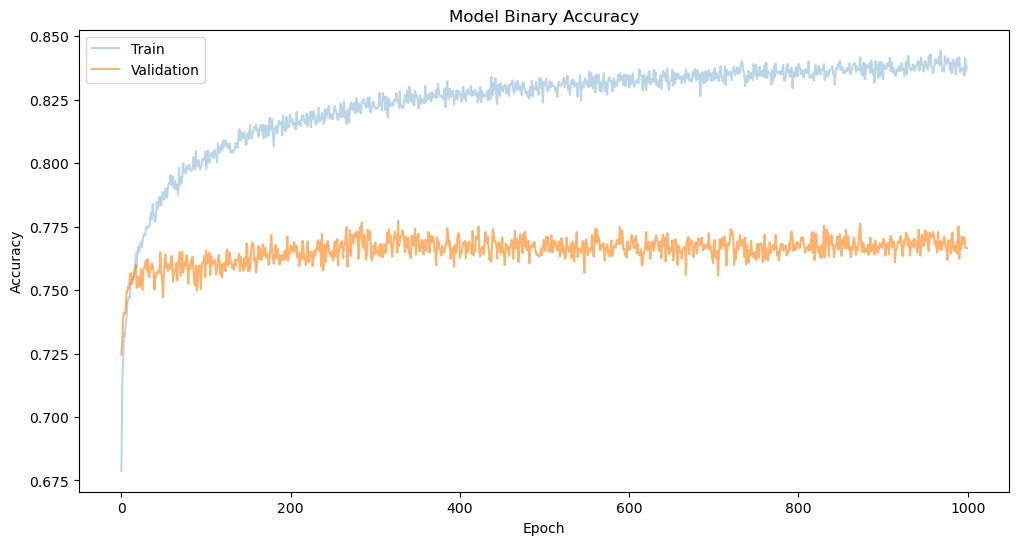

In [192]:
# plot to check binary accuracy
plt.figure(figsize=(12,6))
plt.plot(history.history['binary_accuracy'], alpha=0.3)
plt.plot(history.history['val_binary_accuracy'], alpha=0.6)
plt.title('Model Binary Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [193]:
# sanity check for metric names
neural_three.metrics_names

['loss', 'binary_accuracy', 'precision_4', 'recall_4']

In [194]:
# Evaluate the network
train_accuracy = history.history[neural_three.metrics_names[1]][-1]
recall = history.history[neural_three.metrics_names[3]][-1]
precision = history.history[neural_three.metrics_names[2]][-1]
result = neural_three.evaluate(X_test_scaled,y_test, verbose=2)

# accuracy
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")
# precision
print(f"Train Precision: {precision:.4f}")
print(f"Test Precision: {result[2]:.4f}")
# recall 
print(f"Train Recall: {recall:.4f}")
print(f"Test Recall: {result[3]:.4f}")

180/180 - 0s - loss: 0.5167 - binary_accuracy: 0.7687 - precision_4: 0.6341 - recall_4: 0.5984
Train Accuracy: 0.8378
Test Accuracy: 0.7687
Train Precision: 0.7599
Test Precision: 0.6341
Train Recall: 0.6961
Test Recall: 0.5984


In [195]:
# Get class predictions (soft predictions)
y_pred = neural_three.predict(X_test_scaled)

In [196]:
y_pred_bool = (y_pred>0.5)
y_pred_bool

array([[ True],
       [ True],
       [False],
       ...,
       [False],
       [ True],
       [ True]])

Let's get the classification report. 

In [197]:
# Classification score
neural_three_report = classification_report(y_test, y_pred_bool)
print(neural_three_report)

              precision    recall  f1-score   support

           0       0.82      0.85      0.83      3963
           1       0.63      0.60      0.62      1778

    accuracy                           0.77      5741
   macro avg       0.73      0.72      0.73      5741
weighted avg       0.77      0.77      0.77      5741



Summary of Models:

|       **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                                                                                  |
|:--------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|--------------------------------------------------------------------------------------------------------------------------------------|
| Logistic Regression  | 0.728                  | 0.728             | 0.36       | 0.60          | 0.45         | StandardScaler(), No dimension reduction,  C=1, solver='lbfgs'                                                                       |
| Decision Tree 1      | 0.775                  | 0.754             | 0.48       | 0.64          | 0.55         | max_depth=8                                                                                                                          |
| Decision Tree 2 (CV) | 0.827                  | 0.72              | 0.56       | 0.55          | 0.55         | max_depth=11, criterion='gini', PCA=16                                                                                               |
| Random Forest 1 (CV) | 0.817                  | 0.759             | 0.36       | 0.73          | 0.48         | max_depth=14, criterion='gini', n_estimators=161, max_leaf_nodes=185, PCA=none                                                       |
| Random Forest 2      | 0.826                  | 0.773             | 0.42       | 0.73          | 0.53         | max_depth=14, max_leaf_nodes=176, n_estimators=161, criterion='gini'                                                                 |
| Random Forest 3      | 0.832                  | 0.775             | 0.42       | 0.74          | 0.54         | max_depth=15, criterion='gini', n_estimators=191, max_leaf_nodes=200                                                                 |
| XGBoost 1 (CV)       | 0.799                  | 0.775             | 0.48       | 0.70          | 0.57         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=23                   |
| XGBoost 2            | 0.922                  | 0.798             | 0.57       | 0.72          | 0.64         | default                                                                                                                              |
| XGBoost 3            | 0.847                  | 0.798             | 0.56       | 0.73          | 0.63         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=1.6                  |
| XGBoost 4            | 0.838                  | 0.795             | 0.54       | 0.73          | 0.62         | booster='gbtree', gamma=5.3, learning_rate=0.04, max_depth=19, min_child_weight=54, n_estimators=140, reg_alpha=1.6                  |
| SVM 1 (CV)           | 0.994                  | 0.818             | 0.68       | 0.72          | 0.70         | C=10, gamma=0.315, kernel='rbf', scale='StandardScaler()'                                                                            |
| SVM 2                | 0.823                  | 0.777             | 0.51       | 0.69          | 0.59         | C=1, gamma=0.1, kernel='rbf', scale='StandardScaler()'                                                                               |
| SVM 3                | 0.839                  | 0.783             | 0.55       | 0.69          | 0.61         | C=7.75, gamma=0.05, kernel='rbf', scale='StandardScaler()'                                                                           |
| Neural 1             | 0.760                  | 0.757             | 0.46       | 0.65          | 0.54         | Layers=5x10relu w/ BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                                |
| Neural 2             | 0.800                  | 0.769             | 0.52       | 0.66          | 0.58         | Layers=10x20relu w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                                |
| Neural 3             | 0.838                  | 0.769             | 0.60       | 0.63          | 0.62         | Layers=5x32relu, w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                                |

**Summary**
- Overfitting.

- Significant improvement in Recall and F1 scores as compared to Neural 2.
- Slight reduction in Precision score as compared to Neural 2. 

#### Neural 4

Let's attempt to control overfitting found in Neural3 while trying to maintain or better the evaluation metrics scores.

We are going to achieve this by first, reducing the number of epochs we allow the model to train for. From the loss and accuracy plots of Neural 3 we can see that training the model beyond ~200 epochs seems to have minimal effect on validation loss and accuracy. Second, we will introduce a L1 regularizer to further control overfitting and improve the model's generalization abilities.  

In [114]:
# Create a new sequential model
neural_four = keras.Sequential()

# L1 regularizer
regularizer = keras.regularizers.L1(l1=0.001)
# Declare the hidden layers
# 5 layers 32 nodes per layer
neural_four.add(layers.Dense(32, activation="relu"))
neural_four.add(layers.BatchNormalization())
neural_four.add(layers.Dense(32, activation="relu"))
neural_four.add(layers.BatchNormalization())
neural_four.add(layers.Dense(32, activation="relu"))
neural_four.add(layers.BatchNormalization())
neural_four.add(layers.Dense(32, activation="relu"))
neural_four.add(layers.BatchNormalization())
neural_four.add(layers.Dense(32, activation="relu"))
neural_four.add(layers.BatchNormalization())


# Declare the output layer
neural_four.add(layers.Dense(1, activation="sigmoid"))

neural_four.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall()]
)

In [115]:
time = timer()
history = neural_four.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_validation_scaled, y_validation))
runtime = timer(time)

Epoch 1/250
539/539 [==============================] - 2s 3ms/step - loss: 0.6027 - binary_accuracy: 0.6768 - precision_7: 0.4673 - recall_7: 0.3117 - val_loss: 0.5495 - val_binary_accuracy: 0.7225 - val_precision_7: 0.6083 - val_recall_7: 0.2914
Epoch 2/250
539/539 [==============================] - 1s 2ms/step - loss: 0.5579 - binary_accuracy: 0.7082 - precision_7: 0.5531 - recall_7: 0.3011 - val_loss: 0.5359 - val_binary_accuracy: 0.7331 - val_precision_7: 0.6032 - val_recall_7: 0.4030
Epoch 3/250
539/539 [==============================] - 1s 2ms/step - loss: 0.5447 - binary_accuracy: 0.7220 - precision_7: 0.5868 - recall_7: 0.3462 - val_loss: 0.5234 - val_binary_accuracy: 0.7392 - val_precision_7: 0.6228 - val_recall_7: 0.4001
Epoch 4/250
539/539 [==============================] - 1s 2ms/step - loss: 0.5366 - binary_accuracy: 0.7274 - precision_7: 0.5977 - recall_7: 0.3658 - val_loss: 0.5198 - val_binary_accuracy: 0.7454 - val_precision_7: 0.6260 - val_recall_7: 0.4414
Epoch 5/250


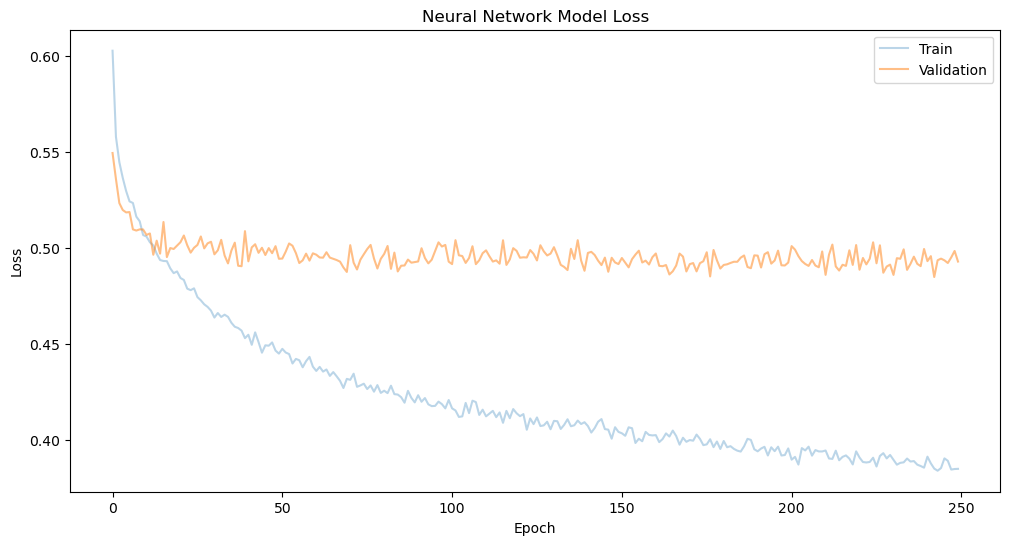

In [116]:
# plot to check how the network optimized loss
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], alpha=0.3)
plt.plot(history.history['val_loss'], alpha=0.5)
plt.title('Neural Network Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.ylim(0.4, 0.8)
plt.legend(['Train', 'Validation'])
plt.show()

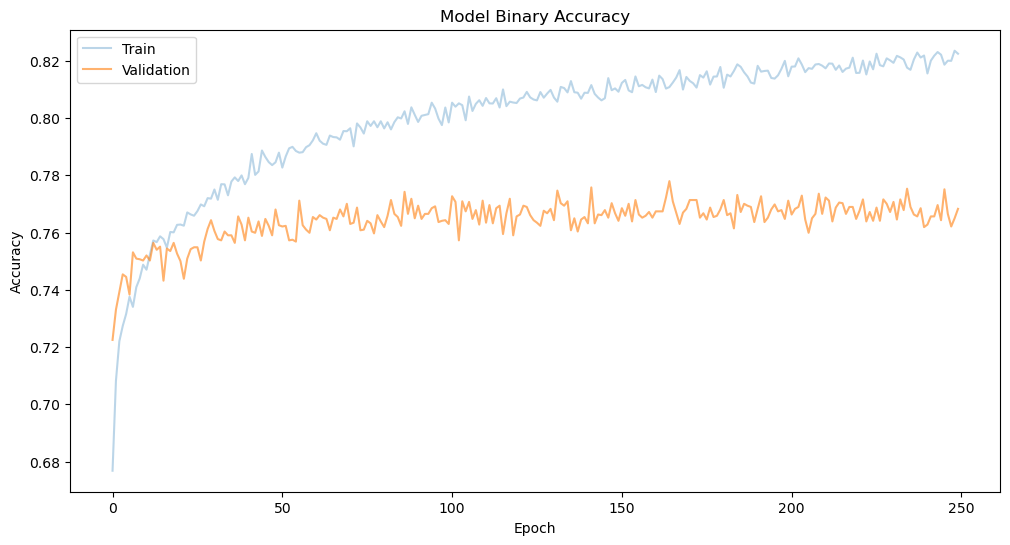

In [117]:
# plot to check binary accuracy
plt.figure(figsize=(12,6))
plt.plot(history.history['binary_accuracy'], alpha=0.3)
plt.plot(history.history['val_binary_accuracy'], alpha=0.6)
plt.title('Model Binary Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [118]:
# sanity check for metric names
neural_four.metrics_names

['loss', 'binary_accuracy', 'precision_7', 'recall_7']

In [119]:
# Evaluate the network
train_accuracy = history.history[neural_four.metrics_names[1]][-1]
recall = history.history[neural_four.metrics_names[3]][-1]
precision = history.history[neural_four.metrics_names[2]][-1]
result = neural_four.evaluate(X_test_scaled,y_test, verbose=2)

# accuracy
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")
# precision
print(f"Train Precision: {precision:.4f}")
print(f"Test Precision: {result[2]:.4f}")
# recall 
print(f"Train Recall: {recall:.4f}")
print(f"Test Recall: {result[3]:.4f}")

180/180 - 0s - loss: 0.4941 - binary_accuracy: 0.7723 - precision_7: 0.6473 - recall_7: 0.5821
Train Accuracy: 0.8225
Test Accuracy: 0.7723
Train Precision: 0.7398
Test Precision: 0.6473
Train Recall: 0.6581
Test Recall: 0.5821


In [120]:
# Get class predictions (soft predictions)
y_pred = neural_four.predict(X_test_scaled)

In [121]:
y_pred_bool = (y_pred>0.5)
y_pred_bool

array([[ True],
       [False],
       [False],
       ...,
       [False],
       [False],
       [ True]])

Let's get the classification report. 

In [122]:
# Classification score
neural_four_report = classification_report(y_test, y_pred_bool)
print(neural_four_report)

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      3963
           1       0.65      0.58      0.61      1778

    accuracy                           0.77      5741
   macro avg       0.73      0.72      0.73      5741
weighted avg       0.77      0.77      0.77      5741



Summary of Models:

|       **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                                                                                  |
|:--------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|--------------------------------------------------------------------------------------------------------------------------------------|
| Logistic Regression  | 0.728                  | 0.728             | 0.36       | 0.60          | 0.45         | StandardScaler(), No dimension reduction,  C=1, solver='lbfgs'                                                                       |
| Decision Tree 1      | 0.775                  | 0.754             | 0.48       | 0.64          | 0.55         | max_depth=8                                                                                                                          |
| Decision Tree 2 (CV) | 0.827                  | 0.72              | 0.56       | 0.55          | 0.55         | max_depth=11, criterion='gini', PCA=16                                                                                               |
| Random Forest 1 (CV) | 0.817                  | 0.759             | 0.36       | 0.73          | 0.48         | max_depth=14, criterion='gini', n_estimators=161, max_leaf_nodes=185, PCA=none                                                       |
| Random Forest 2      | 0.826                  | 0.773             | 0.42       | 0.73          | 0.53         | max_depth=14, max_leaf_nodes=176, n_estimators=161, criterion='gini'                                                                 |
| Random Forest 3      | 0.832                  | 0.775             | 0.42       | 0.74          | 0.54         | max_depth=15, criterion='gini', n_estimators=191, max_leaf_nodes=200                                                                 |
| XGBoost 1 (CV)       | 0.799                  | 0.775             | 0.48       | 0.70          | 0.57         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=23                   |
| XGBoost 2            | 0.922                  | 0.798             | 0.57       | 0.72          | 0.64         | default                                                                                                                              |
| XGBoost 3            | 0.847                  | 0.798             | 0.56       | 0.73          | 0.63         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=1.6                  |
| XGBoost 4            | 0.838                  | 0.795             | 0.54       | 0.73          | 0.62         | booster='gbtree', gamma=5.3, learning_rate=0.04, max_depth=19, min_child_weight=54, n_estimators=140, reg_alpha=1.6                  |
| SVM 1 (CV)           | 0.994                  | 0.818             | 0.68       | 0.72          | 0.70         | C=10, gamma=0.315, kernel='rbf', scale='StandardScaler()'                                                                            |
| SVM 2                | 0.823                  | 0.777             | 0.51       | 0.69          | 0.59         | C=1, gamma=0.1, kernel='rbf', scale='StandardScaler()'                                                                               |
| SVM 3                | 0.839                  | 0.783             | 0.55       | 0.69          | 0.61         | C=7.75, gamma=0.05, kernel='rbf', scale='StandardScaler()'                                                                           |
| Neural 1             | 0.760                  | 0.757             | 0.46       | 0.65          | 0.54         | Layers=5x10relu w/ BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                                |
| Neural 2             | 0.800                  | 0.769             | 0.52       | 0.66          | 0.58         | Layers=10x20relu w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                                |
| Neural 3             | 0.838                  | 0.769             | 0.60       | 0.63          | 0.62         | Layers=5x32relu, w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                                |
| Neural 4             | 0.823                  | 0.772             | 0.58       | 0.65          | 0.61         | Layers=5x32relu, w/BatchNormalization, w/L1regularizer=0.001, Output=sigmoid, epochs=250, Opt=Adam, loss=binarycrossentropy          |

**Summary**
- No overfitting.

- Minimal differences in evaluation metric scores from Neural 3.

#### Neural 5

We will construct a model with 15 layers and 16 nodes with 'relu' activation. The output layer will have a single 'sigmoid' node. 


In [225]:
# Create a new sequential model
neural_five = keras.Sequential()

# Declare the hidden layers
# First 5 layers w/ 16 nodes
neural_five.add(layers.Dense(16, activation="relu"))
neural_five.add(layers.BatchNormalization())
neural_five.add(layers.Dense(16, activation="relu"))
neural_five.add(layers.BatchNormalization())
neural_five.add(layers.Dense(16, activation="relu"))
neural_five.add(layers.BatchNormalization())
neural_five.add(layers.Dense(16, activation="relu"))
neural_five.add(layers.BatchNormalization())
neural_five.add(layers.Dense(16, activation="relu"))
neural_five.add(layers.BatchNormalization())
# Middle 5 layers w/ 16 nodes
neural_five.add(layers.Dense(16, activation="relu"))
neural_five.add(layers.BatchNormalization())
neural_five.add(layers.Dense(16, activation="relu"))
neural_five.add(layers.BatchNormalization())
neural_five.add(layers.Dense(16, activation="relu"))
neural_five.add(layers.BatchNormalization())
neural_five.add(layers.Dense(16, activation="relu"))
neural_five.add(layers.BatchNormalization())
neural_five.add(layers.Dense(16, activation="relu"))
neural_five.add(layers.BatchNormalization())
# Last 5 layers w/ 16 nodes
neural_five.add(layers.Dense(16, activation="relu"))
neural_five.add(layers.BatchNormalization())
neural_five.add(layers.Dense(16, activation="relu"))
neural_five.add(layers.BatchNormalization())
neural_five.add(layers.Dense(16, activation="relu"))
neural_five.add(layers.BatchNormalization())
neural_five.add(layers.Dense(16, activation="relu"))
neural_five.add(layers.BatchNormalization())
neural_five.add(layers.Dense(16, activation="relu"))
neural_five.add(layers.BatchNormalization())


# Declare the output layer
neural_five.add(layers.Dense(1, activation="sigmoid"))

neural_five.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall()]
)

In [226]:
time = timer()
history = neural_five.fit(X_train_scaled, y_train, epochs=1000, verbose=1, validation_data=(X_validation_scaled, y_validation))
runtime = timer(time)

Epoch 1/1000
539/539 [==============================] - 2s 4ms/step - loss: 0.6438 - binary_accuracy: 0.6635 - precision_8: 0.3210 - recall_8: 0.0777 - val_loss: 0.6090 - val_binary_accuracy: 0.6888 - val_precision_8: 0.2941 - val_recall_8: 0.0036
Epoch 2/1000
539/539 [==============================] - 2s 3ms/step - loss: 0.6099 - binary_accuracy: 0.6888 - precision_8: 0.4235 - recall_8: 0.0135 - val_loss: 0.5993 - val_binary_accuracy: 0.6910 - val_precision_8: 0.7143 - val_recall_8: 0.0036
Epoch 3/1000
539/539 [==============================] - 2s 3ms/step - loss: 0.6031 - binary_accuracy: 0.6889 - precision_8: 0.4571 - recall_8: 0.0240 - val_loss: 0.5929 - val_binary_accuracy: 0.6895 - val_precision_8: 0.4697 - val_recall_8: 0.0220
Epoch 4/1000
539/539 [==============================] - 2s 3ms/step - loss: 0.5938 - binary_accuracy: 0.6901 - precision_8: 0.4968 - recall_8: 0.0577 - val_loss: 0.5817 - val_binary_accuracy: 0.7036 - val_precision_8: 0.5435 - val_recall_8: 0.2665
Epoch 5/

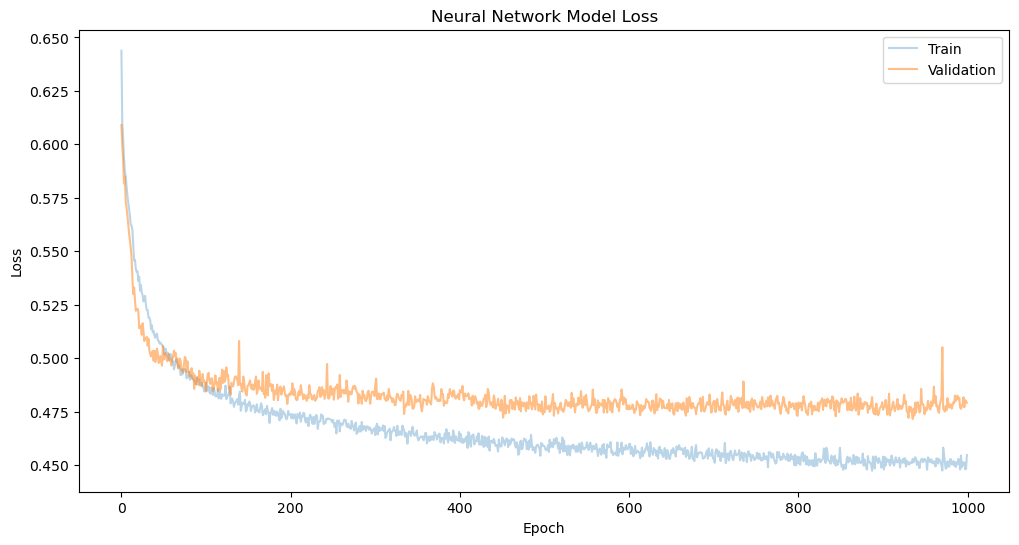

In [227]:
# plot to check how the network optimized loss
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], alpha=0.3)
plt.plot(history.history['val_loss'], alpha=0.5)
plt.title('Neural Network Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.ylim(0.4, 0.8)
plt.legend(['Train', 'Validation'])
plt.show()

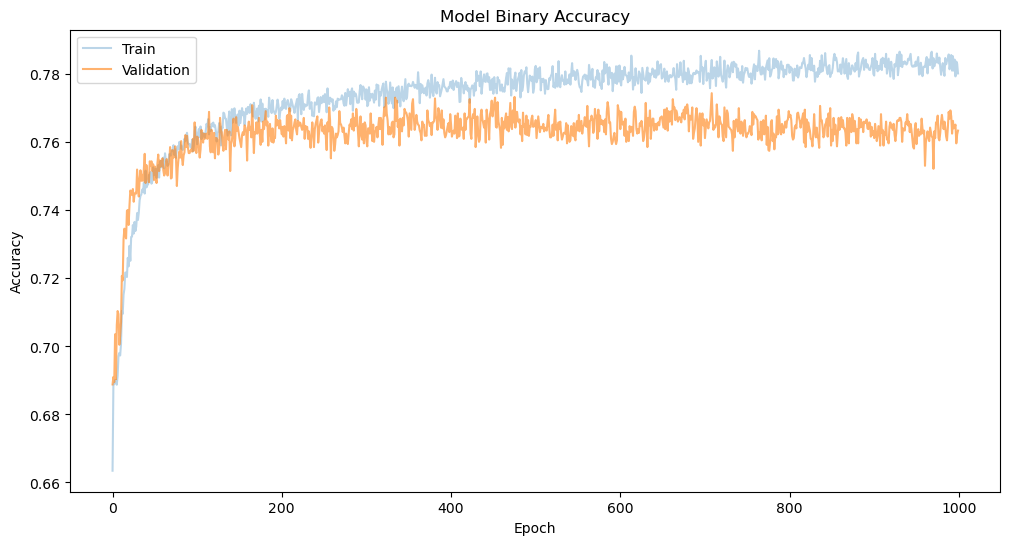

In [228]:
# plot to check binary accuracy
plt.figure(figsize=(12,6))
plt.plot(history.history['binary_accuracy'], alpha=0.3)
plt.plot(history.history['val_binary_accuracy'], alpha=0.6)
plt.title('Model Binary Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [229]:
# sanity check for metric names
neural_five.metrics_names

['loss', 'binary_accuracy', 'precision_8', 'recall_8']

In [230]:
# Evaluate the network
train_accuracy = history.history[neural_five.metrics_names[1]][-1]
recall = history.history[neural_five.metrics_names[3]][-1]
precision = history.history[neural_five.metrics_names[2]][-1]
result = neural_five.evaluate(X_test_scaled,y_test, verbose=2)

# accuracy
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")
# precision
print(f"Train Precision: {precision:.4f}")
print(f"Test Precision: {result[2]:.4f}")
# recall 
print(f"Train Recall: {recall:.4f}")
print(f"Test Recall: {result[3]:.4f}")

180/180 - 0s - loss: 0.4883 - binary_accuracy: 0.7650 - precision_8: 0.6478 - recall_8: 0.5287
Train Accuracy: 0.7802
Test Accuracy: 0.7650
Train Precision: 0.6796
Test Precision: 0.6478
Train Recall: 0.5493
Test Recall: 0.5287


In [231]:
# Get class predictions (soft predictions)
y_pred = neural_five.predict(X_test_scaled)

In [232]:
y_pred_bool = (y_pred>0.5)
y_pred_bool

array([[ True],
       [False],
       [False],
       ...,
       [False],
       [ True],
       [ True]])

Let's get the classification report. 

In [233]:
# Classification score
neural_five_report = classification_report(y_test, y_pred_bool)
print(neural_five_report)

              precision    recall  f1-score   support

           0       0.80      0.87      0.84      3963
           1       0.65      0.53      0.58      1778

    accuracy                           0.77      5741
   macro avg       0.73      0.70      0.71      5741
weighted avg       0.76      0.77      0.76      5741



Summary of Models:

|       **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                                                                                  |
|:--------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|--------------------------------------------------------------------------------------------------------------------------------------|
| Logistic Regression  | 0.728                  | 0.728             | 0.36       | 0.60          | 0.45         | StandardScaler(), No dimension reduction,  C=1, solver='lbfgs'                                                                       |
| Decision Tree 1      | 0.775                  | 0.754             | 0.48       | 0.64          | 0.55         | max_depth=8                                                                                                                          |
| Decision Tree 2 (CV) | 0.827                  | 0.72              | 0.56       | 0.55          | 0.55         | max_depth=11, criterion='gini', PCA=16                                                                                               |
| Random Forest 1 (CV) | 0.817                  | 0.759             | 0.36       | 0.73          | 0.48         | max_depth=14, criterion='gini', n_estimators=161, max_leaf_nodes=185, PCA=none                                                       |
| Random Forest 2      | 0.826                  | 0.773             | 0.42       | 0.73          | 0.53         | max_depth=14, max_leaf_nodes=176, n_estimators=161, criterion='gini'                                                                 |
| Random Forest 3      | 0.832                  | 0.775             | 0.42       | 0.74          | 0.54         | max_depth=15, criterion='gini', n_estimators=191, max_leaf_nodes=200                                                                 |
| XGBoost 1 (CV)       | 0.799                  | 0.775             | 0.48       | 0.70          | 0.57         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=23                   |
| XGBoost 2            | 0.922                  | 0.798             | 0.57       | 0.72          | 0.64         | default                                                                                                                              |
| XGBoost 3            | 0.847                  | 0.798             | 0.56       | 0.73          | 0.63         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=1.6                  |
| XGBoost 4            | 0.838                  | 0.795             | 0.54       | 0.73          | 0.62         | booster='gbtree', gamma=5.3, learning_rate=0.04, max_depth=19, min_child_weight=54, n_estimators=140, reg_alpha=1.6                  |
| SVM 1 (CV)           | 0.994                  | 0.818             | 0.68       | 0.72          | 0.70         | C=10, gamma=0.315, kernel='rbf', scale='StandardScaler()'                                                                            |
| SVM 2                | 0.823                  | 0.777             | 0.51       | 0.69          | 0.59         | C=1, gamma=0.1, kernel='rbf', scale='StandardScaler()'                                                                               |
| SVM 3                | 0.839                  | 0.783             | 0.55       | 0.69          | 0.61         | C=7.75, gamma=0.05, kernel='rbf', scale='StandardScaler()'                                                                           |
| Neural 1             | 0.760                  | 0.757             | 0.46       | 0.65          | 0.54         | Layers=5x10relu w/ BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                                |
| Neural 2             | 0.800                  | 0.769             | 0.52       | 0.66          | 0.58         | Layers=10x20relu w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                                |
| Neural 3             | 0.838                  | 0.769             | 0.60       | 0.63          | 0.62         | Layers=5x32relu, w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                                |
| Neural 4             | 0.823                  | 0.772             | 0.58       | 0.65          | 0.61         | Layers=5x32relu, w/BatchNormalization, w/L1regularizer=0.001, Output=sigmoid, epochs=250, Opt=Adam, loss=binarycrossentropy          |
| Neural 5             | 0.780                  | 0.765             | 0.53       | 0.65          | 0.58         | Layers=15x16relu, w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                               |

**Summary** 
- No overfitting. 

- Similar evaluation metric scores as Neural 2, albeit with lesser chance of overfitting. 

#### Neural 6

Final iteration with a series of dense layers with varying nodes and `BatchNormalization()` and 'relu' activation. The output layer will have a single 'sigmoid' node. 

Structure for dense layers (Layers x nodes): 3x32 -> 1x24 -> 4x8


In [308]:
# Create a new sequential model
neural_six = keras.Sequential()

# Declare the hidden layers
# First 3 layers w/ 32 nodes
neural_six.add(layers.Dense(32, activation="relu"))
neural_six.add(layers.BatchNormalization())
neural_six.add(layers.Dense(32, activation="relu"))
neural_six.add(layers.BatchNormalization())
neural_six.add(layers.Dense(32, activation="relu"))
neural_six.add(layers.BatchNormalization())

# Middle 1 layer w/ 24 nodes
neural_six.add(layers.Dense(24, activation="relu"))
neural_six.add(layers.BatchNormalization())

# Last 4 layers w/ 8 nodes
neural_six.add(layers.Dense(8, activation="relu"))
neural_six.add(layers.BatchNormalization())
neural_six.add(layers.Dense(8, activation="relu"))
neural_six.add(layers.BatchNormalization())
neural_six.add(layers.Dense(8, activation="relu"))
neural_six.add(layers.BatchNormalization())
neural_six.add(layers.Dense(8, activation="relu"))
neural_six.add(layers.BatchNormalization())

# Declare the output layer
neural_six.add(layers.Dense(1, activation="sigmoid"))

neural_six.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall()]
)

In [309]:
time = timer()
history = neural_six.fit(X_train_scaled, y_train, epochs=1000, verbose=1, validation_data=(X_validation_scaled, y_validation))
runtime = timer(time)

Epoch 1/1000
539/539 [==============================] - 2s 3ms/step - loss: 0.6398 - binary_accuracy: 0.6479 - precision_17: 0.3388 - recall_17: 0.1438 - val_loss: 0.5831 - val_binary_accuracy: 0.6877 - val_precision_17: 0.3929 - val_recall_17: 0.0156
Epoch 2/1000
539/539 [==============================] - 1s 2ms/step - loss: 0.5820 - binary_accuracy: 0.6891 - precision_17: 0.4450 - recall_17: 0.0159 - val_loss: 0.5644 - val_binary_accuracy: 0.6897 - val_precision_17: 0.4348 - val_recall_17: 0.0071
Epoch 3/1000
539/539 [==============================] - 1s 2ms/step - loss: 0.5675 - binary_accuracy: 0.6919 - precision_17: 0.5089 - recall_17: 0.1500 - val_loss: 0.5510 - val_binary_accuracy: 0.6945 - val_precision_17: 0.5126 - val_recall_17: 0.2736
Epoch 4/1000
539/539 [==============================] - 1s 2ms/step - loss: 0.5580 - binary_accuracy: 0.7042 - precision_17: 0.5328 - recall_17: 0.3638 - val_loss: 0.5424 - val_binary_accuracy: 0.7183 - val_precision_17: 0.5567 - val_recall_17:

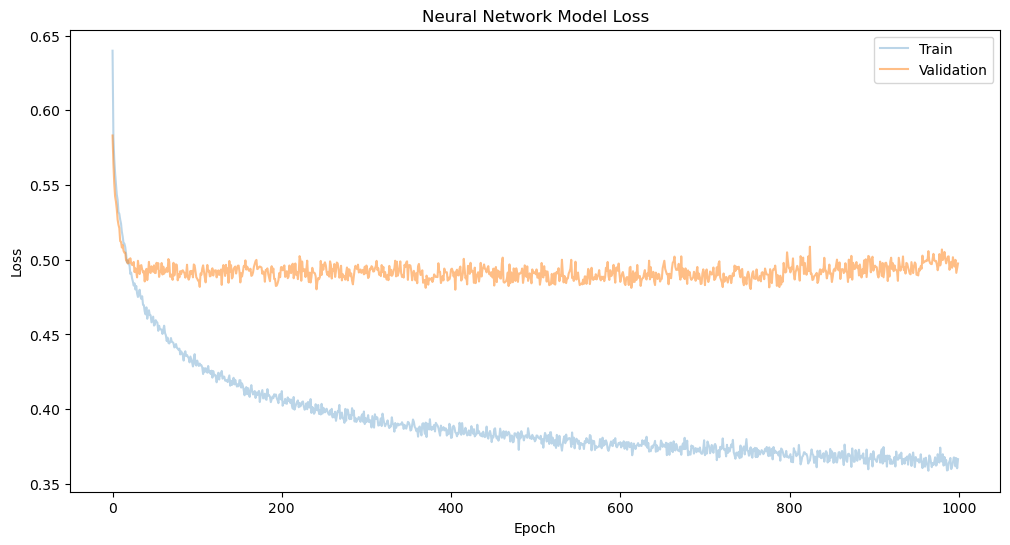

In [310]:
# plot to check how the network optimized loss
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], alpha=0.3)
plt.plot(history.history['val_loss'], alpha=0.5)
plt.title('Neural Network Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.ylim(0.4, 0.8)
plt.legend(['Train', 'Validation'])
plt.show()

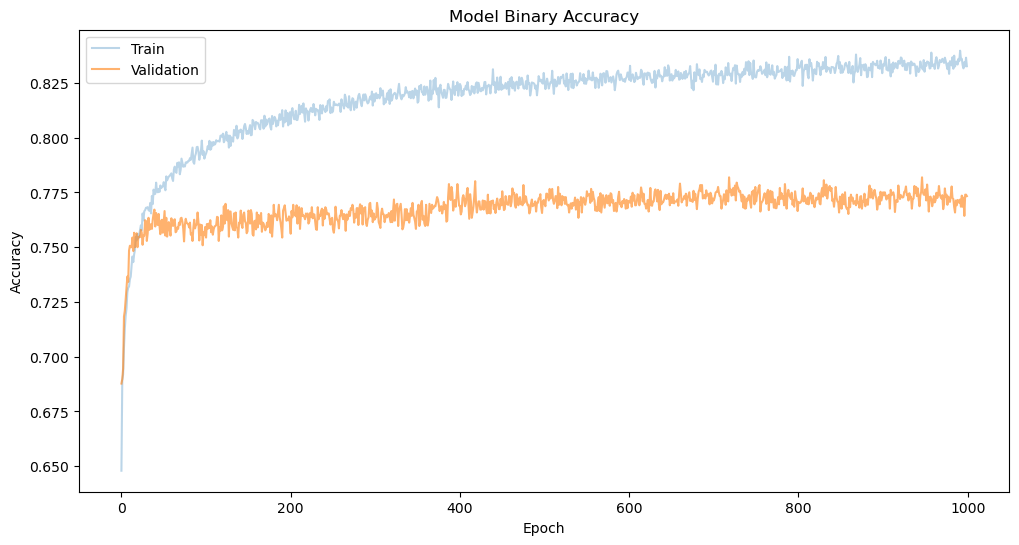

In [311]:
# plot to check binary accuracy
plt.figure(figsize=(12,6))
plt.plot(history.history['binary_accuracy'], alpha=0.3)
plt.plot(history.history['val_binary_accuracy'], alpha=0.6)
plt.title('Model Binary Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [312]:
# sanity check for metric names
neural_six.metrics_names

['loss', 'binary_accuracy', 'precision_17', 'recall_17']

In [313]:
# Evaluate the network
train_accuracy = history.history[neural_six.metrics_names[1]][-1]
recall = history.history[neural_six.metrics_names[3]][-1]
precision = history.history[neural_six.metrics_names[2]][-1]
result = neural_six.evaluate(X_test_scaled,y_test, verbose=2)

# accuracy
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")
# precision
print(f"Train Precision: {precision:.4f}")
print(f"Test Precision: {result[2]:.4f}")
# recall 
print(f"Train Recall: {recall:.4f}")
print(f"Test Recall: {result[3]:.4f}")

180/180 - 0s - loss: 0.4996 - binary_accuracy: 0.7727 - precision_17: 0.6500 - recall_17: 0.5765
Train Accuracy: 0.8327
Test Accuracy: 0.7727
Train Precision: 0.7577
Test Precision: 0.6500
Train Recall: 0.6757
Test Recall: 0.5765


In [314]:
# Get class predictions (soft predictions)
y_pred = neural_six.predict(X_test_scaled)

In [315]:
y_pred_bool = (y_pred>0.5)
y_pred_bool

array([[ True],
       [ True],
       [False],
       ...,
       [False],
       [False],
       [ True]])

Let's get the classification report. 

In [316]:
# Classification score
neural_six_report = classification_report(y_test, y_pred_bool)
print(neural_six_report)

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      3963
           1       0.65      0.58      0.61      1778

    accuracy                           0.77      5741
   macro avg       0.73      0.72      0.73      5741
weighted avg       0.77      0.77      0.77      5741



Summary of Models:

|       **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                                                                                  |
|:--------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|--------------------------------------------------------------------------------------------------------------------------------------|
| Logistic Regression  | 0.728                  | 0.728             | 0.36       | 0.60          | 0.45         | StandardScaler(), No dimension reduction,  C=1, solver='lbfgs'                                                                       |
| Decision Tree 1      | 0.775                  | 0.754             | 0.48       | 0.64          | 0.55         | max_depth=8                                                                                                                          |
| Decision Tree 2 (CV) | 0.827                  | 0.72              | 0.56       | 0.55          | 0.55         | max_depth=11, criterion='gini', PCA=16                                                                                               |
| Random Forest 1 (CV) | 0.817                  | 0.759             | 0.36       | 0.73          | 0.48         | max_depth=14, criterion='gini', n_estimators=161, max_leaf_nodes=185, PCA=none                                                       |
| Random Forest 2      | 0.826                  | 0.773             | 0.42       | 0.73          | 0.53         | max_depth=14, max_leaf_nodes=176, n_estimators=161, criterion='gini'                                                                 |
| Random Forest 3      | 0.832                  | 0.775             | 0.42       | 0.74          | 0.54         | max_depth=15, criterion='gini', n_estimators=191, max_leaf_nodes=200                                                                 |
| XGBoost 1 (CV)       | 0.799                  | 0.775             | 0.48       | 0.70          | 0.57         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=23                   |
| XGBoost 2            | 0.922                  | 0.798             | 0.57       | 0.72          | 0.64         | default                                                                                                                              |
| XGBoost 3            | 0.847                  | 0.798             | 0.56       | 0.73          | 0.63         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=1.6                  |
| XGBoost 4            | 0.838                  | 0.795             | 0.54       | 0.73          | 0.62         | booster='gbtree', gamma=5.3, learning_rate=0.04, max_depth=19, min_child_weight=54, n_estimators=140, reg_alpha=1.6                  |
| SVM 1 (CV)           | 0.994                  | 0.818             | 0.68       | 0.72          | 0.70         | C=10, gamma=0.315, kernel='rbf', scale='StandardScaler()'                                                                            |
| SVM 2                | 0.823                  | 0.777             | 0.51       | 0.69          | 0.59         | C=1, gamma=0.1, kernel='rbf', scale='StandardScaler()'                                                                               |
| SVM 3                | 0.839                  | 0.783             | 0.55       | 0.69          | 0.61         | C=7.75, gamma=0.05, kernel='rbf', scale='StandardScaler()'                                                                           |
| Neural 1             | 0.760                  | 0.757             | 0.46       | 0.65          | 0.54         | Layers=5x10relu w/ BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                                |
| Neural 2             | 0.800                  | 0.769             | 0.52       | 0.66          | 0.58         | Layers=10x20relu w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                                |
| Neural 3             | 0.838                  | 0.769             | 0.60       | 0.63          | 0.62         | Layers=5x32relu, w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                                |
| Neural 4             | 0.823                  | 0.772             | 0.58       | 0.65          | 0.61         | Layers=5x32relu, w/BatchNormalization, w/L1regularizer=0.001, Output=sigmoid, epochs=250, Opt=Adam, loss=binarycrossentropy          |
| Neural 5             | 0.780                  | 0.765             | 0.53       | 0.65          | 0.58         | Layers=15x16relu, w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                               |
| Neural 6             | 0.833                  | 0.773             | 0.58       | 0.65          | 0.61         | Layers=3x32relu-1x24relu-4x8relu, w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy               |

**Summary**
- Slightly overfitting.

- Identical evaluation metric scores as Neural 4.

#### Neural 7

In a bid to control overfitting seen in some Neural models so far, I will switch the activation function to Leaky Rectified Linear Unit (Leaky ReLU). Leaky ReLU outputs the input for values greater than 0. However, unlike ReLU it does not output 0 for negative inputs. Instead, it allows for a small, non-zero gradient when the unit is inactive (i.e. when unit outputs zero). I will start by changing th activation function in Neural 3 from 'relu' to 'LeakyReLU'.

In [490]:
# Create a new sequential model
neural_seven = keras.Sequential()

# Declare the hidden layers
# First 5 layers
neural_seven.add(layers.Dense(32, activation=keras.layers.LeakyReLU(alpha=0.01)))
neural_seven.add(layers.BatchNormalization())
neural_seven.add(layers.Dense(32, activation=keras.layers.LeakyReLU(alpha=0.01)))
neural_seven.add(layers.BatchNormalization())
neural_seven.add(layers.Dense(32, activation=keras.layers.LeakyReLU(alpha=0.01)))
neural_seven.add(layers.BatchNormalization())
neural_seven.add(layers.Dense(32, activation=keras.layers.LeakyReLU(alpha=0.01)))
neural_seven.add(layers.BatchNormalization())
neural_seven.add(layers.Dense(32, activation=keras.layers.LeakyReLU(alpha=0.01)))
neural_seven.add(layers.BatchNormalization())

# Declare the output layer
neural_seven.add(layers.Dense(1, activation="sigmoid"))

neural_seven.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall()]
)

In [491]:
time = timer()
history = neural_seven.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_validation_scaled, y_validation))
runtime = timer(time)

Epoch 1/250
539/539 [==============================] - 1s 2ms/step - loss: 0.5980 - binary_accuracy: 0.6841 - precision_38: 0.4854 - recall_38: 0.3323 - val_loss: 0.5481 - val_binary_accuracy: 0.7245 - val_precision_38: 0.5777 - val_recall_38: 0.4094
Epoch 2/250
539/539 [==============================] - 1s 2ms/step - loss: 0.5548 - binary_accuracy: 0.7163 - precision_38: 0.5739 - recall_38: 0.3265 - val_loss: 0.5319 - val_binary_accuracy: 0.7328 - val_precision_38: 0.6158 - val_recall_38: 0.3646
Epoch 3/250
539/539 [==============================] - 1s 2ms/step - loss: 0.5443 - binary_accuracy: 0.7225 - precision_38: 0.5843 - recall_38: 0.3608 - val_loss: 0.5252 - val_binary_accuracy: 0.7366 - val_precision_38: 0.6244 - val_recall_38: 0.3746
Epoch 4/250
539/539 [==============================] - 1s 2ms/step - loss: 0.5315 - binary_accuracy: 0.7329 - precision_38: 0.6058 - recall_38: 0.3939 - val_loss: 0.5217 - val_binary_accuracy: 0.7423 - val_precision_38: 0.6285 - val_recall_38: 0.4

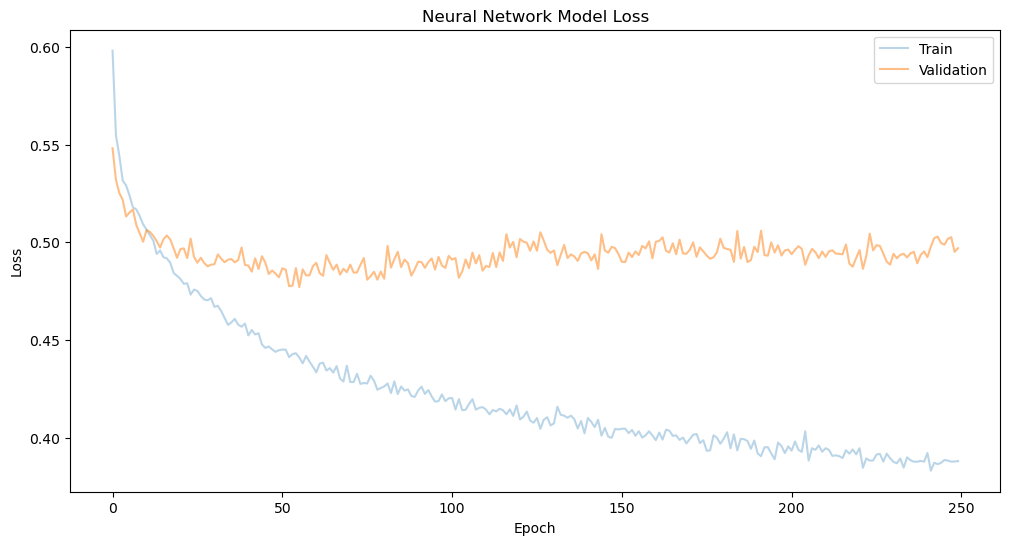

In [492]:
# plot to check how the network optimized loss
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], alpha=0.3)
plt.plot(history.history['val_loss'], alpha=0.5)
plt.title('Neural Network Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

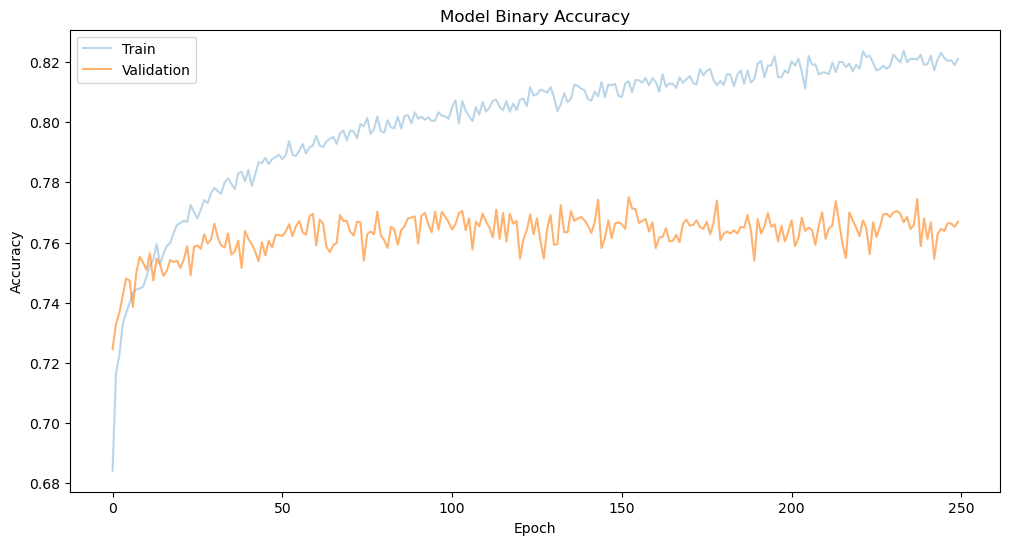

In [493]:
# plot to check binary accuracy
plt.figure(figsize=(12,6))
plt.plot(history.history['binary_accuracy'], alpha=0.3)
plt.plot(history.history['val_binary_accuracy'], alpha=0.6)
plt.title('Model Binary Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [494]:
# sanity check for metric names
neural_seven.metrics_names

['loss', 'binary_accuracy', 'precision_38', 'recall_38']

In [495]:
# Evaluate the network
train_accuracy = history.history[neural_seven.metrics_names[1]][-1]
recall = history.history[neural_seven.metrics_names[3]][-1]
precision = history.history[neural_seven.metrics_names[2]][-1]
result = neural_seven.evaluate(X_test_scaled,y_test, verbose=2)

# accuracy
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")
# precision
print(f"Train Precision: {precision:.4f}")
print(f"Test Precision: {result[2]:.4f}")
# recall 
print(f"Train Recall: {recall:.4f}")
print(f"Test Recall: {result[3]:.4f}")

180/180 - 0s - loss: 0.4878 - binary_accuracy: 0.7727 - precision_38: 0.6547 - recall_38: 0.5630
Train Accuracy: 0.8211
Test Accuracy: 0.7727
Train Precision: 0.7389
Test Precision: 0.6547
Train Recall: 0.6532
Test Recall: 0.5630


In [496]:
# Get class predictions (soft predictions)
y_pred = neural_seven.predict(X_test_scaled)

In [497]:
y_pred_bool = (y_pred>0.5)
y_pred_bool

array([[ True],
       [ True],
       [False],
       ...,
       [False],
       [False],
       [ True]])

In [498]:
# Classification score
neural_seven_report = classification_report(y_test, y_pred_bool)
print(neural_seven_report)

              precision    recall  f1-score   support

           0       0.82      0.87      0.84      3963
           1       0.65      0.56      0.61      1778

    accuracy                           0.77      5741
   macro avg       0.74      0.71      0.72      5741
weighted avg       0.77      0.77      0.77      5741



Summary of Models:

|       **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                                                                                  |
|:--------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|--------------------------------------------------------------------------------------------------------------------------------------|
| Logistic Regression  | 0.728                  | 0.728             | 0.36       | 0.60          | 0.45         | StandardScaler(), No dimension reduction,  C=1, solver='lbfgs'                                                                       |
| Decision Tree 1      | 0.775                  | 0.754             | 0.48       | 0.64          | 0.55         | max_depth=8                                                                                                                          |
| Decision Tree 2 (CV) | 0.827                  | 0.72              | 0.56       | 0.55          | 0.55         | max_depth=11, criterion='gini', PCA=16                                                                                               |
| Random Forest 1 (CV) | 0.817                  | 0.759             | 0.36       | 0.73          | 0.48         | max_depth=14, criterion='gini', n_estimators=161, max_leaf_nodes=185, PCA=none                                                       |
| Random Forest 2      | 0.826                  | 0.773             | 0.42       | 0.73          | 0.53         | max_depth=14, max_leaf_nodes=176, n_estimators=161, criterion='gini'                                                                 |
| Random Forest 3      | 0.832                  | 0.775             | 0.42       | 0.74          | 0.54         | max_depth=15, criterion='gini', n_estimators=191, max_leaf_nodes=200                                                                 |
| XGBoost 1 (CV)       | 0.799                  | 0.775             | 0.48       | 0.70          | 0.57         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=23                   |
| XGBoost 2            | 0.922                  | 0.798             | 0.57       | 0.72          | 0.64         | default                                                                                                                              |
| XGBoost 3            | 0.847                  | 0.798             | 0.56       | 0.73          | 0.63         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=1.6                  |
| XGBoost 4            | 0.838                  | 0.795             | 0.54       | 0.73          | 0.62         | booster='gbtree', gamma=5.3, learning_rate=0.04, max_depth=19, min_child_weight=54, n_estimators=140, reg_alpha=1.6                  |
| SVM 1 (CV)           | 0.994                  | 0.818             | 0.68       | 0.72          | 0.70         | C=10, gamma=0.315, kernel='rbf', scale='StandardScaler()'                                                                            |
| SVM 2                | 0.823                  | 0.777             | 0.51       | 0.69          | 0.59         | C=1, gamma=0.1, kernel='rbf', scale='StandardScaler()'                                                                               |
| SVM 3                | 0.839                  | 0.783             | 0.55       | 0.69          | 0.61         | C=7.75, gamma=0.05, kernel='rbf', scale='StandardScaler()'                                                                           |
| Neural 1             | 0.760                  | 0.757             | 0.46       | 0.65          | 0.54         | Layers=5x10relu w/ BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                                |
| Neural 2             | 0.800                  | 0.769             | 0.52       | 0.66          | 0.58         | Layers=10x20relu w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                                |
| Neural 3             | 0.838                  | 0.769             | 0.60       | 0.63          | 0.62         | Layers=5x32relu, w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                                |
| Neural 4             | 0.823                  | 0.772             | 0.58       | 0.65          | 0.61         | Layers=5x32relu, w/BatchNormalization, w/L1regularizer=0.001, Output=sigmoid, epochs=250, Opt=Adam, loss=binarycrossentropy          |
| Neural 5             | 0.780                  | 0.765             | 0.53       | 0.65          | 0.58         | Layers=15x16relu, w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                               |
| Neural 6             | 0.833                  | 0.773             | 0.58       | 0.65          | 0.61         | Layers=3x32relu-1x24relu-4x8relu, w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy               |
| Neural 7             | 0.821                  | 0.773             | 0.56       | 0.65          | 0.61         | Layers=5x32LeakyReLU, w/BatchNormalization, Output=sigmoid, epochs=250, Opt=Adam, loss-binarycrossentropy                            |

**Summary**
- No overfitting.

- Similar evaluation metric scores to Neural 4.

LeakyReLU activation has corrected the overfitting we saw in Neural 3 while giving similar evaluation metric scores. 

#### Neural 8

We will build a neural network with 10 dense layers of 32 nodes each. In order to combat overfitting, I will add a L1 regularizer to the first dense layer for Neural 8 model.

In [445]:
# Create a new sequential model
neural_eight = keras.Sequential()

regularizer = keras.regularizers.L1(l1=0.001)
# Declare the hidden layers
# First 5 layers w/ 32 nodes
neural_eight.add(layers.Dense(32, activation=keras.layers.LeakyReLU(alpha=0.01), kernel_regularizer=regularizer))
neural_eight.add(layers.BatchNormalization())
neural_eight.add(layers.Dense(32, activation=keras.layers.LeakyReLU(alpha=0.01)))
neural_eight.add(layers.BatchNormalization())
neural_eight.add(layers.Dense(32, activation=keras.layers.LeakyReLU(alpha=0.01)))
neural_eight.add(layers.BatchNormalization())
neural_eight.add(layers.Dense(32, activation=keras.layers.LeakyReLU(alpha=0.01)))
neural_eight.add(layers.BatchNormalization())
neural_eight.add(layers.Dense(32, activation=keras.layers.LeakyReLU(alpha=0.01)))
neural_eight.add(layers.BatchNormalization())

# Last 5 layers w/ 32 nodes
neural_eight.add(layers.Dense(32, activation=keras.layers.LeakyReLU(alpha=0.01)))
neural_eight.add(layers.BatchNormalization())
neural_eight.add(layers.Dense(32, activation=keras.layers.LeakyReLU(alpha=0.01)))
neural_eight.add(layers.BatchNormalization())
neural_eight.add(layers.Dense(32, activation=keras.layers.LeakyReLU(alpha=0.01)))
neural_eight.add(layers.BatchNormalization())
neural_eight.add(layers.Dense(32, activation=keras.layers.LeakyReLU(alpha=0.01)))
neural_eight.add(layers.BatchNormalization())
neural_eight.add(layers.Dense(32, activation=keras.layers.LeakyReLU(alpha=0.01)))
neural_eight.add(layers.BatchNormalization())

# Declare the output layer
neural_eight.add(layers.Dense(1, activation="sigmoid"))

neural_eight.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall()]
)

In [446]:
time = timer()
history = neural_eight.fit(X_train_scaled, y_train, epochs=350, verbose=1, validation_data=(X_validation_scaled, y_validation))
runtime = timer(time)

Epoch 1/350
539/539 [==============================] - 2s 3ms/step - loss: 0.7522 - binary_accuracy: 0.6553 - precision_33: 0.4001 - recall_33: 0.2264 - val_loss: 0.6976 - val_binary_accuracy: 0.7055 - val_precision_33: 0.5758 - val_recall_33: 0.1862
Epoch 2/350
539/539 [==============================] - 1s 2ms/step - loss: 0.6985 - binary_accuracy: 0.6943 - precision_33: 0.5150 - recall_33: 0.2222 - val_loss: 0.6739 - val_binary_accuracy: 0.7141 - val_precision_33: 0.5647 - val_recall_33: 0.3348
Epoch 3/350
539/539 [==============================] - 1s 2ms/step - loss: 0.6794 - binary_accuracy: 0.7037 - precision_33: 0.5458 - recall_33: 0.2576 - val_loss: 0.6625 - val_binary_accuracy: 0.7146 - val_precision_33: 0.5622 - val_recall_33: 0.3532
Epoch 4/350
539/539 [==============================] - 1s 2ms/step - loss: 0.6648 - binary_accuracy: 0.7078 - precision_33: 0.5538 - recall_33: 0.2898 - val_loss: 0.6466 - val_binary_accuracy: 0.7188 - val_precision_33: 0.5751 - val_recall_33: 0.3

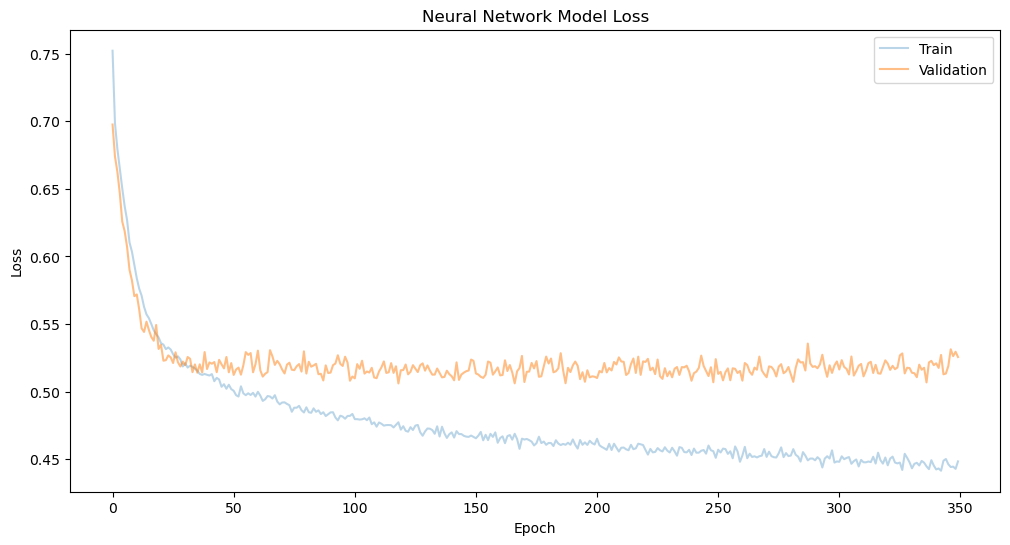

In [447]:
# plot to check how the network optimized loss
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], alpha=0.3)
plt.plot(history.history['val_loss'], alpha=0.5)
plt.title('Neural Network Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

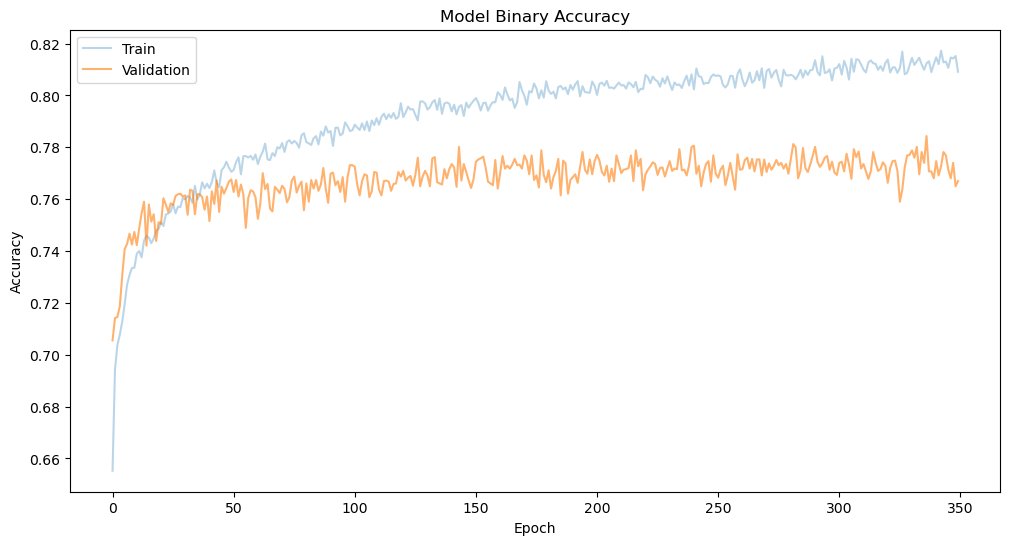

In [448]:
# plot to check binary accuracy
plt.figure(figsize=(12,6))
plt.plot(history.history['binary_accuracy'], alpha=0.3)
plt.plot(history.history['val_binary_accuracy'], alpha=0.6)
plt.title('Model Binary Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [449]:
# sanity check for metric names
neural_eight.metrics_names

['loss', 'binary_accuracy', 'precision_33', 'recall_33']

In [450]:
# Evaluate the network
train_accuracy = history.history[neural_eight.metrics_names[1]][-1]
recall = history.history[neural_eight.metrics_names[3]][-1]
precision = history.history[neural_eight.metrics_names[2]][-1]
result = neural_eight.evaluate(X_test_scaled,y_test, verbose=2)

# accuracy
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")
# precision
print(f"Train Precision: {precision:.4f}")
print(f"Test Precision: {result[2]:.4f}")
# recall 
print(f"Train Recall: {recall:.4f}")
print(f"Test Recall: {result[3]:.4f}")

180/180 - 0s - loss: 0.5256 - binary_accuracy: 0.7692 - precision_33: 0.6677 - recall_33: 0.5073
Train Accuracy: 0.8091
Test Accuracy: 0.7692
Train Precision: 0.7160
Test Precision: 0.6677
Train Recall: 0.6358
Test Recall: 0.5073


In [451]:
# Get class predictions (soft predictions)
y_pred = neural_eight.predict(X_test_scaled)

In [452]:
y_pred_bool = (y_pred>0.5)
y_pred_bool

array([[False],
       [ True],
       [False],
       ...,
       [False],
       [ True],
       [ True]])

In [453]:
# Classification score
neural_eight_report = classification_report(y_test, y_pred_bool)
print(neural_eight_report)

              precision    recall  f1-score   support

           0       0.80      0.89      0.84      3963
           1       0.67      0.51      0.58      1778

    accuracy                           0.77      5741
   macro avg       0.73      0.70      0.71      5741
weighted avg       0.76      0.77      0.76      5741



Summary of Models: 

|       **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                                                                                 |
|:--------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|-------------------------------------------------------------------------------------------------------------------------------------|
| Logistic Regression  | 0.728                  | 0.728             | 0.36       | 0.60          | 0.45         | StandardScaler(), No dimension reduction,  C=1, solver='lbfgs'                                                                      |
| Decision Tree 1      | 0.775                  | 0.754             | 0.48       | 0.64          | 0.55         | max_depth=8                                                                                                                         |
| Decision Tree 2 (CV) | 0.827                  | 0.72              | 0.56       | 0.55          | 0.55         | max_depth=11, criterion='gini', PCA=16                                                                                              |
| Random Forest 1 (CV) | 0.817                  | 0.759             | 0.36       | 0.73          | 0.48         | max_depth=14, criterion='gini', n_estimators=161, max_leaf_nodes=185, PCA=none                                                      |
| Random Forest 2      | 0.826                  | 0.773             | 0.42       | 0.73          | 0.53         | max_depth=14, max_leaf_nodes=176, n_estimators=161, criterion='gini'                                                                |
| Random Forest 3      | 0.832                  | 0.775             | 0.42       | 0.74          | 0.54         | max_depth=15, criterion='gini', n_estimators=191, max_leaf_nodes=200                                                                |
| XGBoost 1 (CV)       | 0.799                  | 0.775             | 0.48       | 0.70          | 0.57         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=23                  |
| XGBoost 2            | 0.922                  | 0.798             | 0.57       | 0.72          | 0.64         | default                                                                                                                             |
| XGBoost 3            | 0.847                  | 0.798             | 0.56       | 0.73          | 0.63         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=1.6                 |
| XGBoost 4            | 0.838                  | 0.795             | 0.54       | 0.73          | 0.62         | booster='gbtree', gamma=5.3, learning_rate=0.04, max_depth=19, min_child_weight=54, n_estimators=140, reg_alpha=1.6                 |
| SVM 1 (CV)           | 0.994                  | 0.818             | 0.68       | 0.72          | 0.70         | C=10, gamma=0.315, kernel='rbf', scale='StandardScaler()'                                                                           |
| SVM 2                | 0.823                  | 0.777             | 0.51       | 0.69          | 0.59         | C=1, gamma=0.1, kernel='rbf', scale='StandardScaler()'                                                                              |
| SVM 3                | 0.839                  | 0.783             | 0.55       | 0.69          | 0.61         | C=7.75, gamma=0.05, kernel='rbf', scale='StandardScaler()'                                                                          |
| Neural 1             | 0.760                  | 0.757             | 0.46       | 0.65          | 0.54         | Layers=5x10relu w/ BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                               |
| Neural 2             | 0.800                  | 0.769             | 0.52       | 0.66          | 0.58         | Layers=10x20relu w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                               |
| Neural 3             | 0.838                  | 0.769             | 0.60       | 0.63          | 0.62         | Layers=5x32relu, w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                               |
| Neural 4             | 0.823                  | 0.772             | 0.58       | 0.65          | 0.61         | Layers=5x32relu, w/BatchNormalization, w/L1regularizer=0.001, Output=sigmoid, epochs=250, Opt=Adam, loss=binarycrossentropy         |
| Neural 5             | 0.780                  | 0.765             | 0.53       | 0.65          | 0.58         | Layers=15x16relu, w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                              |
| Neural 6             | 0.833                  | 0.773             | 0.58       | 0.65          | 0.61         | Layers=3x32relu-1x24relu-4x8relu, w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy              |
| Neural 7             | 0.821                  | 0.773             | 0.56       | 0.65          | 0.61         | Layers=5x32LeakyReLU, w/BatchNormalization, Output=sigmoid, epochs=250, Opt=Adam, loss-binarycrossentropy                           |
| Neural 8             | 0.809                  | 0.769             | 0.51       | 0.67          | 0.58         | Layers=10x32LeakyReLU, w/BatchNormalization, w/L1regularizer=0.001, Output=sigmoid, epochs=350, Opt=Adam, loss=binarycrossentropy   |

**Summary**
- No overfitting.

- Low Recall scores leading to lower F1 score.
- Accuracy and Precision scores comparable to other better performing Neural Networks. 

#### Neural 9

So far, we have used the Rectified Linear Unit (ReLU) or Leaky ReLU activation functions in our dense layers. There is another, relatively newer activation function called 'swish' which is a Sigmoid Linear Unit function. 
$$f(x)=x\sigma(x)$$

It has been shown to provide better results than ReLU in a variety of different scenarios. Let's build the same model as Neural 8 but with 'swish' activation function to compare differences. We will allow the model to train for 500 epochs.

In [34]:
# Create a new sequential model
neural_nine = keras.Sequential()

regularizer = keras.regularizers.L1(l1=0.001)
# Declare the hidden layers
# First 5 layers w/ 32 nodes
neural_nine.add(layers.Dense(32, activation=keras.activations.swish, kernel_regularizer=regularizer))
neural_nine.add(layers.BatchNormalization())
neural_nine.add(layers.Dense(32, activation=keras.activations.swish))
neural_nine.add(layers.BatchNormalization())
neural_nine.add(layers.Dense(32, activation=keras.activations.swish))
neural_nine.add(layers.BatchNormalization())
neural_nine.add(layers.Dense(32, activation=keras.activations.swish))
neural_nine.add(layers.BatchNormalization())
neural_nine.add(layers.Dense(32, activation=keras.activations.swish))
neural_nine.add(layers.BatchNormalization())

# Last 5 layers w/ 32 nodes
neural_nine.add(layers.Dense(32, activation=keras.activations.swish))
neural_nine.add(layers.BatchNormalization())
neural_nine.add(layers.Dense(32, activation=keras.activations.swish))
neural_nine.add(layers.BatchNormalization())
neural_nine.add(layers.Dense(32, activation=keras.activations.swish))
neural_nine.add(layers.BatchNormalization())
neural_nine.add(layers.Dense(32, activation=keras.activations.swish))
neural_nine.add(layers.BatchNormalization())
neural_nine.add(layers.Dense(32, activation=keras.activations.swish))
neural_nine.add(layers.BatchNormalization())

# Declare the output layer
neural_nine.add(layers.Dense(1, activation="sigmoid"))

neural_nine.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall()]
)

In [35]:
time = timer()
history = neural_nine.fit(X_train_scaled, y_train, epochs=500, verbose=1, validation_data=(X_validation_scaled, y_validation))
runtime = timer(time)

Epoch 1/500
539/539 [==============================] - 2s 3ms/step - loss: 0.7076 - binary_accuracy: 0.6798 - precision: 0.4741 - recall: 0.3101 - val_loss: 0.6517 - val_binary_accuracy: 0.7165 - val_precision: 0.6092 - val_recall: 0.2360
Epoch 2/500
539/539 [==============================] - 1s 2ms/step - loss: 0.6591 - binary_accuracy: 0.7118 - precision: 0.5650 - recall: 0.3011 - val_loss: 0.6264 - val_binary_accuracy: 0.7320 - val_precision: 0.6061 - val_recall: 0.3838
Epoch 3/500
539/539 [==============================] - 1s 3ms/step - loss: 0.6339 - binary_accuracy: 0.7221 - precision: 0.5825 - recall: 0.3623 - val_loss: 0.6037 - val_binary_accuracy: 0.7405 - val_precision: 0.6133 - val_recall: 0.4385
Epoch 4/500
539/539 [==============================] - 1s 3ms/step - loss: 0.6121 - binary_accuracy: 0.7244 - precision: 0.5831 - recall: 0.3864 - val_loss: 0.5963 - val_binary_accuracy: 0.7353 - val_precision: 0.6513 - val_recall: 0.3120
Epoch 5/500
539/539 [=======================

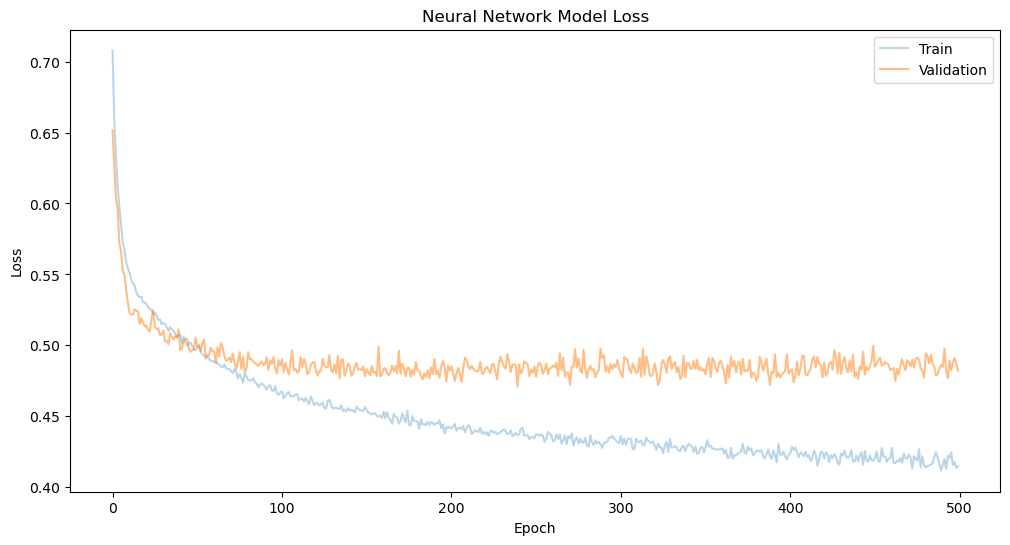

In [36]:
# plot to check how the network optimized loss
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], alpha=0.3)
plt.plot(history.history['val_loss'], alpha=0.5)
plt.title('Neural Network Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

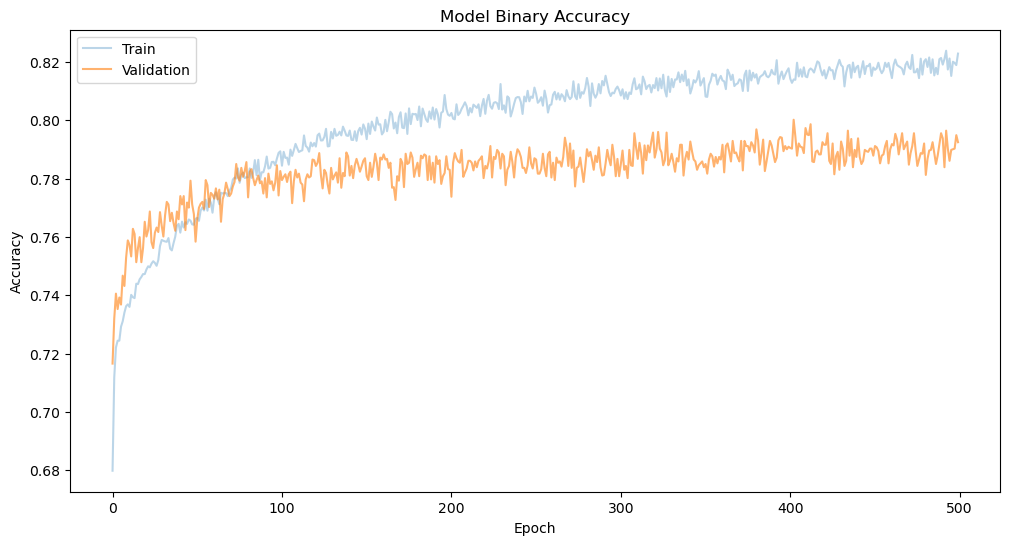

In [37]:
# plot to check binary accuracy
plt.figure(figsize=(12,6))
plt.plot(history.history['binary_accuracy'], alpha=0.3)
plt.plot(history.history['val_binary_accuracy'], alpha=0.6)
plt.title('Model Binary Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [38]:
# sanity check for metric names
neural_nine.metrics_names

['loss', 'binary_accuracy', 'precision', 'recall']

In [39]:
# Evaluate the network
train_accuracy = history.history[neural_nine.metrics_names[1]][-1]
recall = history.history[neural_nine.metrics_names[3]][-1]
precision = history.history[neural_nine.metrics_names[2]][-1]
result = neural_nine.evaluate(X_test_scaled,y_test, verbose=2)

# accuracy
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")
# precision
print(f"Train Precision: {precision:.4f}")
print(f"Test Precision: {result[2]:.4f}")
# recall 
print(f"Train Recall: {recall:.4f}")
print(f"Test Recall: {result[3]:.4f}")

180/180 - 1s - loss: 0.4874 - binary_accuracy: 0.7844 - precision: 0.6715 - recall: 0.5945
Train Accuracy: 0.8229
Test Accuracy: 0.7844
Train Precision: 0.7453
Test Precision: 0.6715
Train Recall: 0.6503
Test Recall: 0.5945


In [40]:
# Get class predictions (soft predictions)
y_pred = neural_nine.predict(X_test_scaled)

In [43]:
y_pred_bool = (y_pred>0.5)
y_pred_bool

array([[ True],
       [ True],
       [False],
       ...,
       [False],
       [ True],
       [ True]])

In [44]:
# Classification score
neural_nine_report = classification_report(y_test, y_pred_bool)
print(neural_nine_report)

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      3963
           1       0.67      0.59      0.63      1778

    accuracy                           0.78      5741
   macro avg       0.75      0.73      0.74      5741
weighted avg       0.78      0.78      0.78      5741



Summary of Models: 

|       **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                                                                                 |
|:--------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|-------------------------------------------------------------------------------------------------------------------------------------|
| Logistic Regression  | 0.728                  | 0.728             | 0.36       | 0.60          | 0.45         | StandardScaler(), No dimension reduction,  C=1, solver='lbfgs'                                                                      |
| Decision Tree 1      | 0.775                  | 0.754             | 0.48       | 0.64          | 0.55         | max_depth=8                                                                                                                         |
| Decision Tree 2 (CV) | 0.827                  | 0.72              | 0.56       | 0.55          | 0.55         | max_depth=11, criterion='gini', PCA=16                                                                                              |
| Random Forest 1 (CV) | 0.817                  | 0.759             | 0.36       | 0.73          | 0.48         | max_depth=14, criterion='gini', n_estimators=161, max_leaf_nodes=185, PCA=none                                                      |
| Random Forest 2      | 0.826                  | 0.773             | 0.42       | 0.73          | 0.53         | max_depth=14, max_leaf_nodes=176, n_estimators=161, criterion='gini'                                                                |
| Random Forest 3      | 0.832                  | 0.775             | 0.42       | 0.74          | 0.54         | max_depth=15, criterion='gini', n_estimators=191, max_leaf_nodes=200                                                                |
| XGBoost 1 (CV)       | 0.799                  | 0.775             | 0.48       | 0.70          | 0.57         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=23                  |
| XGBoost 2            | 0.922                  | 0.798             | 0.57       | 0.72          | 0.64         | default                                                                                                                             |
| XGBoost 3            | 0.847                  | 0.798             | 0.56       | 0.73          | 0.63         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=1.6                 |
| XGBoost 4            | 0.838                  | 0.795             | 0.54       | 0.73          | 0.62         | booster='gbtree', gamma=5.3, learning_rate=0.04, max_depth=19, min_child_weight=54, n_estimators=140, reg_alpha=1.6                 |
| SVM 1 (CV)           | 0.994                  | 0.818             | 0.68       | 0.72          | 0.70         | C=10, gamma=0.315, kernel='rbf', scale='StandardScaler()'                                                                           |
| SVM 2                | 0.823                  | 0.777             | 0.51       | 0.69          | 0.59         | C=1, gamma=0.1, kernel='rbf', scale='StandardScaler()'                                                                              |
| SVM 3                | 0.839                  | 0.783             | 0.55       | 0.69          | 0.61         | C=7.75, gamma=0.05, kernel='rbf', scale='StandardScaler()'                                                                          |
| Neural 1             | 0.760                  | 0.757             | 0.46       | 0.65          | 0.54         | Layers=5x10relu w/ BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                               |
| Neural 2             | 0.800                  | 0.769             | 0.52       | 0.66          | 0.58         | Layers=10x20relu w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                               |
| Neural 3             | 0.838                  | 0.769             | 0.60       | 0.63          | 0.62         | Layers=5x32relu, w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                               |
| Neural 4             | 0.823                  | 0.772             | 0.58       | 0.65          | 0.61         | Layers=5x32relu, w/BatchNormalization, w/L1regularizer=0.001, Output=sigmoid, epochs=250, Opt=Adam, loss=binarycrossentropy         |
| Neural 5             | 0.780                  | 0.765             | 0.53       | 0.65          | 0.58         | Layers=15x16relu, w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                              |
| Neural 6             | 0.833                  | 0.773             | 0.58       | 0.65          | 0.61         | Layers=3x32relu-1x24relu-4x8relu, w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy              |
| Neural 7             | 0.821                  | 0.773             | 0.56       | 0.65          | 0.61         | Layers=5x32LeakyReLU, w/BatchNormalization, Output=sigmoid, epochs=250, Opt=Adam, loss-binarycrossentropy                           |
| Neural 8             | 0.809                  | 0.769             | 0.51       | 0.67          | 0.58         | Layers=10x32LeakyReLU, w/BatchNormalization, w/L1regularizer=0.001, Output=sigmoid, epochs=350, Opt=Adam, loss=binarycrossentropy   |
| Neural 9            | 0.823                  | 0.784             | 0.59       | 0.67          | 0.63         | Layers=10x32swish(SiLU), w/BatchNormalization, w/L1regularizer=0.001, Output=sigmoid, epochs=500, Opt=Adam, loss=binarycrossentropy |

**Summary**
- No overfitting,

- Moderate increase in Accuracy Score over Neural 8.
- Significant increase in Recall and F1 score over Neural 8.

The 'swish' activation function has outperformed 'LeakyReLU' by a significant margin for our data. One thing to note is that it took ~ 70% longer to train Neural 9 ('with swish activation) than Neural 8 (with LeakyReLU activation). 

#### Neural 10

I will build a model with half the number of layers as Neural 9, to see if we can get better generalization while keeping similar evaluation metric scores. 

In [71]:
# Create a new sequential model
neural_ten = keras.Sequential()

regularizer = keras.regularizers.L1(l1=0.001)
# Declare the hidden layers
# First 5 layers
neural_ten.add(layers.Dense(32, activation=keras.activations.swish, kernel_regularizer=regularizer))
neural_ten.add(layers.BatchNormalization())
neural_ten.add(layers.Dense(32, activation=keras.activations.swish))
neural_ten.add(layers.BatchNormalization())
neural_ten.add(layers.Dense(32, activation=keras.activations.swish))
neural_ten.add(layers.BatchNormalization())
neural_ten.add(layers.Dense(32, activation=keras.activations.swish))
neural_ten.add(layers.BatchNormalization())
neural_ten.add(layers.Dense(32, activation=keras.activations.swish))
neural_ten.add(layers.BatchNormalization())

# Declare the output layer
neural_ten.add(layers.Dense(1, activation="sigmoid"))

neural_ten.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall()]
)

In [72]:
time = timer()
history = neural_ten.fit(X_train_scaled, y_train, epochs=500, verbose=1, validation_data=(X_validation_scaled, y_validation))
runtime = timer(time)

Epoch 1/500
539/539 [==============================] - 1s 3ms/step - loss: 0.6929 - binary_accuracy: 0.6931 - precision_3: 0.5062 - recall_3: 0.3722 - val_loss: 0.6442 - val_binary_accuracy: 0.7302 - val_precision_3: 0.5926 - val_recall_3: 0.4115
Epoch 2/500
539/539 [==============================] - 1s 2ms/step - loss: 0.6417 - binary_accuracy: 0.7199 - precision_3: 0.5772 - recall_3: 0.3578 - val_loss: 0.6107 - val_binary_accuracy: 0.7353 - val_precision_3: 0.6382 - val_recall_3: 0.3348
Epoch 3/500
539/539 [==============================] - 1s 2ms/step - loss: 0.6129 - binary_accuracy: 0.7311 - precision_3: 0.6014 - recall_3: 0.3908 - val_loss: 0.5955 - val_binary_accuracy: 0.7423 - val_precision_3: 0.6382 - val_recall_3: 0.3873
Epoch 4/500
539/539 [==============================] - 1s 2ms/step - loss: 0.5946 - binary_accuracy: 0.7312 - precision_3: 0.6026 - recall_3: 0.3878 - val_loss: 0.5738 - val_binary_accuracy: 0.7469 - val_precision_3: 0.6182 - val_recall_3: 0.4776
Epoch 5/500


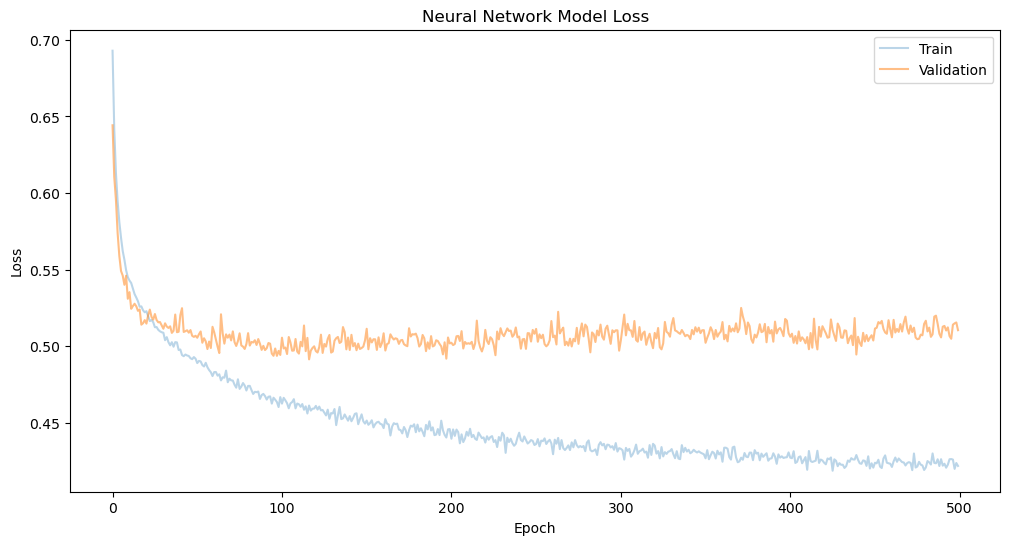

In [80]:
# plot to check how the network optimized loss
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], alpha=0.3)
plt.plot(history.history['val_loss'], alpha=0.5)
plt.title('Neural Network Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

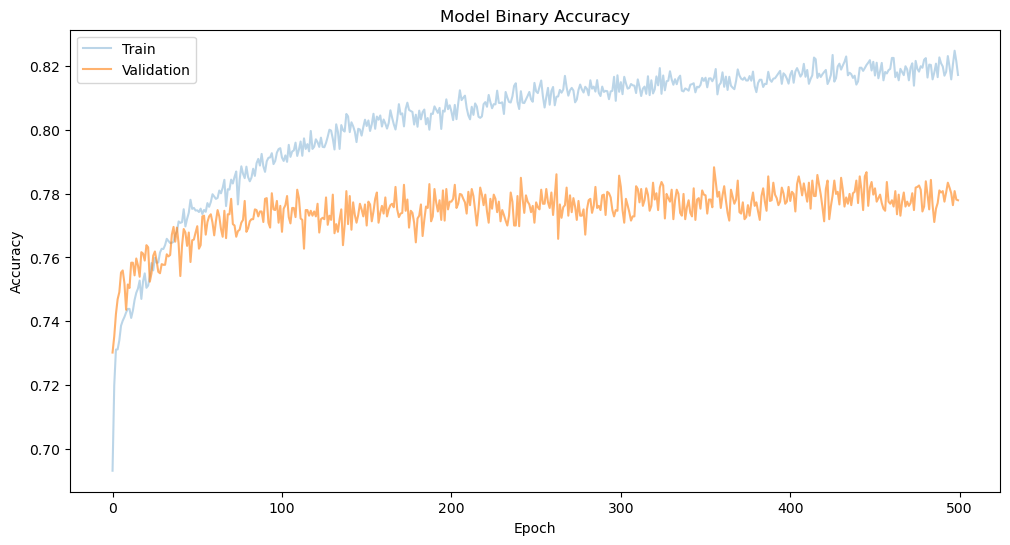

In [81]:
# plot to check binary accuracy
plt.figure(figsize=(12,6))
plt.plot(history.history['binary_accuracy'], alpha=0.3)
plt.plot(history.history['val_binary_accuracy'], alpha=0.6)
plt.title('Model Binary Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [82]:
# sanity check for metric names
neural_ten.metrics_names

['loss', 'binary_accuracy', 'precision_3', 'recall_3']

In [83]:
# Evaluate the network
train_accuracy = history.history[neural_ten.metrics_names[1]][-1]
recall = history.history[neural_ten.metrics_names[3]][-1]
precision = history.history[neural_ten.metrics_names[2]][-1]
result = neural_ten.evaluate(X_test_scaled,y_test, verbose=2)

# accuracy
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")
# precision
print(f"Train Precision: {precision:.4f}")
print(f"Test Precision: {result[2]:.4f}")
# recall 
print(f"Train Recall: {recall:.4f}")
print(f"Test Recall: {result[3]:.4f}")

180/180 - 0s - loss: 0.5073 - binary_accuracy: 0.7826 - precision_3: 0.6760 - recall_3: 0.5726
Train Accuracy: 0.8172
Test Accuracy: 0.7826
Train Precision: 0.7306
Test Precision: 0.6760
Train Recall: 0.6493
Test Recall: 0.5726


In [84]:
# Get class predictions (soft predictions)
y_pred = neural_ten.predict(X_test_scaled)

In [85]:
y_pred_bool = (y_pred>0.5)
y_pred_bool

array([[ True],
       [ True],
       [False],
       ...,
       [False],
       [False],
       [ True]])

In [86]:
# Classification score
neural_ten_report = classification_report(y_test, y_pred_bool)
print(neural_ten_report)

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      3963
           1       0.68      0.57      0.62      1778

    accuracy                           0.78      5741
   macro avg       0.75      0.72      0.73      5741
weighted avg       0.78      0.78      0.78      5741



Summary of Models:

|       **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                                                                                 |
|:--------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|-------------------------------------------------------------------------------------------------------------------------------------|
| Logistic Regression  | 0.728                  | 0.728             | 0.36       | 0.60          | 0.45         | StandardScaler(), No dimension reduction,  C=1, solver='lbfgs'                                                                      |
| Decision Tree 1      | 0.775                  | 0.754             | 0.48       | 0.64          | 0.55         | max_depth=8                                                                                                                         |
| Decision Tree 2 (CV) | 0.827                  | 0.72              | 0.56       | 0.55          | 0.55         | max_depth=11, criterion='gini', PCA=16                                                                                              |
| Random Forest 1 (CV) | 0.817                  | 0.759             | 0.36       | 0.73          | 0.48         | max_depth=14, criterion='gini', n_estimators=161, max_leaf_nodes=185, PCA=none                                                      |
| Random Forest 2      | 0.826                  | 0.773             | 0.42       | 0.73          | 0.53         | max_depth=14, max_leaf_nodes=176, n_estimators=161, criterion='gini'                                                                |
| Random Forest 3      | 0.832                  | 0.775             | 0.42       | 0.74          | 0.54         | max_depth=15, criterion='gini', n_estimators=191, max_leaf_nodes=200                                                                |
| XGBoost 1 (CV)       | 0.799                  | 0.775             | 0.48       | 0.70          | 0.57         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=23                  |
| XGBoost 2            | 0.922                  | 0.798             | 0.57       | 0.72          | 0.64         | default                                                                                                                             |
| XGBoost 3            | 0.847                  | 0.798             | 0.56       | 0.73          | 0.63         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=1.6                 |
| XGBoost 4            | 0.838                  | 0.795             | 0.54       | 0.73          | 0.62         | booster='gbtree', gamma=5.3, learning_rate=0.04, max_depth=19, min_child_weight=54, n_estimators=140, reg_alpha=1.6                 |
| SVM 1 (CV)           | 0.994                  | 0.818             | 0.68       | 0.72          | 0.70         | C=10, gamma=0.315, kernel='rbf', scale='StandardScaler()'                                                                           |
| SVM 2                | 0.823                  | 0.777             | 0.51       | 0.69          | 0.59         | C=1, gamma=0.1, kernel='rbf', scale='StandardScaler()'                                                                              |
| SVM 3                | 0.839                  | 0.783             | 0.55       | 0.69          | 0.61         | C=7.75, gamma=0.05, kernel='rbf', scale='StandardScaler()'                                                                          |
| Neural 1             | 0.760                  | 0.757             | 0.46       | 0.65          | 0.54         | Layers=5x10relu w/ BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                               |
| Neural 2             | 0.800                  | 0.769             | 0.52       | 0.66          | 0.58         | Layers=10x20relu w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                               |
| Neural 3             | 0.838                  | 0.769             | 0.60       | 0.63          | 0.62         | Layers=5x32relu, w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                               |
| Neural 4             | 0.823                  | 0.772             | 0.58       | 0.65          | 0.61         | Layers=5x32relu, w/BatchNormalization, w/L1regularizer=0.001, Output=sigmoid, epochs=250, Opt=Adam, loss=binarycrossentropy         |
| Neural 5             | 0.780                  | 0.765             | 0.53       | 0.65          | 0.58         | Layers=15x16relu, w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                              |
| Neural 6             | 0.833                  | 0.773             | 0.58       | 0.65          | 0.61         | Layers=3x32relu-1x24relu-4x8relu, w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy              |
| Neural 7             | 0.821                  | 0.773             | 0.56       | 0.65          | 0.61         | Layers=5x32LeakyReLU, w/BatchNormalization, Output=sigmoid, epochs=250, Opt=Adam, loss-binarycrossentropy                           |
| Neural 8             | 0.809                  | 0.769             | 0.51       | 0.67          | 0.58         | Layers=10x32LeakyReLU, w/BatchNormalization, w/L1regularizer=0.001, Output=sigmoid, epochs=350, Opt=Adam, loss=binarycrossentropy   |
| Neural 9             | 0.823                  | 0.784             | 0.59       | 0.67          | 0.63         | Layers=10x32swish(SiLU), w/BatchNormalization, w/L1regularizer=0.001, Output=sigmoid, epochs=500, Opt=Adam, loss=binarycrossentropy |
| Neural 10            | 0.817                  | 0.783             | 0.57       | 0.68          | 0.62         | Layers=5x32swish(SiLU), w/BatchNormalization, w/L1regularizer=0.001, Output=sigmoid, epochs=500, Opt=Adam, loss-binarycrossentropy  |

**Summary**
- Better generalization than Neural 9.

- Similar evaluation metric scores as Neural 9. 
- ~ 30% lesser computation time compared to Neural 9. 

----

## Summary

Below is the summary table for modeling and evaluation of models.

Summary of Models:

|       **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                                                                                 |
|:--------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|-------------------------------------------------------------------------------------------------------------------------------------|
| Logistic Regression  | 0.728                  | 0.728             | 0.36       | 0.60          | 0.45         | StandardScaler(), No dimension reduction,  C=1, solver='lbfgs'                                                                      |
| Decision Tree 1      | 0.775                  | 0.754             | 0.48       | 0.64          | 0.55         | max_depth=8                                                                                                                         |
| Decision Tree 2 (CV) | 0.827                  | 0.72              | 0.56       | 0.55          | 0.55         | max_depth=11, criterion='gini', PCA=16                                                                                              |
| Random Forest 1 (CV) | 0.817                  | 0.759             | 0.36       | 0.73          | 0.48         | max_depth=14, criterion='gini', n_estimators=161, max_leaf_nodes=185, PCA=none                                                      |
| Random Forest 2      | 0.826                  | 0.773             | 0.42       | 0.73          | 0.53         | max_depth=14, max_leaf_nodes=176, n_estimators=161, criterion='gini'                                                                |
| Random Forest 3      | 0.832                  | 0.775             | 0.42       | 0.74          | 0.54         | max_depth=15, criterion='gini', n_estimators=191, max_leaf_nodes=200                                                                |
| XGBoost 1 (CV)       | 0.799                  | 0.775             | 0.48       | 0.70          | 0.57         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=23                  |
| XGBoost 2            | 0.922                  | 0.798             | 0.57       | 0.72          | 0.64         | default                                                                                                                             |
| XGBoost 3            | 0.847                  | 0.798             | 0.56       | 0.73          | 0.63         | booster='gbtree', gamma=5.3, learning_rate=0.07, max_depth=19, min_child_weight=66, n_estimators=140, reg_alpha=1.6                 |
| XGBoost 4            | 0.838                  | 0.795             | 0.54       | 0.73          | 0.62         | booster='gbtree', gamma=5.3, learning_rate=0.04, max_depth=19, min_child_weight=54, n_estimators=140, reg_alpha=1.6                 |
| SVM 1 (CV)           | 0.994                  | 0.818             | 0.68       | 0.72          | 0.70         | C=10, gamma=0.315, kernel='rbf', scale='StandardScaler()'                                                                           |
| SVM 2                | 0.823                  | 0.777             | 0.51       | 0.69          | 0.59         | C=1, gamma=0.1, kernel='rbf', scale='StandardScaler()'                                                                              |
| SVM 3                | 0.839                  | 0.783             | 0.55       | 0.69          | 0.61         | C=7.75, gamma=0.05, kernel='rbf', scale='StandardScaler()'                                                                          |
| Neural 1             | 0.760                  | 0.757             | 0.46       | 0.65          | 0.54         | Layers=5x10relu w/ BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                               |
| Neural 2             | 0.800                  | 0.769             | 0.52       | 0.66          | 0.58         | Layers=10x20relu w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                               |
| Neural 3             | 0.838                  | 0.769             | 0.60       | 0.63          | 0.62         | Layers=5x32relu, w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                               |
| Neural 4             | 0.823                  | 0.772             | 0.58       | 0.65          | 0.61         | Layers=5x32relu, w/BatchNormalization, w/L1regularizer=0.001, Output=sigmoid, epochs=250, Opt=Adam, loss=binarycrossentropy         |
| Neural 5             | 0.780                  | 0.765             | 0.53       | 0.65          | 0.58         | Layers=15x16relu, w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy                              |
| Neural 6             | 0.833                  | 0.773             | 0.58       | 0.65          | 0.61         | Layers=3x32relu-1x24relu-4x8relu, w/BatchNormalization, Output=sigmoid, epochs=1000, Opt=Adam, loss=binarycrossentropy              |
| Neural 7             | 0.821                  | 0.773             | 0.56       | 0.65          | 0.61         | Layers=5x32LeakyReLU, w/BatchNormalization, Output=sigmoid, epochs=250, Opt=Adam, loss-binarycrossentropy                           |
| Neural 8             | 0.809                  | 0.769             | 0.51       | 0.67          | 0.58         | Layers=10x32LeakyReLU, w/BatchNormalization, w/L1regularizer=0.001, Output=sigmoid, epochs=350, Opt=Adam, loss=binarycrossentropy   |
| Neural 9             | 0.823                  | 0.784             | 0.59       | 0.67          | 0.63         | Layers=10x32swish(SiLU), w/BatchNormalization, w/L1regularizer=0.001, Output=sigmoid, epochs=500, Opt=Adam, loss=binarycrossentropy |
| Neural 10            | 0.817                  | 0.783             | 0.57       | 0.68          | 0.62         | Layers=5x32swish(SiLU), w/BatchNormalization, w/L1regularizer=0.001, Output=sigmoid, epochs=500, Opt=Adam, loss-binarycrossentropy  |

We were able to find three models that generalized well and had decent evaluation metric scores. 

|       **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                                                                                 |
|:--------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|-------------------------------------------------------------------------------------------------------------------------------------|
| XGBoost 4            | 0.838                  | 0.795             | 0.54       | 0.73          | 0.62         | booster='gbtree', gamma=5.3, learning_rate=0.04, max_depth=19, min_child_weight=54, n_estimators=140, reg_alpha=1.6                 |
| SVM 2                | 0.823                  | 0.777             | 0.51       | 0.69          | 0.59         | C=1, gamma=0.1, kernel='rbf', scale='StandardScaler()'                                                                          |
| Neural 9             | 0.823                  | 0.784             | 0.59       | 0.67          | 0.63         | Layers=10x32swish(SiLU), w/BatchNormalization, w/L1regularizer=0.001, Output=sigmoid, epochs=500, Opt=Adam, loss=binarycrossentropy |


Neural Networks look to be more promising, especially if we add more years of data in the future. XGBoost also shows promise and has the advantage of interpretability over Neural networks which are infamously considered black boxes. Significant efforts have to be made to tune hyperparameters for all modeling methods as our dataset seems quite prone to overfitting. 

Neural networks offer a distinct advantage when it comes to Recall/Precision calibration. We can easily manipulate the prediction threshold to get better Recall or Precision scores (lower threshold, higher Recall score).

**Next Steps**
- Increasing the year range will have a positive impact, especially for neural networks. 

- Adding more weather features could also help in training models. 
- We can also experiment with training some RNN models as other studies in the climate field have shown they can be effective predictor models.
- Additional feature engineering is also an option. 

--------------------------